In [264]:
# Se importa los paquetes necesarios
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from scipy.stats import mstats
from joblib import dump, load

In [265]:
! pip install miceforest
import miceforest as mf

# Load the Dataset

In [266]:
# Enlace
url ="https://github.com/Nolhandm/Trabajo-de-Maestria/raw/refs/heads/main/Objetivo%201%20-%20Integracion%20de%20datos/ESG_df_Completed.csv"

# Cargar en un dataFrame
ESG_df = pd.read_csv(url)
ESG_df

Country Name                                     Indicator Name  \
0            Cameroon  Access to clean fuels and technologies for coo...   
1            Cameroon            Access to electricity (% of population)   
2            Cameroon  Adjusted savings, natural resources depletion ...   
3            Cameroon  Adjusted savings, net forest depletion (% of GNI)   
4            Cameroon                 Agricultural land (% of land area)   
...               ...                                                ...   
18827  American Samoa  Total greenhouse gas emissions per capita excl...   
18828  American Samoa                                    Tree Cover Loss   
18829  American Samoa  Unemployment, total (% of total labor force) (...   
18830  American Samoa  Unmet need for contraception (% of married wom...   
18831  American Samoa                 Voice and Accountability: Estimate   

       1960     1961    1962     1963     1964     1965     1966     1967  \
0       NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
1       NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
2       NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
3       NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
4       NaN  15.8871  16.014  16.1198  16.2467  16.3737  16.5006  16.6487   
...     ...      ...     ...      ...      ...      ...      ...      ...   
18827   NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
18828   NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
18829   NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
18830   NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   
18831   NaN      NaN     NaN      NaN      NaN      NaN      NaN      NaN   

       ...     2015     2016     2017     2018     2019     2020     2021  \
0      ...  22.8000  23.6000  24.3000  25.3000  26.4000  27.4000  28.6000   
1      ...  58.6000  59.8000  60.9000  62.2000  63.2000  64.3000  65.4000   
2      ...   5.4405   5.2334   5.8511   5.6127   5.0737   4.0527   4.9676   
3      ...   3.6341   3.7438   3.8193   3.0194   2.6998   2.7600   2.6397   
4      ...  20.6258  20.6258  20.6258  20.6258  20.6258  20.6258  20.6258   
...    ...      ...      ...      ...      ...      ...      ...      ...   
18827  ...   0.1589   0.1608   0.1628   0.1650   0.1693   0.1708   0.1727   
18828  ...      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18829  ...      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18830  ...      NaN      NaN      NaN      NaN      NaN      NaN      NaN   
18831  ...      NaN      NaN      NaN      NaN   1.3185   0.9710   0.9810   

          2022     2023  2024  
0      29.4000  30.7000   NaN  
1      71.0000  72.0000   NaN  
2          NaN      NaN   NaN  
3          NaN      NaN   NaN  
4      20.6258  20.9400   NaN  
...        ...      ...   ...  
18827   0.1758   0.1789   NaN  
18828      NaN      NaN   NaN  
18829      NaN      NaN   NaN  
18830      NaN      NaN   NaN  
18831   0.9521      NaN   NaN  

[18832 rows x 67 columns]

On a le bon nombre de données 88 ind * 214 pays = 18832

# Utilities

In [267]:
# Dictionnaire de mapping des noms de pays
url = "https://github.com/Nolhandm/Trabajo-de-Maestria/raw/refs/heads/main/Objetivo%201%20-%20Integracion%20de%20datos/Utilidad/country_name_map.json"
response = requests.get(url)
country_name_map = json.loads(response.text)

In [268]:
# Number of countries
nb_countries = ESG_df['Country Name'].nunique()
print(f"Number of countries: {nb_countries}")

# Number of years
nb_years = ESG_df.drop(columns=["Country Name","Indicator Name"]).shape[1]
print(f"Number of years: {nb_years}")

# Number of variables
nb_indicators = ESG_df['Indicator Name'].nunique()
print(f"Number of variables: {nb_indicators}")

Number of countries: 214
Number of years: 65
Number of variables: 88


In [269]:
# Dataframe in long format
ESG_df_long = pd.melt(
    ESG_df,
    id_vars=['Country Name', 'Indicator Name'],
    var_name='Year',
    value_name='Value'
)
ESG_df_long

Country Name                                     Indicator Name  \
0              Cameroon  Access to clean fuels and technologies for coo...   
1              Cameroon            Access to electricity (% of population)   
2              Cameroon  Adjusted savings, natural resources depletion ...   
3              Cameroon  Adjusted savings, net forest depletion (% of GNI)   
4              Cameroon                 Agricultural land (% of land area)   
...                 ...                                                ...   
1224075  American Samoa  Total greenhouse gas emissions per capita excl...   
1224076  American Samoa                                    Tree Cover Loss   
1224077  American Samoa  Unemployment, total (% of total labor force) (...   
1224078  American Samoa  Unmet need for contraception (% of married wom...   
1224079  American Samoa                 Voice and Accountability: Estimate   

         Year  Value  
0        1960    NaN  
1        1960    NaN  
2        1960    NaN  
3        1960    NaN  
4        1960    NaN  
...       ...    ...  
1224075  2024    NaN  
1224076  2024    NaN  
1224077  2024    NaN  
1224078  2024    NaN  
1224079  2024    NaN  

[1224080 rows x 4 columns]

# Visualize missing data and data repartition

In [270]:
# % de valeurs manquantes sur l'ensemble du dataset
(ESG_df.drop(columns=["Country Name","Indicator Name"]).count()/ESG_df.shape[0]*100).mean()

np.float64(44.89102019475851)

## Missing data by Year

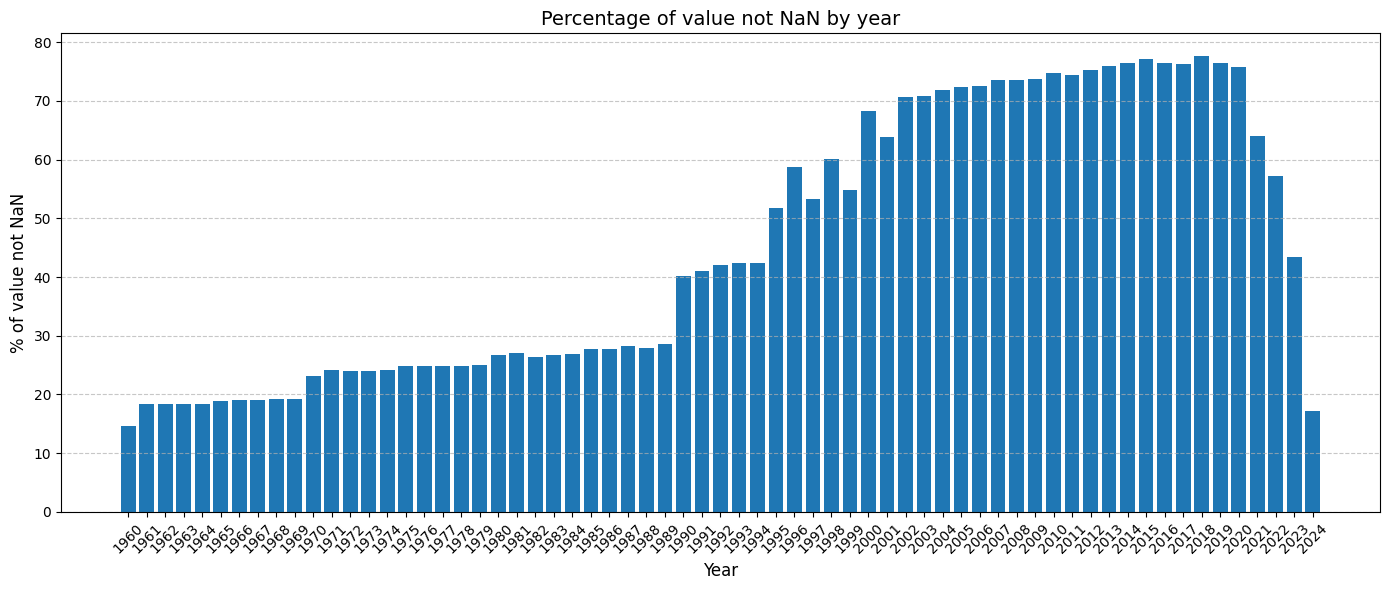

In [271]:
# Number maximal of data by Year (19260)
nb_data_by_year = nb_countries*nb_indicators

# Compute % of data
df_year = ESG_df.drop(columns=["Country Name","Indicator Name"]).notna().sum()/nb_data_by_year*100

# Show the repartition
plt.figure(figsize=(14, 6))
plt.bar(df_year.index, df_year.values)
plt.title("Percentage of value not NaN by year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Missing data by Indicator

/tmp/ipython-input-3771822346.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


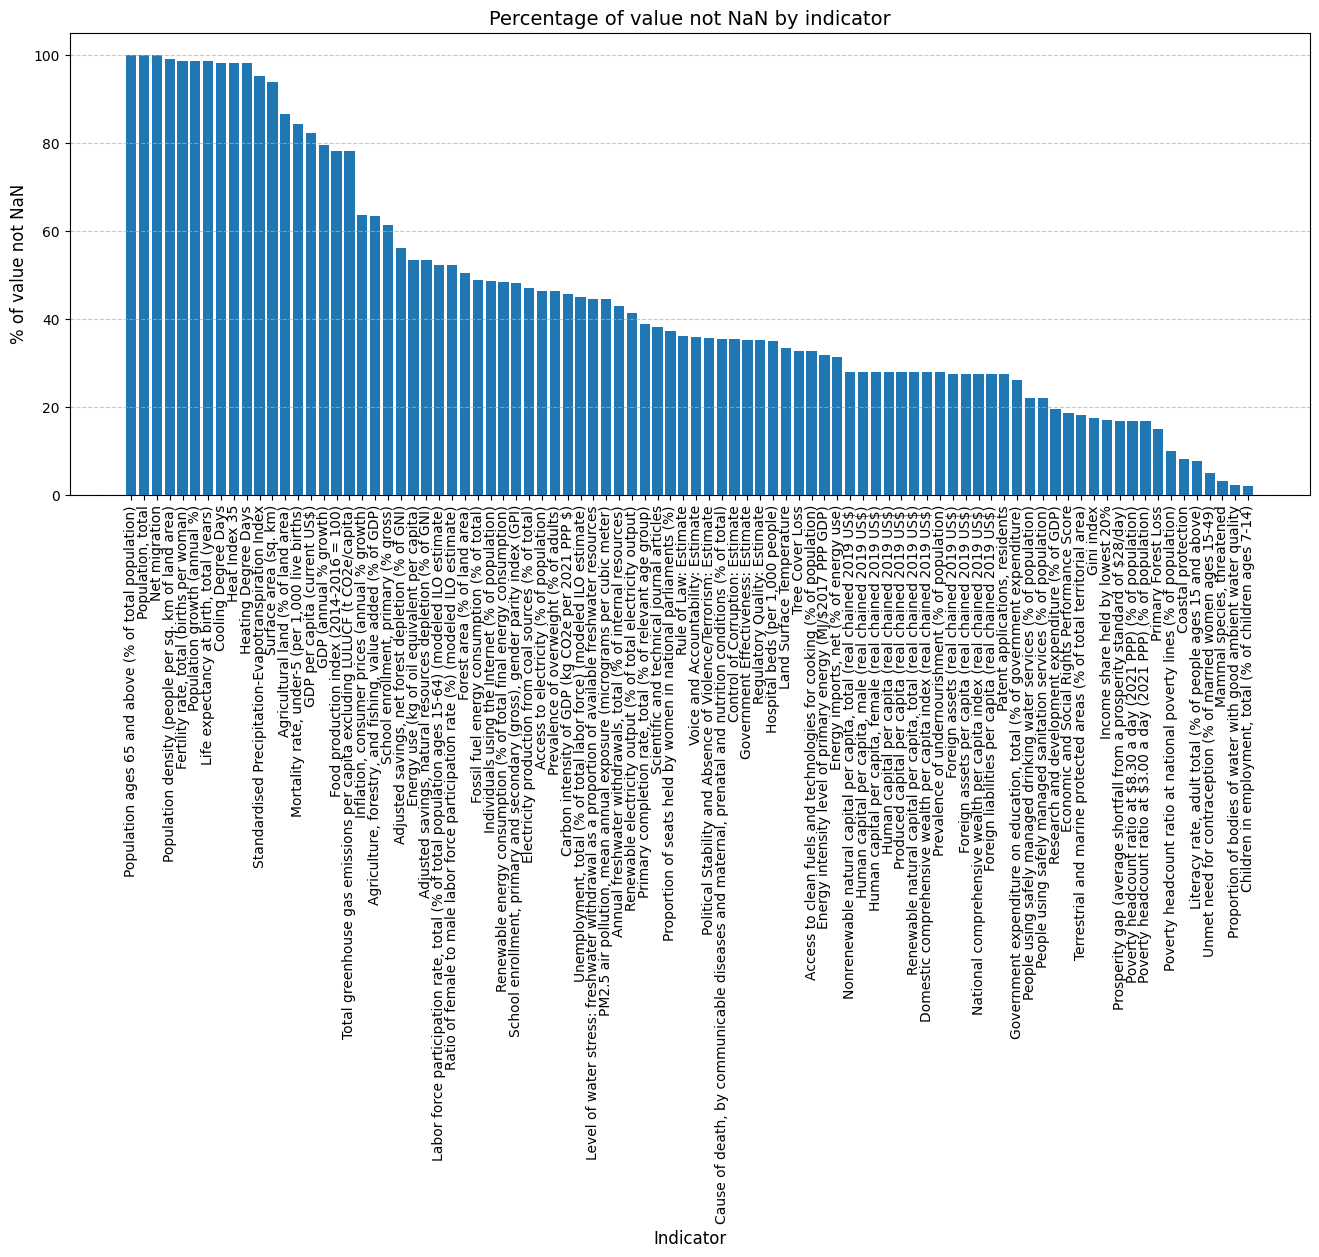

In [272]:
# Number maximal of data by Indicator (13910)
nb_data_by_indicator = nb_countries*nb_years

# Put the indicators in columns
df_ind = ESG_df_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()

# Compute % of data
df_ind = df_ind.drop(columns=["Country Name","Year"]).notna().sum()/nb_data_by_indicator*100
df_ind.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(16, 6))
plt.bar(df_ind.index, df_ind.values)
plt.title("Percentage of value not NaN by indicator", fontsize=14)
plt.xlabel("Indicator", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90,ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Missing data by Country

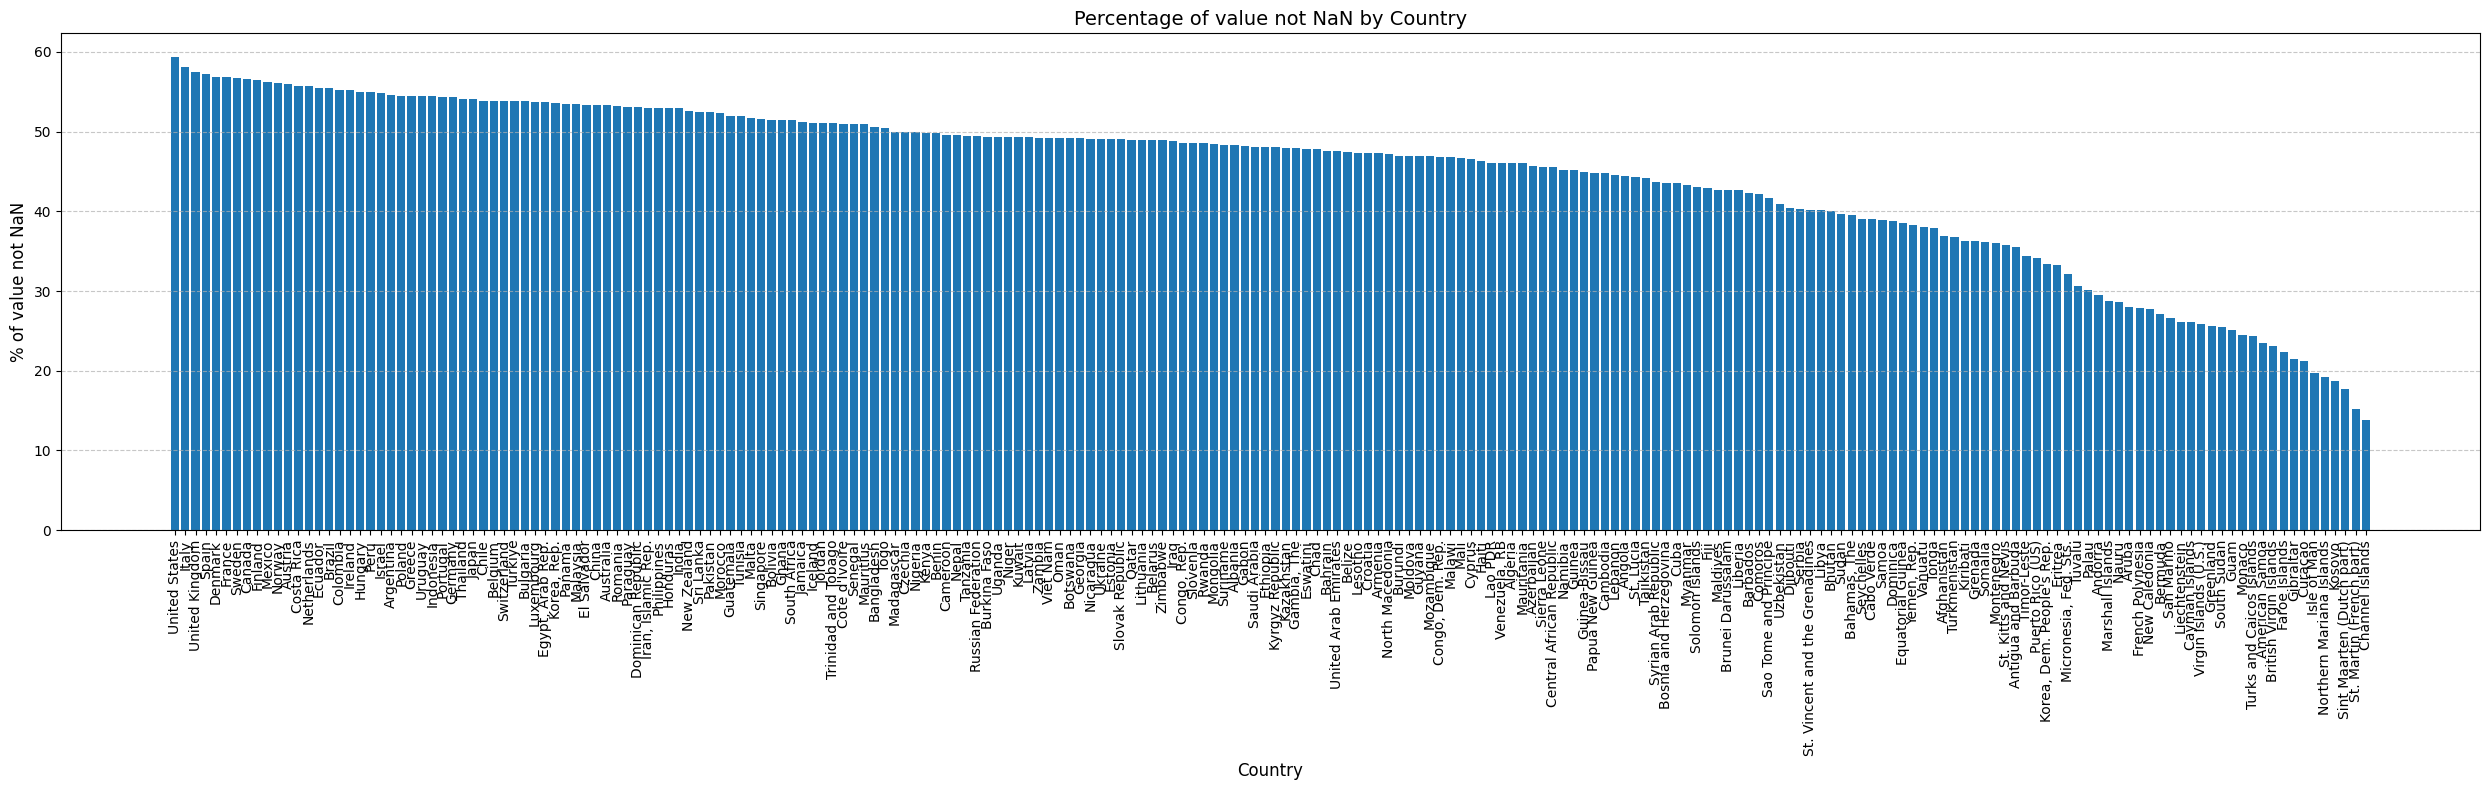

In [273]:
# Number maximal of data by Country (5850)
nb_data_by_country = nb_indicators*nb_years

# Put the Countries in columns
df_countries = ESG_df_long.pivot_table(
    index=['Indicator Name', 'Year'],
    columns='Country Name',
    values='Value'
).reset_index()

# Compute % of data
df_countries = df_countries.drop(columns=["Year","Indicator Name"]).notna().sum()/nb_data_by_country*100
df_countries.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(25, 8))
plt.bar(df_countries.index, df_countries.values)
plt.title("Percentage of value not NaN by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [274]:
print(nb_data_by_year)
print(nb_data_by_indicator)
print(nb_data_by_country)

18832
13910
5720


# Handling missing data

## Handling data by Year

Nous allons conserver uniquement les données entre 2000 et 2022 (qui ont toutes au moins 65% de données)

In [275]:
# Columns between 2000 and 2022
cols = [str(i) for i in range(2000, 2023)]

# Keep only the columns we want
ESG_df = ESG_df[["Country Name","Indicator Name"]+cols]

# New ESG_df_long
ESG_df_long = pd.melt(
    ESG_df,
    id_vars=['Country Name', 'Indicator Name'],
    var_name='Year',
    value_name='Value'
)

# New nb_years
nb_years = ESG_df.drop(columns=["Country Name","Indicator Name"]).shape[1]
print(f"Number of years: {nb_years}")

Number of years: 23


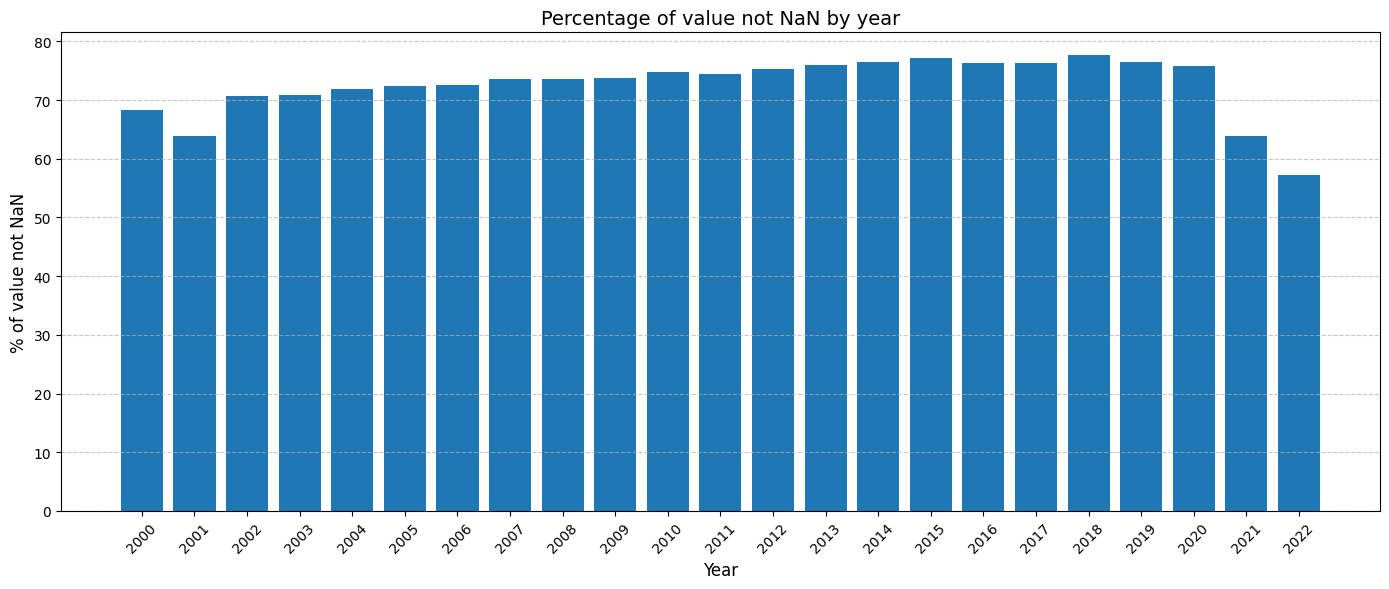

In [276]:
# Number maximal of data by Year (19260)
nb_data_by_year = nb_countries*nb_indicators

# Compute % of data
df_year = ESG_df.drop(columns=["Country Name","Indicator Name"]).notna().sum()/nb_data_by_year*100

# Show the repartition
plt.figure(figsize=(14, 6))
plt.bar(df_year.index, df_year.values)
plt.title("Percentage of value not NaN by year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Missing data by Indicator

/tmp/ipython-input-2309240540.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


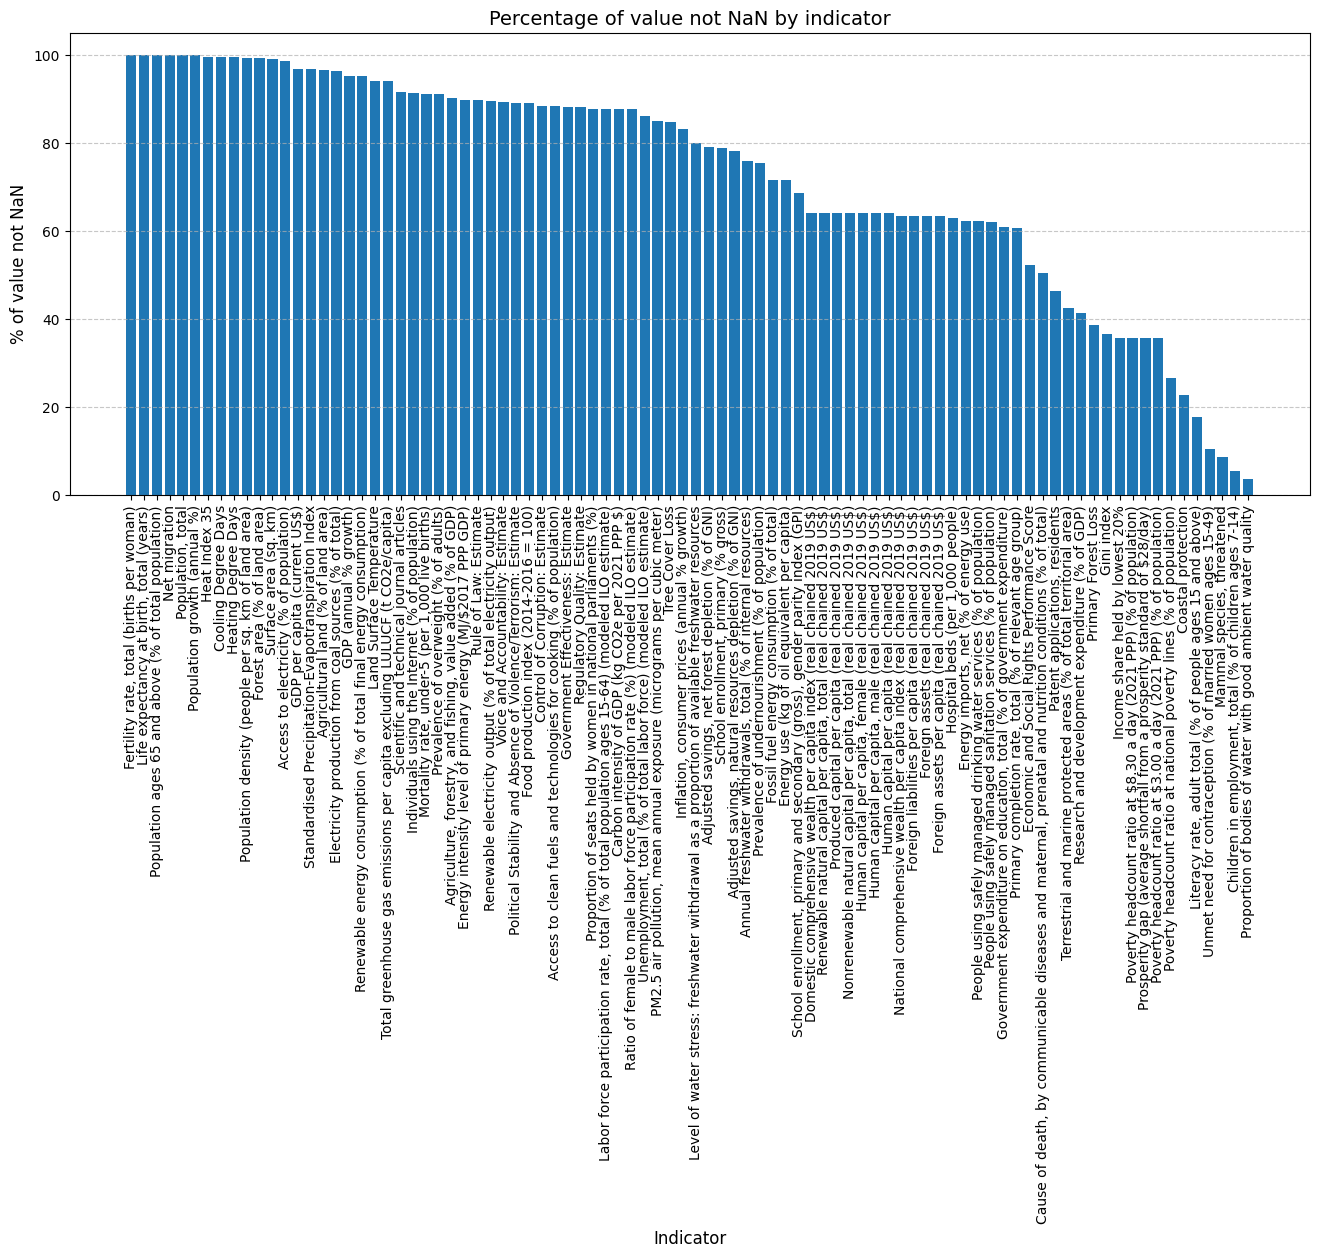

In [277]:
# Number maximal of data by Indicator (now 4922)
nb_data_by_indicator = nb_countries*nb_years

# Put the indicators in columns
df_ind = ESG_df_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()

# Compute % of data
df_ind = df_ind.drop(columns=["Country Name","Year"]).notna().sum()/nb_data_by_indicator*100
df_ind.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(16, 6))
plt.bar(df_ind.index, df_ind.values)
plt.title("Percentage of value not NaN by indicator", fontsize=14)
plt.xlabel("Indicator", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90,ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Missing data by Country

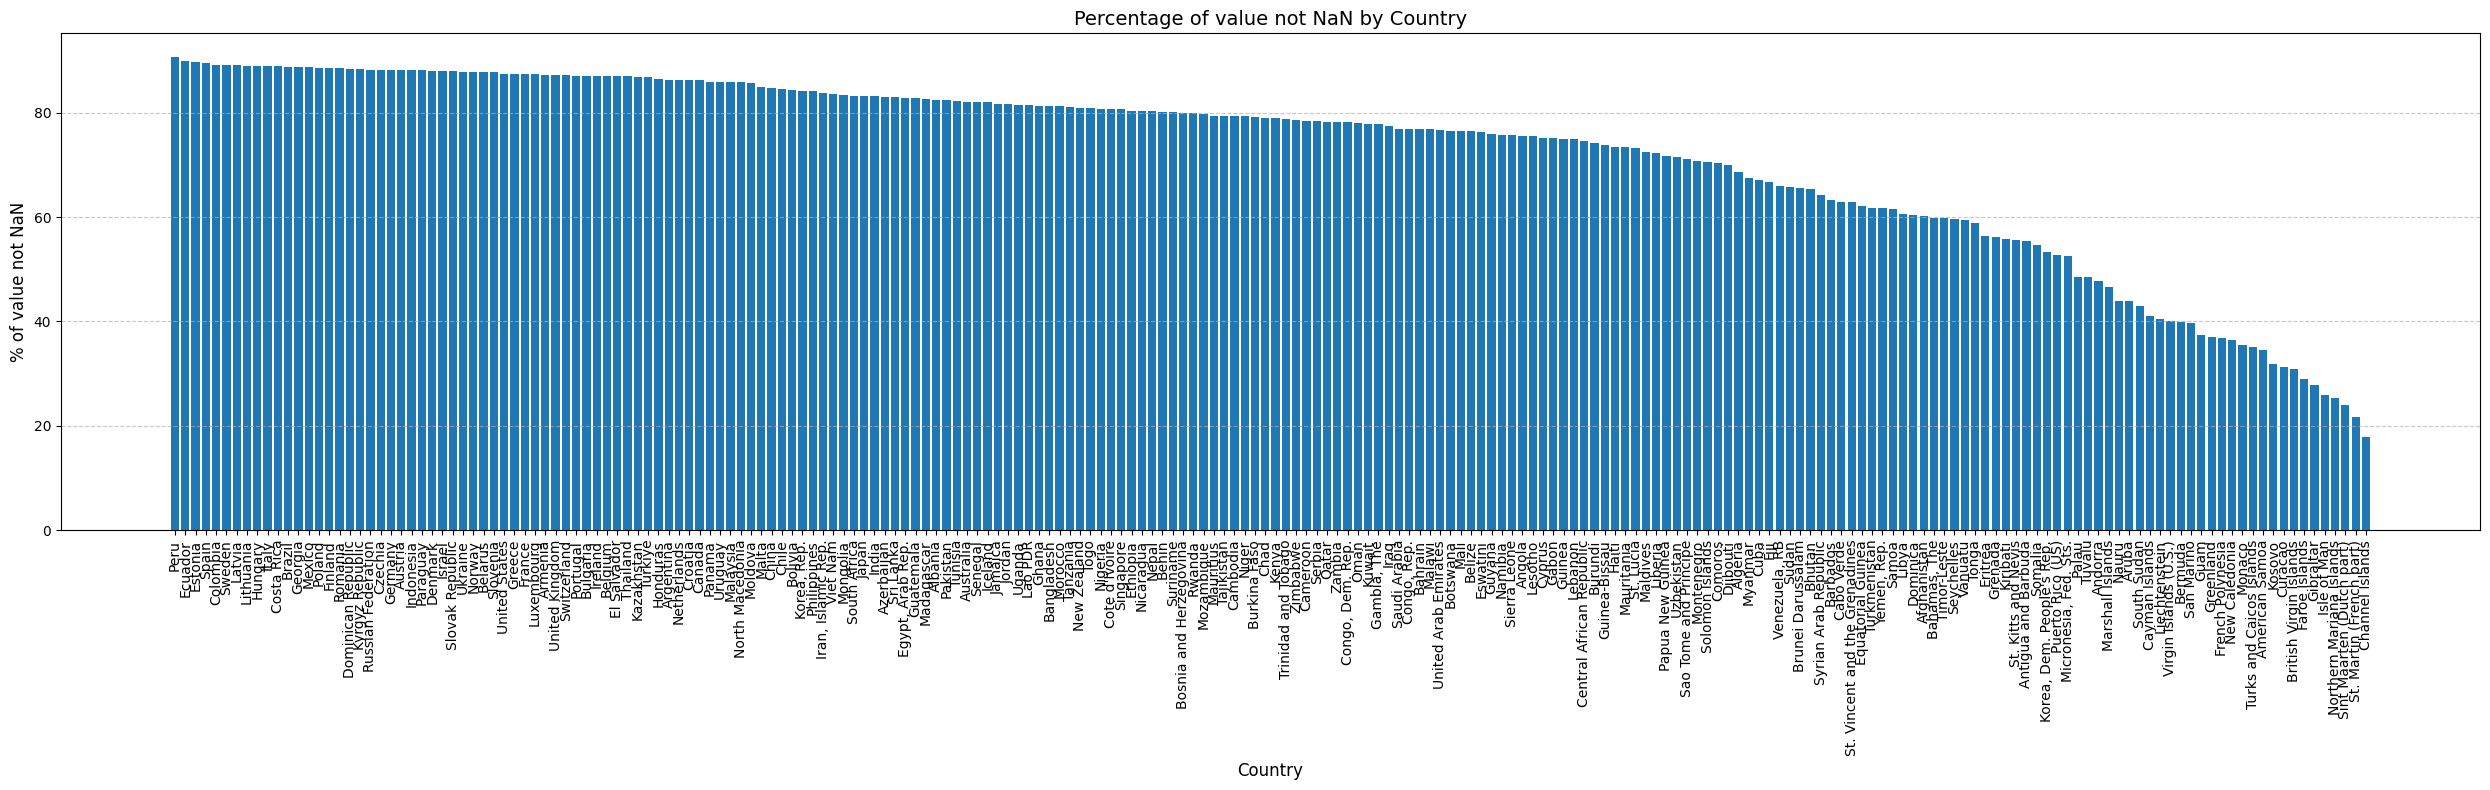

In [278]:
# Number maximal of data by Country (now 2070)
nb_data_by_country = nb_indicators*nb_years

# Put the Countries in columns
df_countries = ESG_df_long.pivot_table(
    index=['Indicator Name', 'Year'],
    columns='Country Name',
    values='Value'
).reset_index()

# Compute % of data
df_countries = df_countries.drop(columns=["Year","Indicator Name"]).notna().sum()/nb_data_by_country*100
df_countries.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(25, 8))
plt.bar(df_countries.index, df_countries.values)
plt.title("Percentage of value not NaN by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [279]:
print(nb_data_by_year)
print(nb_data_by_indicator)
print(nb_data_by_country)

18832
4922
2024


## Handling data by Indicator

Nous allons garder uniquement les indicateurs avec un % > 75%

In [280]:
# List of indicator with at least 75 % of data
list_ind = df_ind[df_ind.values >= 70].index

# Keep only the data we want
ESG_df = ESG_df[ESG_df["Indicator Name"].isin(list_ind)]

# New ESG_df_long
ESG_df_long = pd.melt(
    ESG_df,
    id_vars=['Country Name', 'Indicator Name'],
    var_name='Year',
    value_name='Value'
)

# New nb_ind
nb_indicators = ESG_df["Indicator Name"].nunique()
print(f"Number of Indicators: {nb_indicators}")

Number of Indicators: 52


/tmp/ipython-input-2309240540.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


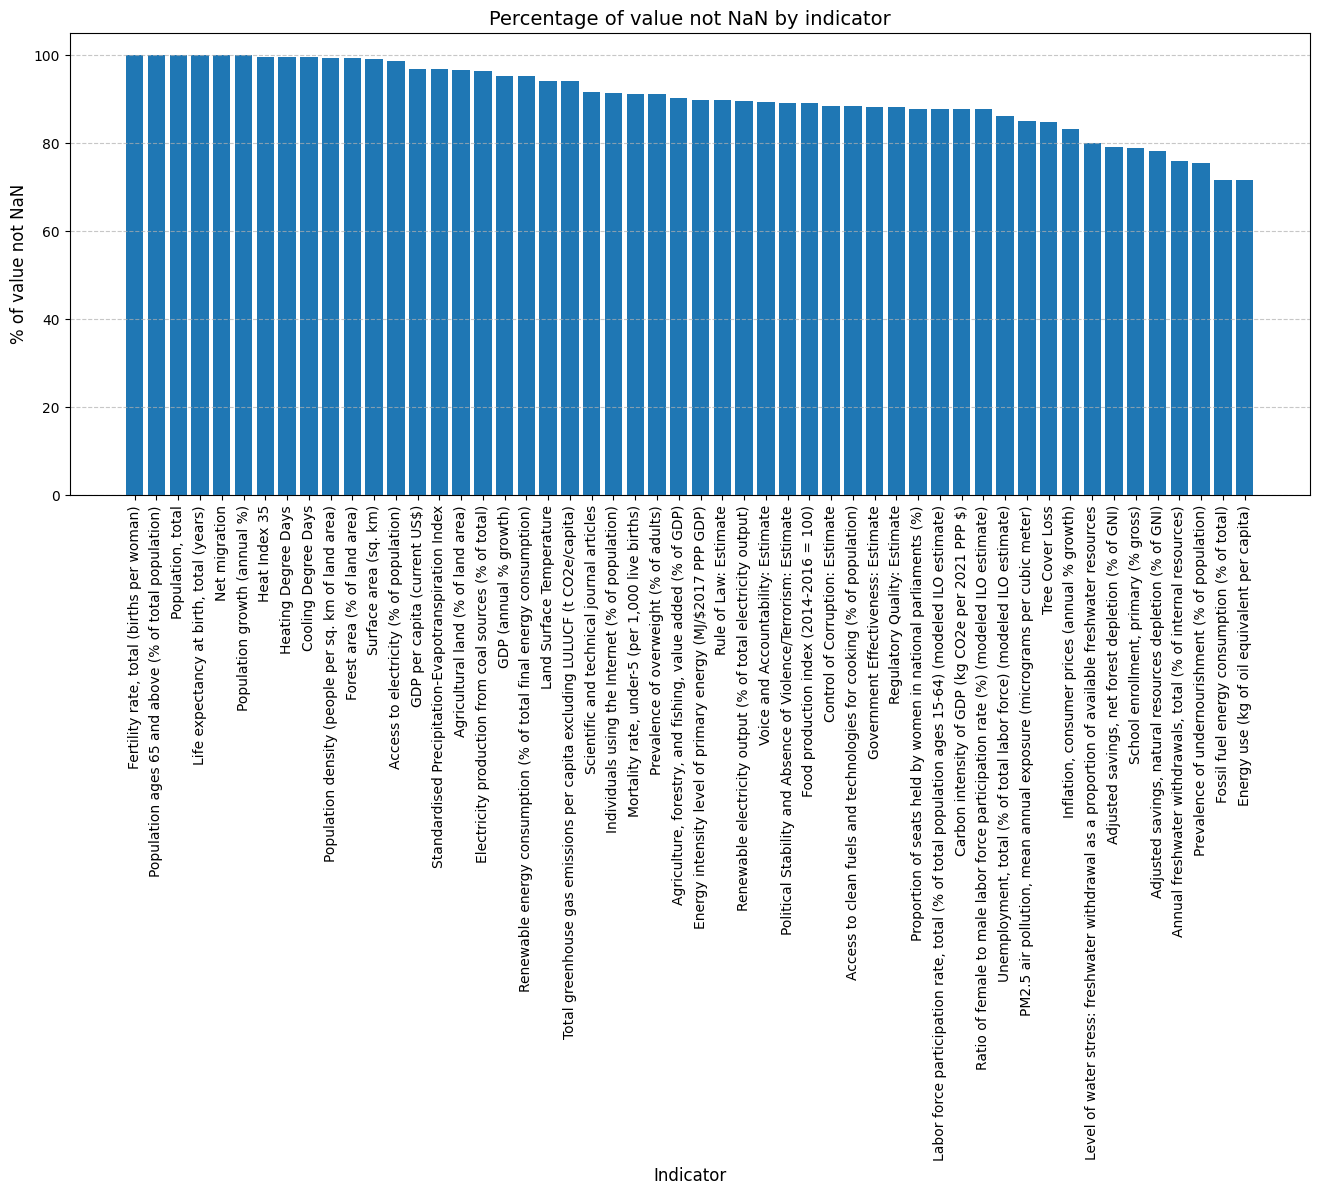

In [281]:
# Number maximal of data by Indicator (now 4922)
nb_data_by_indicator = nb_countries*nb_years

# Put the indicators in columns
df_ind = ESG_df_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()

# Compute % of data
df_ind = df_ind.drop(columns=["Country Name","Year"]).notna().sum()/nb_data_by_indicator*100
df_ind.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(16, 6))
plt.bar(df_ind.index, df_ind.values)
plt.title("Percentage of value not NaN by indicator", fontsize=14)
plt.xlabel("Indicator", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90,ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Missing data by Year

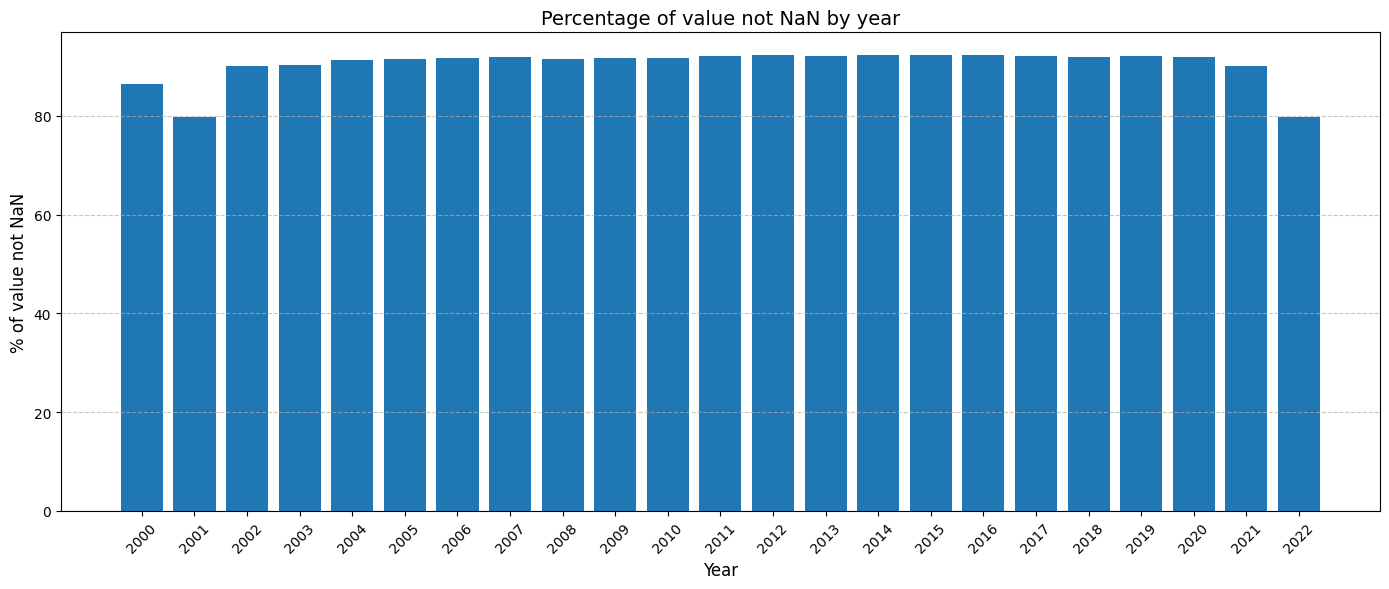

In [282]:
# Number maximal of data by Year (now 10914)
nb_data_by_year = nb_countries*nb_indicators

# Compute % of data
df_year = ESG_df.drop(columns=["Country Name","Indicator Name"]).notna().sum()/nb_data_by_year*100

# Show the repartition
plt.figure(figsize=(14, 6))
plt.bar(df_year.index, df_year.values)
plt.title("Percentage of value not NaN by year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Missing data by Country

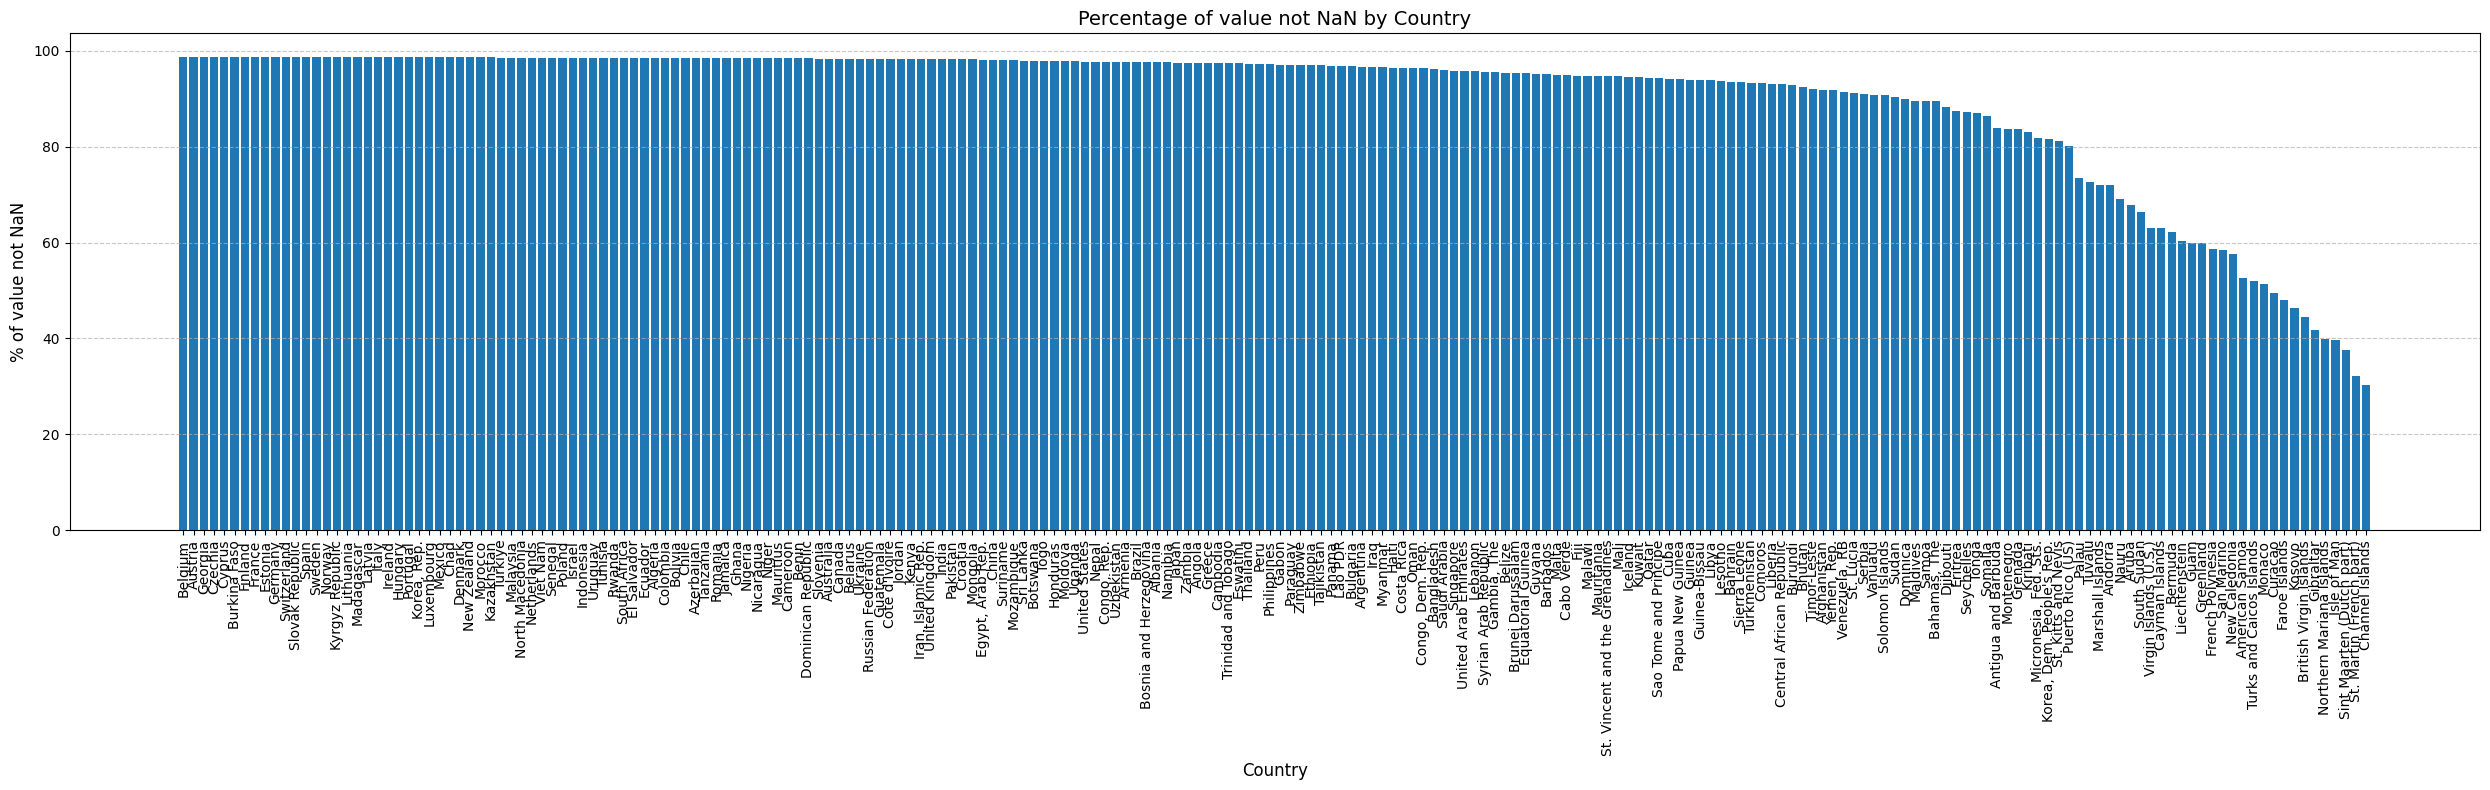

In [283]:
# Number maximal of data by Country (now 1173)
nb_data_by_country = nb_indicators*nb_years

# Put the Countries in columns
df_countries = ESG_df_long.pivot_table(
    index=['Indicator Name', 'Year'],
    columns='Country Name',
    values='Value'
).reset_index()

# Compute % of data
df_countries = df_countries.drop(columns=["Year","Indicator Name"]).notna().sum()/nb_data_by_country*100
df_countries.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(25, 8))
plt.bar(df_countries.index, df_countries.values)
plt.title("Percentage of value not NaN by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [284]:
print(nb_data_by_year)
print(nb_data_by_indicator)
print(nb_data_by_country)

11128
4922
1196


## Handling data by Country

On va conserver uniquement les pays avec 80% de données

In [285]:
# List of Country with at least 80 % of data
list_country = df_countries[df_countries.values >= 80].index

# Keep only the data we want
ESG_df = ESG_df[ESG_df["Country Name"].isin(list_country)]

# New ESG_df_long
ESG_df_long = pd.melt(
    ESG_df,
    id_vars=['Country Name', 'Indicator Name'],
    var_name='Year',
    value_name='Value'
)

# New nb_countries
nb_countries = ESG_df["Country Name"].nunique()
print(f"Number of countries: {nb_countries}")

Number of countries: 185


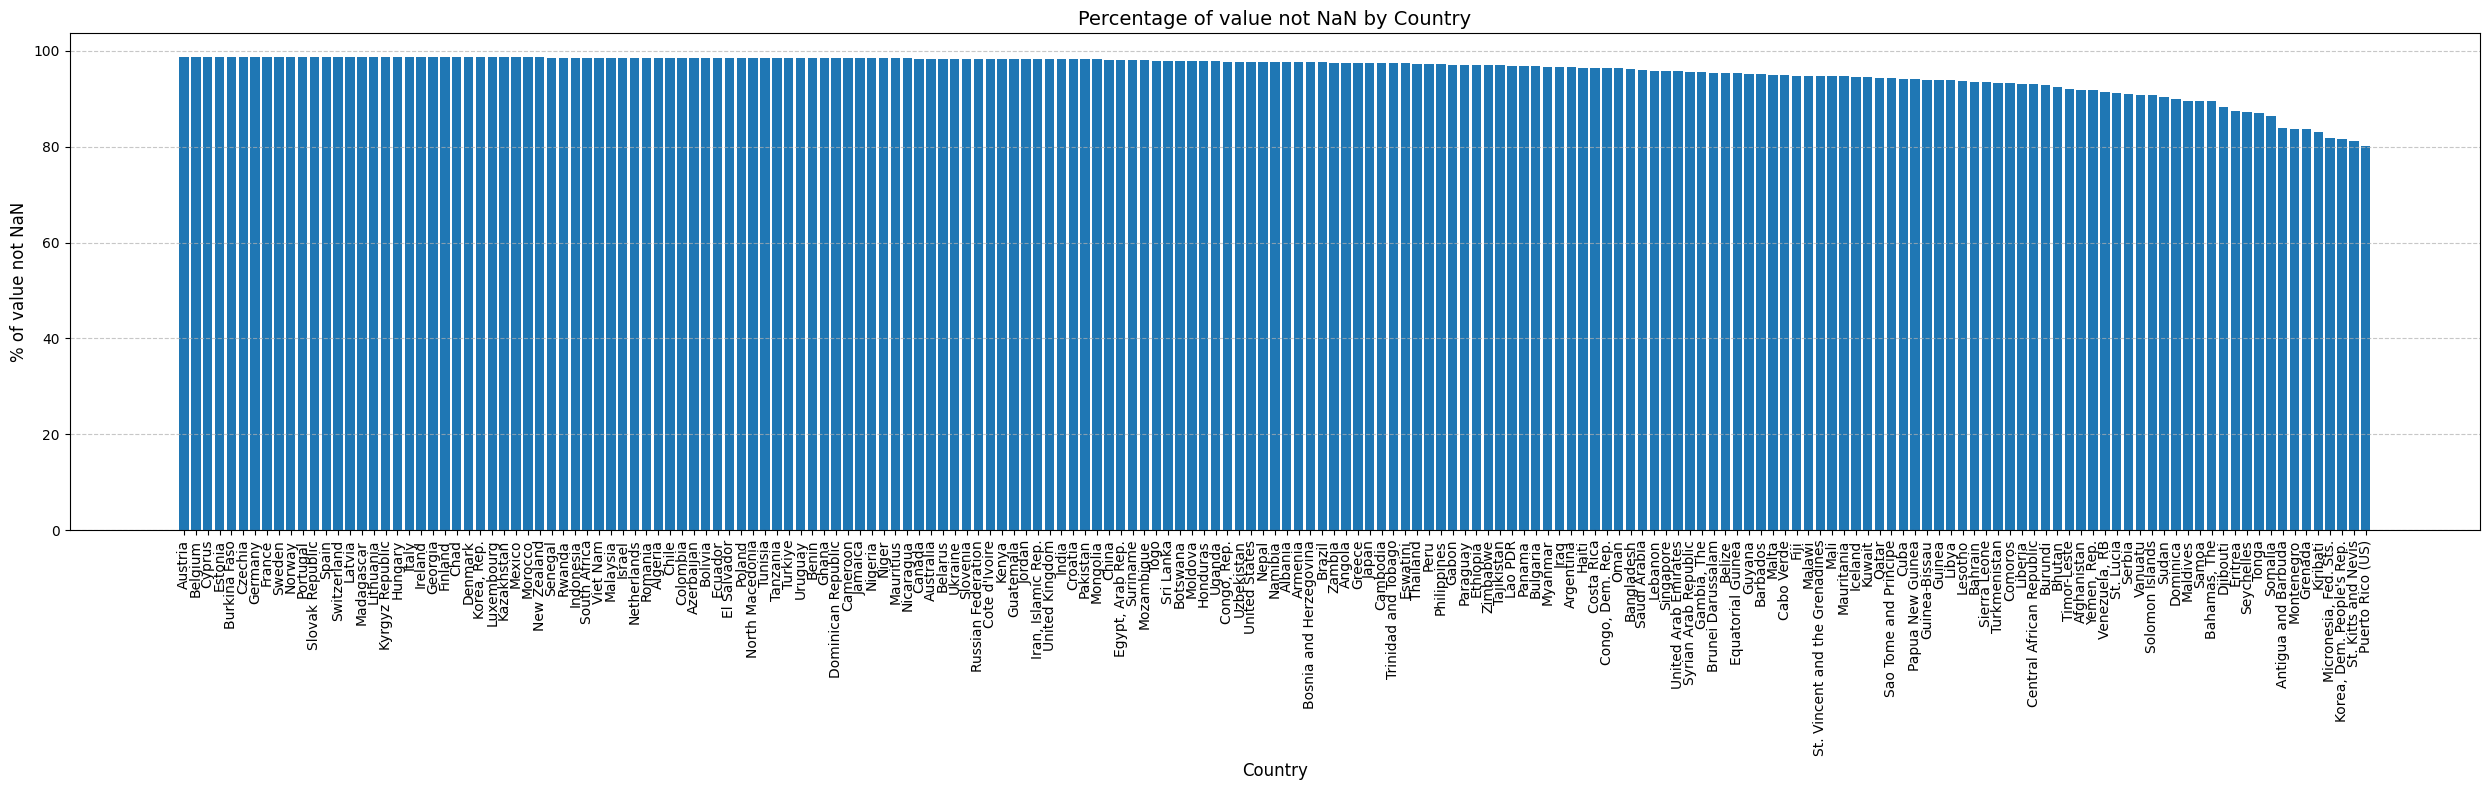

In [286]:
# Number maximal of data by Country (now 1173)
nb_data_by_country = nb_indicators*nb_years

# Put the Countries in columns
df_countries = ESG_df_long.pivot_table(
    index=['Indicator Name', 'Year'],
    columns='Country Name',
    values='Value'
).reset_index()

# Compute % of data
df_countries = df_countries.drop(columns=["Year","Indicator Name"]).notna().sum()/nb_data_by_country*100
df_countries.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(25, 8))
plt.bar(df_countries.index, df_countries.values)
plt.title("Percentage of value not NaN by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Missing data by Year

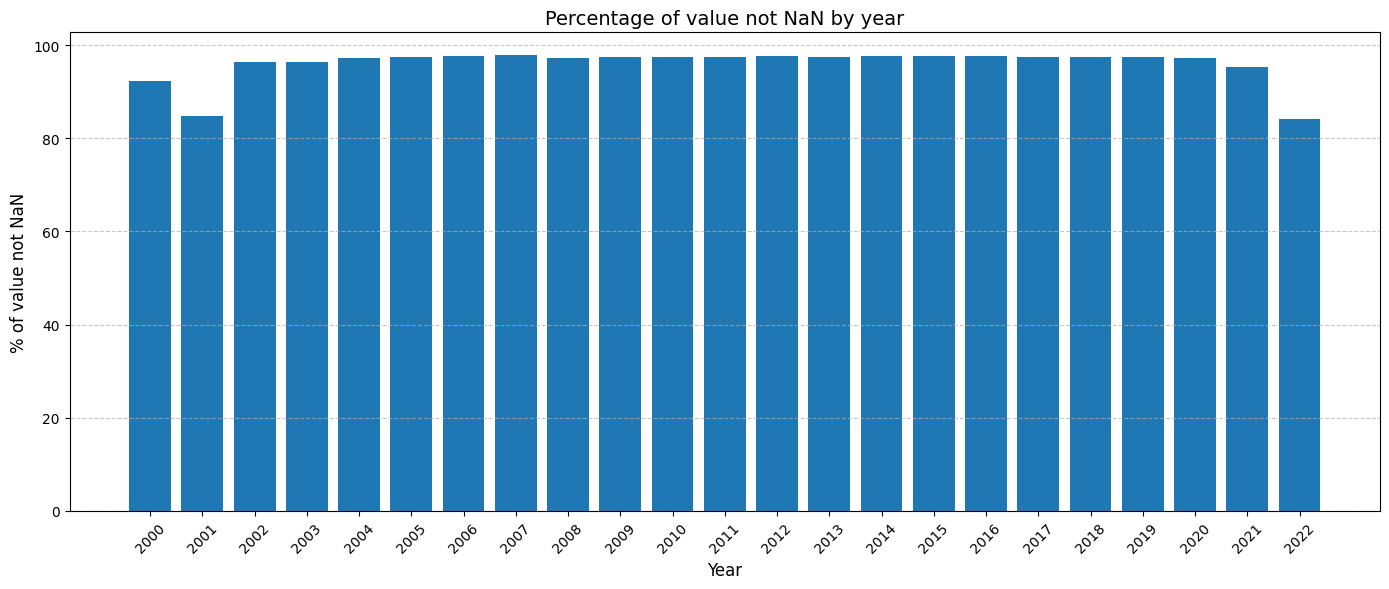

In [287]:
# Number maximal of data by Year (now 9435)
nb_data_by_year = nb_countries*nb_indicators

# Compute % of data
df_year = ESG_df.drop(columns=["Country Name","Indicator Name"]).notna().sum()/nb_data_by_year*100

# Show the repartition
plt.figure(figsize=(14, 6))
plt.bar(df_year.index, df_year.values)
plt.title("Percentage of value not NaN by year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Missing data by Indicator

/tmp/ipython-input-1492747031.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


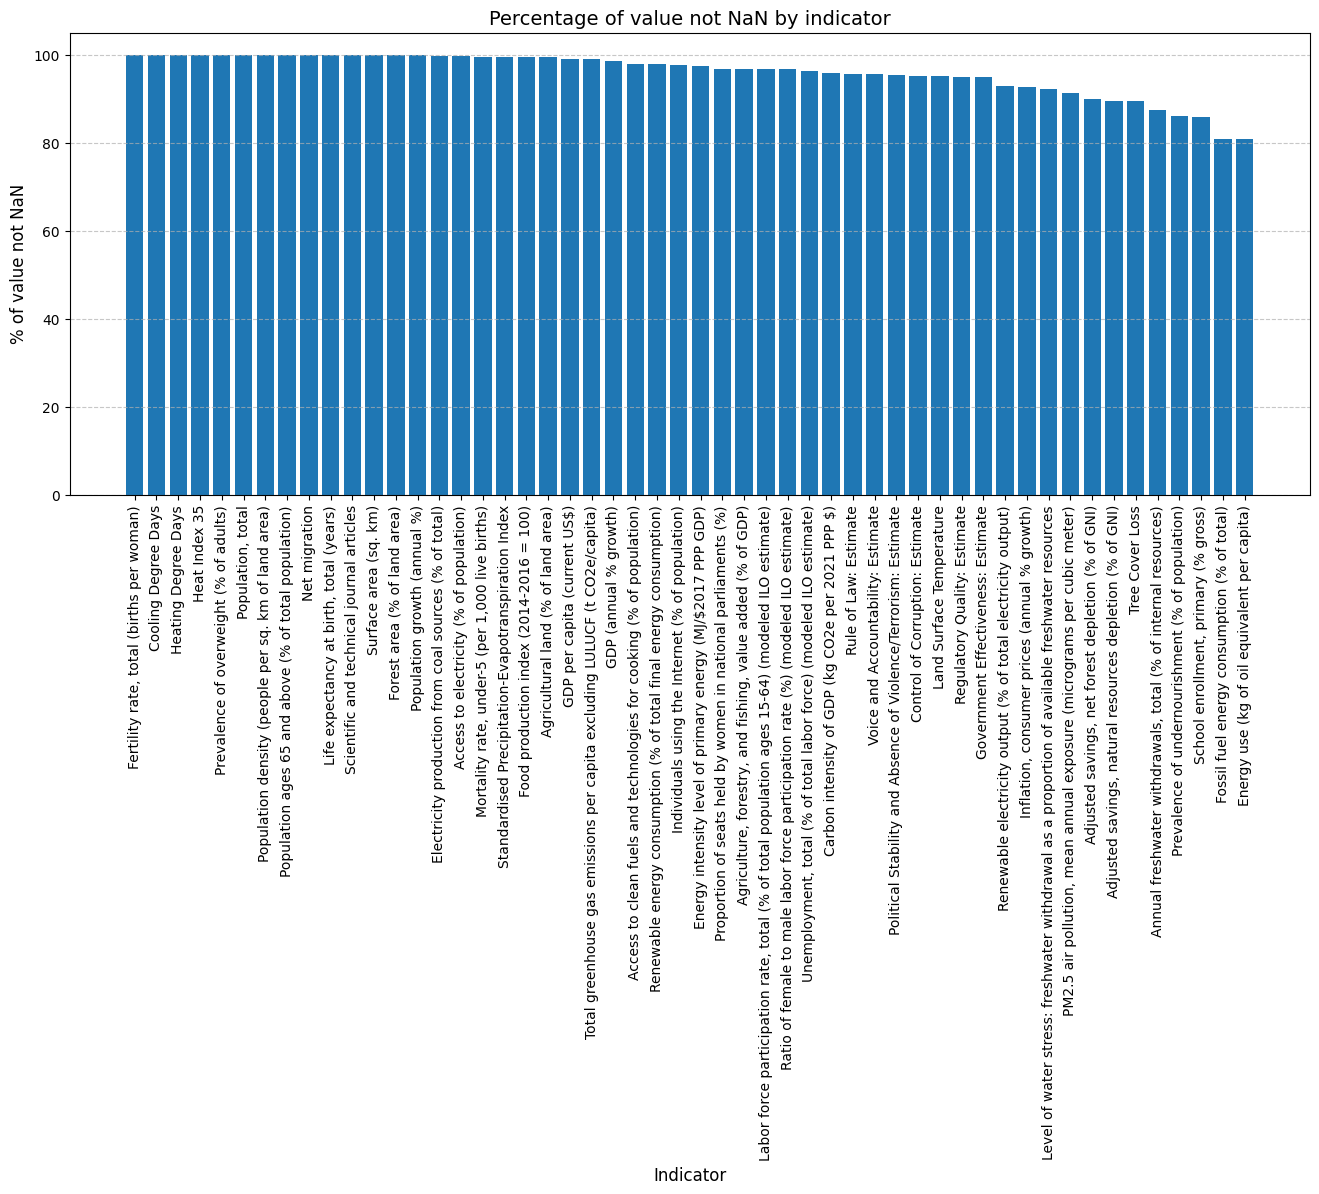

In [288]:
# Number maximal of data by Indicator (now 4255)
nb_data_by_indicator = nb_countries*nb_years

# Put the indicators in columns
df_ind = ESG_df_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()

# Compute % of data
df_ind = df_ind.drop(columns=["Country Name","Year"]).notna().sum()/nb_data_by_indicator*100
df_ind.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(16, 6))
plt.bar(df_ind.index, df_ind.values)
plt.title("Percentage of value not NaN by indicator", fontsize=14)
plt.xlabel("Indicator", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90,ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [289]:
print(nb_data_by_year)
print(nb_data_by_indicator)
print(nb_data_by_country)

9620
4255
1196


In [290]:
 # % de valeurs manquantes sur l'ensemble du dataset

(ESG_df.drop(columns=["Country Name","Indicator Name"]).count()/ESG_df.shape[0]*100).mean()

np.float64(95.9418783331827)

# Data Imputation

## Vérifier données imputables

In [291]:
# We put the indicators in columns
ESG_df_ByInd = ESG_df_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()
ESG_df_ByInd.sort_values(by=["Country Name","Year"], inplace=True)

# keep a copy
ESG_df_ByInd_copy = ESG_df_ByInd.copy()

In [292]:
# Compute le % de valeur présente pour chaque paire indicateur/pays
missing_data = ESG_df_ByInd.drop(columns=["Year"]).groupby("Country Name").count().reset_index()
cols = missing_data.columns[1:]
missing_data[cols] = missing_data[cols]/nb_years*100

# Récuperer les données à moins de 78% -> 5 valeurs manquantes max
seuil = 78
mask = missing_data.drop(columns=["Country Name"]).lt(seuil)
rows, cols = np.where(mask)

# Construire un DataFrame avec les résultats
missing_behind_seuil = pd.DataFrame({
    "Country Name": missing_data.iloc[rows]["Country Name"].values,
    "Indicator Name": mask.columns[cols],
    "Value": missing_data.drop(columns=["Country Name"]).values[rows, cols]
})

missing_behind_seuil.head()

Country Name                                     Indicator Name      Value
0  Afghanistan  Adjusted savings, natural resources depletion ...  56.521739
1  Afghanistan  Adjusted savings, net forest depletion (% of GNI)  56.521739
2  Afghanistan       Energy use (kg of oil equivalent per capita)   0.000000
3  Afghanistan        Fossil fuel energy consumption (% of total)   0.000000
4      Albania  Renewable electricity output (% of total elect...  47.826087

In [293]:
# Compute most problematic country
problematic_country = missing_behind_seuil.drop(columns=["Value"]).groupby(["Country Name"]).count().reset_index().sort_values(by="Indicator Name", ascending=False)
print(f"Nombre de pays avec données non imputables : {len(problematic_country)}")
problematic_country.head()

Nombre de pays avec données non imputables : 102


Country Name  Indicator Name
59                 Montenegro              12
45  Korea, Dem. People's Rep.              10
81        St. Kitts and Nevis              10
69           Puerto Rico (US)              10
3         Antigua and Barbuda               9

In [294]:
# Compute most problematic indicator
problematic_ind = missing_behind_seuil.drop(columns=["Value"]).groupby(["Indicator Name"]).count().reset_index().sort_values(by="Country Name", ascending=False)
print(f"Nombre d'indicateurs avec données non imputables : {len(problematic_ind)}")
problematic_ind.head()

Nombre d'indicateurs avec données non imputables : 30


Indicator Name  Country Name
11        Fossil fuel energy consumption (% of total)            40
9        Energy use (kg of oil equivalent per capita)            40
25               School enrollment, primary (% gross)            39
6   Annual freshwater withdrawals, total (% of int...            24
18  Level of water stress: freshwater withdrawal a...            21

In [295]:
# On veut garder celui-là
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Energy use (kg of oil equivalent per capita)"]['Country Name'].unique()

array(['Afghanistan', 'Antigua and Barbuda', 'Bahamas, The', 'Barbados',
       'Belize', 'Bhutan', 'Burundi', 'Cabo Verde',
       'Central African Republic', 'Comoros', 'Djibouti', 'Dominica',
       'Fiji', 'Gambia, The', 'Grenada', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Kiribati', 'Lesotho', 'Liberia', 'Malawi', 'Maldives',
       'Mali', 'Mauritania', 'Micronesia, Fed. Sts.', 'Papua New Guinea',
       'Puerto Rico (US)', 'Samoa', 'Sao Tome and Principe', 'Seychelles',
       'Sierra Leone', 'Solomon Islands', 'Somalia',
       'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Timor-Leste', 'Tonga',
       'Vanuatu'], dtype=object)

In [296]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Access to clean fuels and technologies for cooking (% of population)"]['Country Name'].unique()

array(['Bulgaria', 'Lebanon', 'Libya', 'Puerto Rico (US)'], dtype=object)

In [297]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Agriculture, forestry, and fishing, value added (% of GDP)"]['Country Name'].unique()

array(['Armenia', 'Bahrain', 'Central African Republic', 'Djibouti',
       'Equatorial Guinea', 'Eritrea', "Korea, Dem. People's Rep.",
       'Sao Tome and Principe', 'Somalia', 'St. Lucia', 'Venezuela, RB'],
      dtype=object)

In [298]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Prevalence of undernourishment (% of population)"]['Country Name'].unique()

array(['Antigua and Barbuda', 'Bahamas, The', 'Bahrain', 'Bhutan',
       'Brunei Darussalam', 'Burundi', 'Equatorial Guinea', 'Eritrea',
       'Grenada', 'Lesotho', 'Maldives', 'Micronesia, Fed. Sts.',
       'Puerto Rico (US)', 'Qatar', 'Singapore', 'St. Kitts and Nevis',
       'St. Lucia', 'Sudan', 'Tonga'], dtype=object)

In [299]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Carbon intensity of GDP (kg CO2e per 2021 PPP $)"]['Country Name'].unique()

array(['Cuba', 'Djibouti', 'Eritrea', "Korea, Dem. People's Rep.",
       'Montenegro', 'Serbia', 'Venezuela, RB', 'Yemen, Rep.'],
      dtype=object)

In [300]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Individuals using the Internet (% of population)"]['Country Name'].unique()

array(["Korea, Dem. People's Rep.", 'Sri Lanka', 'Sudan'], dtype=object)

In [301]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Adjusted savings, net forest depletion (% of GNI)"]['Country Name'].unique()

array(['Afghanistan', 'Antigua and Barbuda', 'Eritrea', 'Greece',
       'Grenada', 'Iceland', "Korea, Dem. People's Rep.", 'Malta',
       'Montenegro', 'Puerto Rico (US)', 'Serbia', 'Somalia',
       'St. Kitts and Nevis', 'Sudan', 'Turkmenistan', 'Venezuela, RB'],
      dtype=object)

In [302]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Tree Cover Loss"]['Country Name'].unique()

array(['Bahrain', 'Cabo Verde', 'Djibouti', 'Iceland', 'Kiribati',
       'Kuwait', 'Oman', 'Qatar', 'Samoa', 'Saudi Arabia', 'Tonga',
       'United Arab Emirates', 'Yemen, Rep.'], dtype=object)

In [303]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Energy intensity level of primary energy (MJ/$2017 PPP GDP)"]['Country Name'].unique()

array(['Syrian Arab Republic'], dtype=object)

In [304]:
missing_behind_seuil[missing_behind_seuil["Indicator Name"] == "Proportion of seats held by women in national parliaments (%)"]['Country Name'].unique()

array(['Brunei Darussalam', 'Fiji', 'Montenegro', 'Myanmar',
       'Puerto Rico (US)', 'Qatar', 'Serbia'], dtype=object)

## Eliminer données non imputable

On a 102 pays et 31 indicateurs avec des données non imputables. On va éliminer les indicateurs et pays les plus problématiques (choisi de manière un peu arbitraire en essayant de conserver les indicateurs intéréssants, surtout Energy use (kg of oil equivalent per capita) le plus corrélé) :

----
Garder energy use :
['Afghanistan', 'Antigua and Barbuda', 'Bahamas, The', 'Barbados',
       'Belize', 'Bhutan', 'Burundi', 'Cabo Verde',
       'Central African Republic', 'Comoros', 'Djibouti', 'Dominica',
       'Fiji', 'Gambia, The', 'Grenada', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Kiribati', 'Lesotho', 'Liberia', 'Malawi', 'Maldives',
       'Mali', 'Mauritania', 'Micronesia, Fed. Sts.', 'Papua New Guinea',
       'Puerto Rico (US)', 'Samoa', 'Sao Tome and Principe', 'Seychelles',
       'Sierra Leone', 'Solomon Islands', 'Somalia',
       'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Timor-Leste', 'Tonga',
       'Vanuatu']
---
Garder Access to clean fuels and technologies for cooking (% of population) :
['Bulgaria', 'Lebanon', 'Libya']

---
Garder Agriculture, forestry, and fishing, value added (% of GDP)

['Armenia', 'Bahrain', 'Equatorial Guinea', 'Eritrea',
       "Korea, Dem. People's Rep.", 'Venezuela, RB']


----
garder Prevalence of undernourishment (% of population):

['Brunei Darussalam', 'Qatar', 'Singapore']

----

garder Carbon intensity of GDP (kg CO2e per 2021 PPP $)

['Cuba', 'Yemen, Rep.']

---

Internet:
Sri Lanka

----

net forest depletion

['Greece', 'Iceland', 'Malta', 'Turkmenistan']
['Montenegro', 'Serbia', 'Sudan']

---

Tree cover loss

['Kuwait', 'Oman', 'Saudi Arabia', 'United Arab Emirates']

---

energy intensity
Syrian Arab Republic

---

----
Eliminer ces indicateurs (bcp pays manquants et/ou peu de correlation)
['School enrollment, primary (% gross)',
       'Renewable electricity output (% of total electricity output)',
       'Annual freshwater withdrawals, total (% of internal resources)',
       'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
       'Inflation, consumer prices (annual % growth)',
       'Proportion of seats held by women in national parliaments (%)]

In [305]:
countries_to_erase = ['Afghanistan', 'Antigua and Barbuda', 'Bahamas, The', 'Barbados',
       'Belize', 'Bhutan', 'Burundi', 'Cabo Verde',
       'Central African Republic', 'Comoros', 'Djibouti', 'Dominica',
       'Fiji', 'Gambia, The', 'Grenada', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Kiribati', 'Lesotho', 'Liberia', 'Malawi', 'Maldives',
       'Mali', 'Mauritania', 'Micronesia, Fed. Sts.', 'Papua New Guinea',
       'Puerto Rico (US)', 'Samoa', 'Sao Tome and Principe', 'Seychelles',
       'Sierra Leone', 'Solomon Islands', 'Somalia',
       'St. Kitts and Nevis', 'St. Lucia',
       'St. Vincent and the Grenadines', 'Timor-Leste', 'Tonga',
       'Vanuatu', 'Bulgaria', 'Lebanon', 'Libya','Armenia', 'Bahrain', 'Equatorial Guinea', 'Eritrea',
       "Korea, Dem. People's Rep.", 'Venezuela, RB','Brunei Darussalam', 'Qatar', 'Singapore', 'Cuba', 'Yemen, Rep.','Sri Lanka',
       'Greece', 'Iceland', 'Malta', 'Turkmenistan','Kuwait', 'Oman', 'Saudi Arabia', 'United Arab Emirates','Montenegro', 'Serbia', 'Sudan',
       'Syrian Arab Republic']


indicators_to_erase =['School enrollment, primary (% gross)',
       'Renewable electricity output (% of total electricity output)',
       'Annual freshwater withdrawals, total (% of internal resources)',
       'Level of water stress: freshwater withdrawal as a proportion of available freshwater resources',
       'Inflation, consumer prices (annual % growth)',
       'Proportion of seats held by women in national parliaments (%)']

ESG_df_ByInd = ESG_df_ByInd[~ESG_df_ByInd["Country Name"].isin(countries_to_erase)]
ESG_df_ByInd.drop(columns=indicators_to_erase, inplace=True, errors='ignore')

Vérifier les résultat :

In [306]:
# Compute le % de valeur présente pour chaque paire indicateur/pays
missing_data = ESG_df_ByInd.drop(columns=["Year"]).groupby("Country Name").count().reset_index()
cols = missing_data.columns[1:]
missing_data[cols] = missing_data[cols]/nb_years*100

# Récuperer les données à moins de 78% -> 5 valeurs manquantes max
seuil = 78
mask = missing_data.drop(columns=["Country Name"]).lt(seuil)
rows, cols = np.where(mask)

# Construire un DataFrame avec les résultats
missing_behind_seuil = pd.DataFrame({
    "Country Name": missing_data.iloc[rows]["Country Name"].values,
    "Indicator Name": mask.columns[cols],
    "Value": missing_data.drop(columns=["Country Name"]).values[rows, cols]
})

missing_behind_seuil.head()

Empty DataFrame
Columns: [Country Name, Indicator Name, Value]
Index: []

In [307]:
# Compute most problematic country
problematic_country = missing_behind_seuil.drop(columns=["Value"]).groupby(["Country Name"]).count().reset_index().sort_values(by="Indicator Name", ascending=False)
print(f"Nombre de pays avec données non imputables : {len(problematic_country)}")
problematic_country.head()

Nombre de pays avec données non imputables : 0


Empty DataFrame
Columns: [Country Name, Indicator Name]
Index: []

In [308]:
# Compute most problematic indicator
problematic_ind = missing_behind_seuil.drop(columns=["Value"]).groupby(["Indicator Name"]).count().reset_index().sort_values(by="Country Name", ascending=False)
print(f"Nombre d'indicateurs avec données non imputables : {len(problematic_ind)}")
problematic_ind.head()

Nombre d'indicateurs avec données non imputables : 0


Empty DataFrame
Columns: [Indicator Name, Country Name]
Index: []

In [309]:
nb_countries = ESG_df_ByInd['Country Name'].nunique()
nb_countries

118

In [310]:
nb_indicators = len(ESG_df_ByInd.columns)-2
nb_indicators

46

In [311]:
 # % de valeurs manquantes sur l'ensemble du dataset

(ESG_df_ByInd.drop(columns=["Country Name","Year"]).count()/ESG_df_ByInd.shape[0]*100).mean()

np.float64(98.63189260196725)

##Imputer données

### < 10% de valeurs manquantes

In [312]:
# Compute le % de valeur présente pour chaque paire indicateur/pays
missing_data = ESG_df_ByInd.drop(columns=["Year"]).groupby("Country Name").count().reset_index()
cols = missing_data.columns[1:]
missing_data[cols] = missing_data[cols]/nb_years*100

# Récuperer les données à moins de 100% -> (à completer)
mask = missing_data.drop(columns=["Country Name"]).lt(100)
rows, cols = np.where(mask)

# Construire un DataFrame avec les résultats
missing_data = pd.DataFrame({
    "Country Name": missing_data.iloc[rows]["Country Name"].values,
    "Indicator Name": mask.columns[cols],
    "Value": missing_data.drop(columns=["Country Name"]).values[rows, cols]
})
missing_data.groupby(['Value']).count()

Country Name  Indicator Name
Value                                  
78.260870             2               2
82.608696             3               3
86.956522             2               2
91.304348           123             123
95.652174          1434            1434

In [313]:
import numpy as np
from scipy import interpolate

# On interpole que les pays avec 1 ou 2 valeurs manquantes (< 10%)
to_interpolate = set(
    missing_data.loc[missing_data['Value'] > 90, ['Country Name', 'Indicator Name']]
    .itertuples(index=False, name=None)
)

# Interpoler pour chaque indicateur pour un pays
def interpolate_selected(group):
    for ind in group.columns.difference(['Country Name']):

        # Vérifier si ce pays/indicateur est à interpoler
        if (group['Country Name'].iloc[0], ind) in to_interpolate:

            y = group[ind].values.astype(float)
            x = np.arange(len(y))

            # Masque des valeurs observées
            mask = ~np.isnan(y)

            # Interpolation linéaire + extrapolation si possible
            f = interpolate.interp1d(
                  x[mask],
                  y[mask],
                  kind='linear',
                  fill_value='extrapolate',
                  bounds_error=False)
            y_interp = f(x)
            group[ind] = y_interp
            # sinon : toutes les valeurs NaN → on laisse tel quel
    return group

# 3️⃣ — Appliquer l’interpolation pays par pays
ESG_df_ByInd = ESG_df_ByInd.groupby('Country Name', group_keys=False).apply(interpolate_selected)

/tmp/ipython-input-2971845801.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ESG_df_ByInd = ESG_df_ByInd.groupby('Country Name', group_keys=False).apply(interpolate_selected)


In [314]:
# Compute le % de valeur présente pour chaque paire indicateur/pays
missing_data = ESG_df_ByInd.drop(columns=["Year"]).groupby("Country Name").count().reset_index()
cols = missing_data.columns[1:]
missing_data[cols] = missing_data[cols]/nb_years*100

# Récuperer les données à moins de 100% -> (à completer)
mask = missing_data.drop(columns=["Country Name"]).lt(100)
rows, cols = np.where(mask)

# Construire un DataFrame avec les résultats
missing_data = pd.DataFrame({
    "Country Name": missing_data.iloc[rows]["Country Name"].values,
    "Indicator Name": mask.columns[cols],
    "Value": missing_data.drop(columns=["Country Name"]).values[rows, cols]
})
missing_data.groupby(['Value']).count()

Country Name  Indicator Name
Value                                  
78.260870             2               2
82.608696             3               3
86.956522             2               2

In [315]:
missing_data

Country Name                                     Indicator Name  \
0       Australia   Individuals using the Internet (% of population)   
1         Belarus   Individuals using the Internet (% of population)   
2        Mongolia   Individuals using the Internet (% of population)   
3      Tajikistan  Adjusted savings, natural resources depletion ...   
4      Tajikistan  Adjusted savings, net forest depletion (% of GNI)   
5  United Kingdom  Adjusted savings, natural resources depletion ...   
6  United Kingdom  Adjusted savings, net forest depletion (% of GNI)   

       Value  
0  86.956522  
1  86.956522  
2  82.608696  
3  78.260870  
4  78.260870  
5  82.608696  
6  82.608696

### Individuals using the Internet (% of population)

Internet : On va interpoler linéaire, les valeurs manquantes sont regroupées, entre deux valeurs connues et l'indicateur est continue et quasi monotone croissante, à évolution linéaire donc parfait pour imputation linéaire

In [316]:
# Voir la série problématique
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Australia"][["Country Name","Individuals using the Internet (% of population)"]].reset_index()

Indicator Name  index Country Name  \
0                 161    Australia   
1                 162    Australia   
2                 163    Australia   
3                 164    Australia   
4                 165    Australia   
5                 166    Australia   
6                 167    Australia   
7                 168    Australia   
8                 169    Australia   
9                 170    Australia   
10                171    Australia   
11                172    Australia   
12                173    Australia   
13                174    Australia   
14                175    Australia   
15                176    Australia   
16                177    Australia   
17                178    Australia   
18                179    Australia   
19                180    Australia   
20                181    Australia   
21                182    Australia   
22                183    Australia   

Indicator Name  Individuals using the Internet (% of population)  
0                                                           46.8  
1                                                           52.7  
2                                                            NaN  
3                                                            NaN  
4                                                            NaN  
5                                                           63.0  
6                                                           66.0  
7                                                           69.5  
8                                                           71.7  
9                                                           74.3  
10                                                          76.0  
11                                                          79.5  
12                                                          79.0  
13                                                          83.5  
14                                                          84.0  
15                                                          84.6  
16                                                          86.5  
17                                                          86.5  
18                                                          90.0  
19                                                          93.6  
20                                                          94.7  
21                                                          97.0  
22                                                          97.0

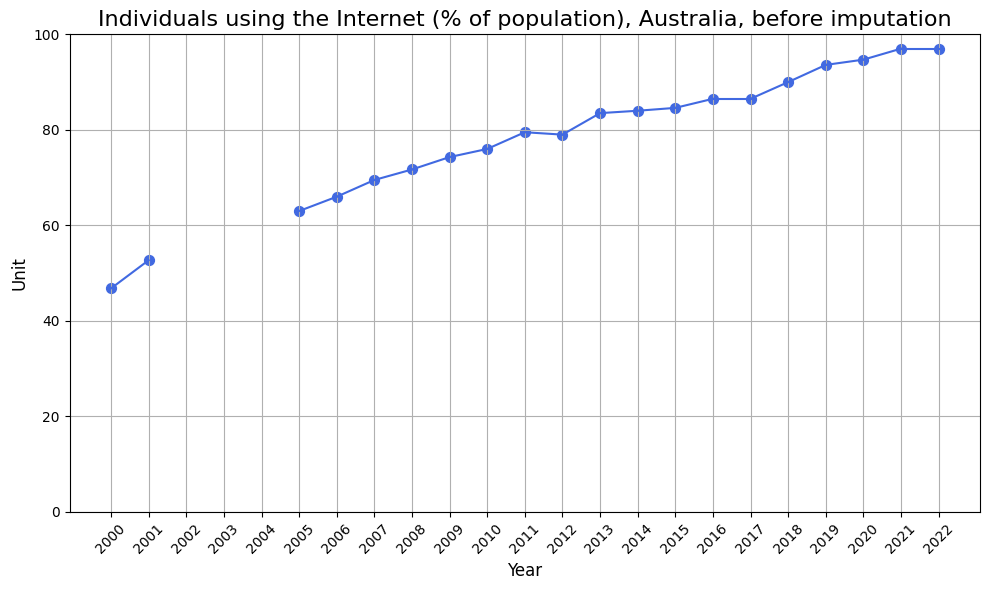

In [317]:
# Filtrer les données
pays = "Australia"
indicateur = "Individuals using the Internet (% of population)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [318]:
df_mask = ESG_df_ByInd['Country Name']== "Australia"

x = np.arange(len(ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"]))
y = ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"]

mask = ~np.isnan(y)

f = interpolate.interp1d(
                  x[mask],
                  y[mask],
                  kind='linear',
                  fill_value='extrapolate',
                  bounds_error=False)
y_interp = f(x)

# update dataset
ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"] = y_interp

ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Australia"][["Country Name","Individuals using the Internet (% of population)"]].reset_index()

Indicator Name  index Country Name  \
0                 161    Australia   
1                 162    Australia   
2                 163    Australia   
3                 164    Australia   
4                 165    Australia   
5                 166    Australia   
6                 167    Australia   
7                 168    Australia   
8                 169    Australia   
9                 170    Australia   
10                171    Australia   
11                172    Australia   
12                173    Australia   
13                174    Australia   
14                175    Australia   
15                176    Australia   
16                177    Australia   
17                178    Australia   
18                179    Australia   
19                180    Australia   
20                181    Australia   
21                182    Australia   
22                183    Australia   

Indicator Name  Individuals using the Internet (% of population)  
0                                                         46.800  
1                                                         52.700  
2                                                         55.275  
3                                                         57.850  
4                                                         60.425  
5                                                         63.000  
6                                                         66.000  
7                                                         69.500  
8                                                         71.700  
9                                                         74.300  
10                                                        76.000  
11                                                        79.500  
12                                                        79.000  
13                                                        83.500  
14                                                        84.000  
15                                                        84.600  
16                                                        86.500  
17                                                        86.500  
18                                                        90.000  
19                                                        93.600  
20                                                        94.700  
21                                                        97.000  
22                                                        97.000

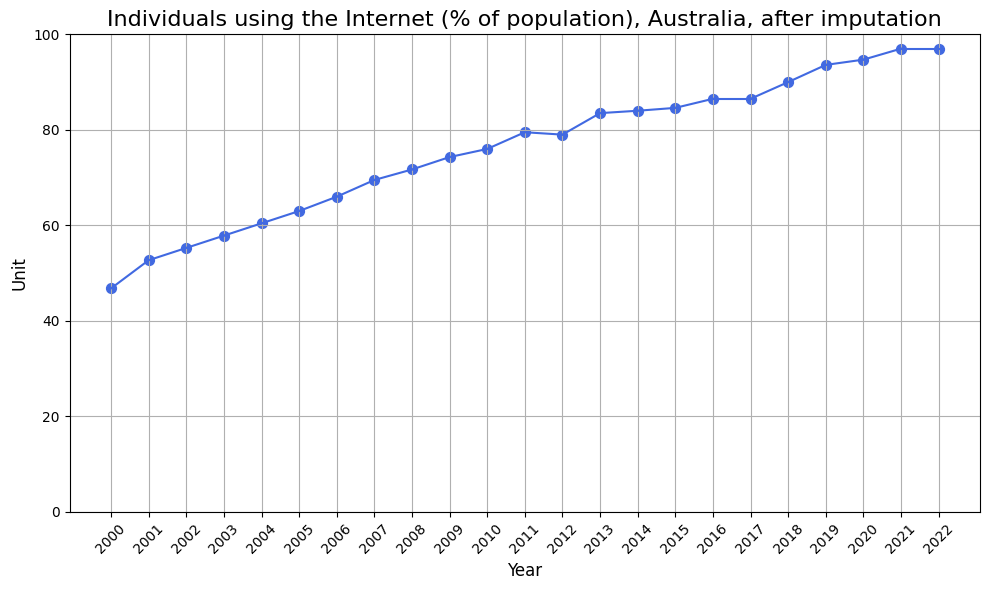

In [319]:
# Filtrer les données
pays = "Australia"
indicateur = "Individuals using the Internet (% of population)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [320]:
# Voir la série problématique
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Belarus"][["Country Name","Individuals using the Internet (% of population)"]].reset_index()

Indicator Name  index Country Name  \
0                 322      Belarus   
1                 323      Belarus   
2                 324      Belarus   
3                 325      Belarus   
4                 326      Belarus   
5                 327      Belarus   
6                 328      Belarus   
7                 329      Belarus   
8                 330      Belarus   
9                 331      Belarus   
10                332      Belarus   
11                333      Belarus   
12                334      Belarus   
13                335      Belarus   
14                336      Belarus   
15                337      Belarus   
16                338      Belarus   
17                339      Belarus   
18                340      Belarus   
19                341      Belarus   
20                342      Belarus   
21                343      Belarus   
22                344      Belarus   

Indicator Name  Individuals using the Internet (% of population)  
0                                                           1.86  
1                                                           4.30  
2                                                           8.95  
3                                                            NaN  
4                                                            NaN  
5                                                            NaN  
6                                                          16.20  
7                                                          19.70  
8                                                          23.00  
9                                                          27.40  
10                                                         31.80  
11                                                         39.60  
12                                                         46.90  
13                                                         54.20  
14                                                         59.00  
15                                                         62.20  
16                                                         71.10  
17                                                         74.40  
18                                                         79.10  
19                                                         82.80  
20                                                         85.10  
21                                                         86.90  
22                                                         89.50

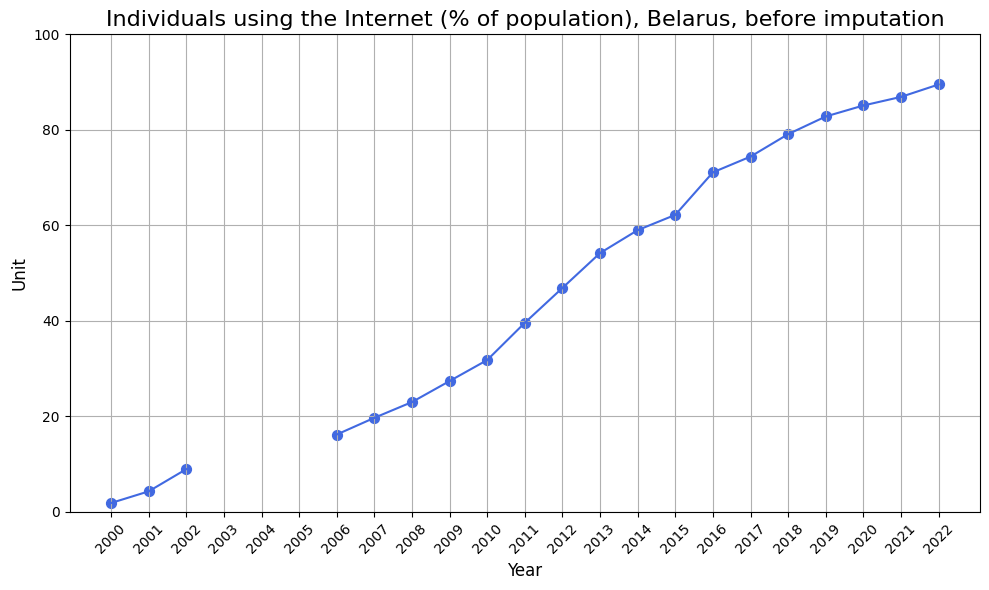

In [321]:
# Filtrer les données
pays = "Belarus"
indicateur = "Individuals using the Internet (% of population)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [322]:
df_mask = ESG_df_ByInd['Country Name']== "Belarus"

x = np.arange(len(ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"]))
y = ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"]

mask = ~np.isnan(y)

f = interpolate.interp1d(
                  x[mask],
                  y[mask],
                  kind='linear',
                  fill_value='extrapolate',
                  bounds_error=False)
y_interp = f(x)

# update dataset
ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"] = y_interp

ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Belarus"][["Country Name","Individuals using the Internet (% of population)"]].reset_index()

Indicator Name  index Country Name  \
0                 322      Belarus   
1                 323      Belarus   
2                 324      Belarus   
3                 325      Belarus   
4                 326      Belarus   
5                 327      Belarus   
6                 328      Belarus   
7                 329      Belarus   
8                 330      Belarus   
9                 331      Belarus   
10                332      Belarus   
11                333      Belarus   
12                334      Belarus   
13                335      Belarus   
14                336      Belarus   
15                337      Belarus   
16                338      Belarus   
17                339      Belarus   
18                340      Belarus   
19                341      Belarus   
20                342      Belarus   
21                343      Belarus   
22                344      Belarus   

Indicator Name  Individuals using the Internet (% of population)  
0                                                         1.8600  
1                                                         4.3000  
2                                                         8.9500  
3                                                        10.7625  
4                                                        12.5750  
5                                                        14.3875  
6                                                        16.2000  
7                                                        19.7000  
8                                                        23.0000  
9                                                        27.4000  
10                                                       31.8000  
11                                                       39.6000  
12                                                       46.9000  
13                                                       54.2000  
14                                                       59.0000  
15                                                       62.2000  
16                                                       71.1000  
17                                                       74.4000  
18                                                       79.1000  
19                                                       82.8000  
20                                                       85.1000  
21                                                       86.9000  
22                                                       89.5000

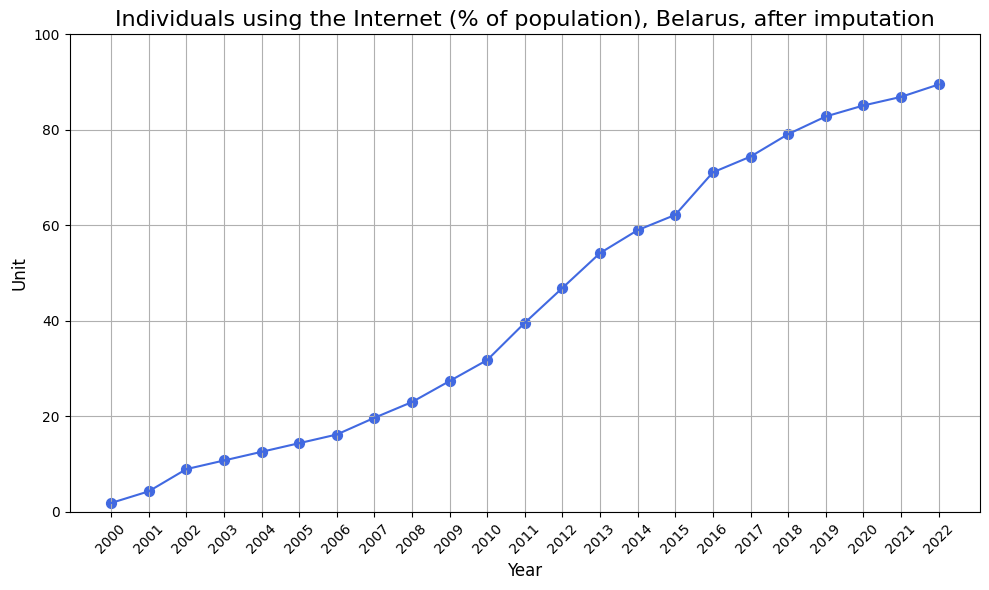

In [323]:
# Filtrer les données
pays = "Belarus"
indicateur = "Individuals using the Internet (% of population)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [324]:
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Mongolia"]["Individuals using the Internet (% of population)"]

2553     1.26
2554     1.65
2555     2.04
2556      NaN
2557      NaN
2558      NaN
2559      NaN
2560     9.00
2561     9.80
2562    10.00
2563    10.20
2564    12.50
2565    16.40
2566    17.70
2567    19.90
2568    22.50
2569    22.30
2570    23.70
2571    47.10
2572    51.10
2573    62.50
2574    81.60
2575    82.20
Name: Individuals using the Internet (% of population), dtype: float64

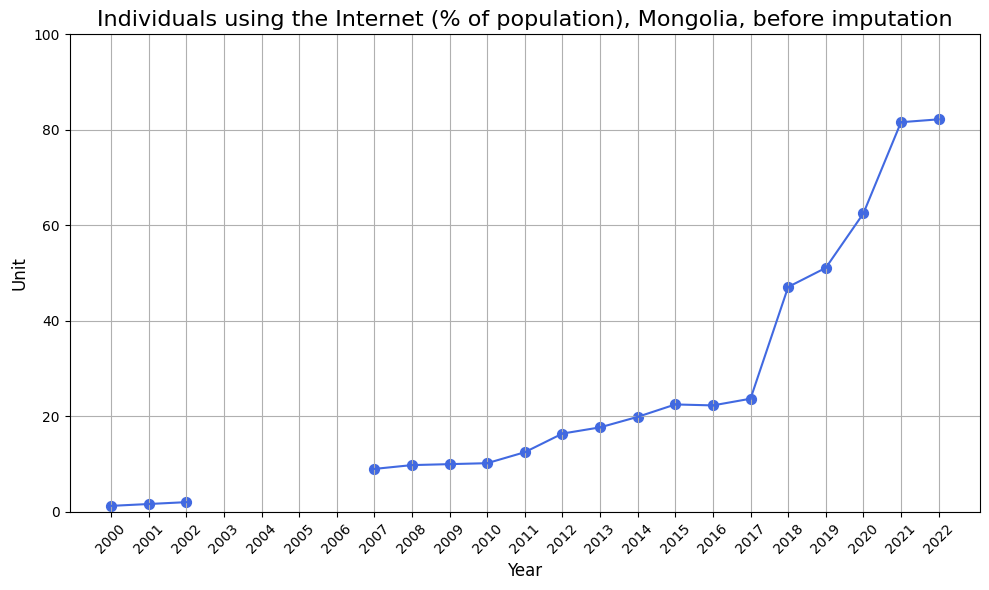

In [325]:
# Filtrer les données
pays = "Mongolia"
indicateur = "Individuals using the Internet (% of population)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [326]:
df_mask = ESG_df_ByInd['Country Name']== "Mongolia"

x = np.arange(len(ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"]))
y = ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"]

mask = ~np.isnan(y)

f = interpolate.interp1d(
                  x[mask],
                  y[mask],
                  kind='linear',
                  fill_value='extrapolate',
                  bounds_error=False)
y_interp = f(x)

# update dataset
ESG_df_ByInd.loc[df_mask,"Individuals using the Internet (% of population)"] = y_interp

ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Mongolia"][["Country Name","Individuals using the Internet (% of population)"]].reset_index()

Indicator Name  index Country Name  \
0                2553     Mongolia   
1                2554     Mongolia   
2                2555     Mongolia   
3                2556     Mongolia   
4                2557     Mongolia   
5                2558     Mongolia   
6                2559     Mongolia   
7                2560     Mongolia   
8                2561     Mongolia   
9                2562     Mongolia   
10               2563     Mongolia   
11               2564     Mongolia   
12               2565     Mongolia   
13               2566     Mongolia   
14               2567     Mongolia   
15               2568     Mongolia   
16               2569     Mongolia   
17               2570     Mongolia   
18               2571     Mongolia   
19               2572     Mongolia   
20               2573     Mongolia   
21               2574     Mongolia   
22               2575     Mongolia   

Indicator Name  Individuals using the Internet (% of population)  
0                                                          1.260  
1                                                          1.650  
2                                                          2.040  
3                                                          3.432  
4                                                          4.824  
5                                                          6.216  
6                                                          7.608  
7                                                          9.000  
8                                                          9.800  
9                                                         10.000  
10                                                        10.200  
11                                                        12.500  
12                                                        16.400  
13                                                        17.700  
14                                                        19.900  
15                                                        22.500  
16                                                        22.300  
17                                                        23.700  
18                                                        47.100  
19                                                        51.100  
20                                                        62.500  
21                                                        81.600  
22                                                        82.200

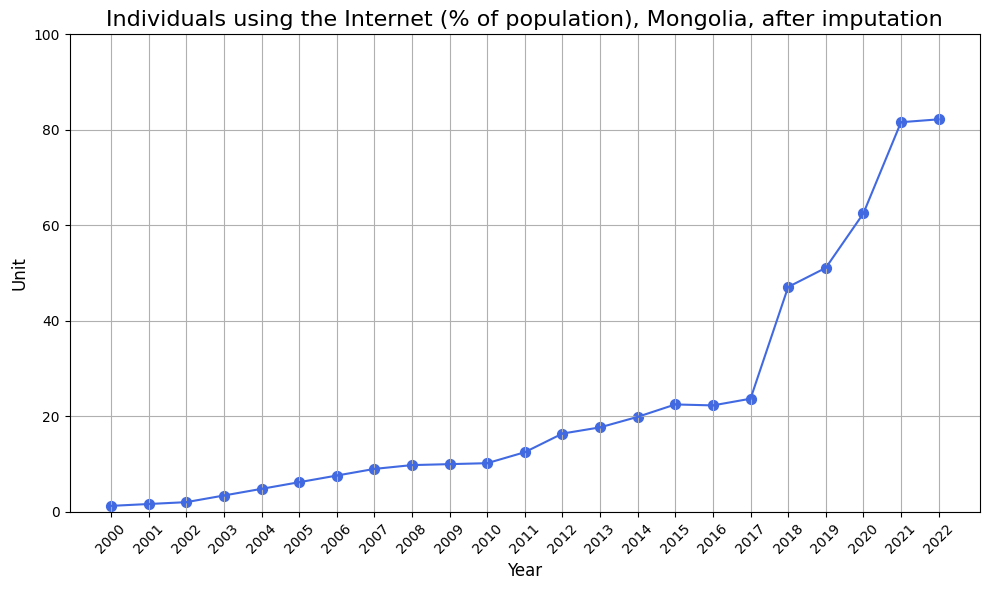

In [327]:
# Filtrer les données
pays = "Mongolia"
indicateur = "Individuals using the Internet (% of population)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

### Adjusted savings, net forest depletion (% of GNI)

Cet indicateur est plus complexe, car évolue en fonction des prix annuels du bois et de l'économie du pays, donc peut varier fortement d'une année à l'autre. Pour UK on peut en revanche supposer que cette valeur reste à 0 tout du long, son économie est stable et ne repose pas sur le travail des fôret, on ne notte d'ailleurs pas d'évolution particulière de la déforestation https://www.globalforestwatch.org/dashboards/country/GBR/.

In [328]:
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "United Kingdom"]["Adjusted savings, net forest depletion (% of GNI)"]

4025    0.0
4026    0.0
4027    0.0
4028    0.0
4029    0.0
4030    0.0
4031    0.0
4032    0.0
4033    0.0
4034    0.0
4035    0.0
4036    0.0
4037    0.0
4038    0.0
4039    0.0
4040    0.0
4041    0.0
4042    0.0
4043    0.0
4044    NaN
4045    NaN
4046    NaN
4047    NaN
Name: Adjusted savings, net forest depletion (% of GNI), dtype: float64

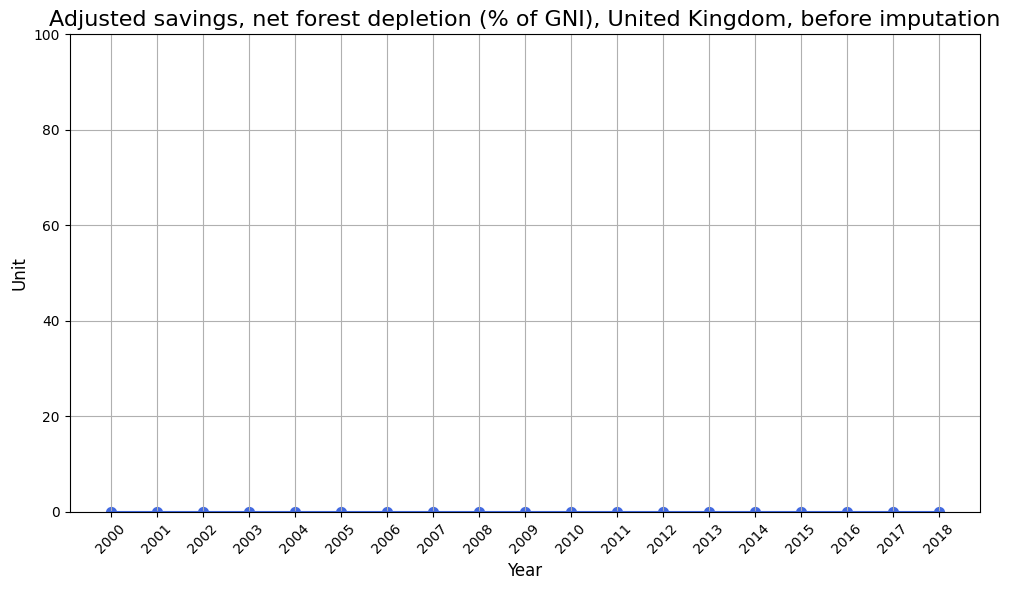

In [329]:
# Filtrer les données
pays = "United Kingdom"
indicateur = "Adjusted savings, net forest depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

In [330]:
mask = ESG_df_ByInd['Country Name'] == "United Kingdom"
col = "Adjusted savings, net forest depletion (% of GNI)"

ESG_df_ByInd.loc[mask, col] = ESG_df_ByInd.loc[mask, col].fillna(0.0)
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "United Kingdom"]["Adjusted savings, net forest depletion (% of GNI)"]

4025    0.0
4026    0.0
4027    0.0
4028    0.0
4029    0.0
4030    0.0
4031    0.0
4032    0.0
4033    0.0
4034    0.0
4035    0.0
4036    0.0
4037    0.0
4038    0.0
4039    0.0
4040    0.0
4041    0.0
4042    0.0
4043    0.0
4044    0.0
4045    0.0
4046    0.0
4047    0.0
Name: Adjusted savings, net forest depletion (% of GNI), dtype: float64

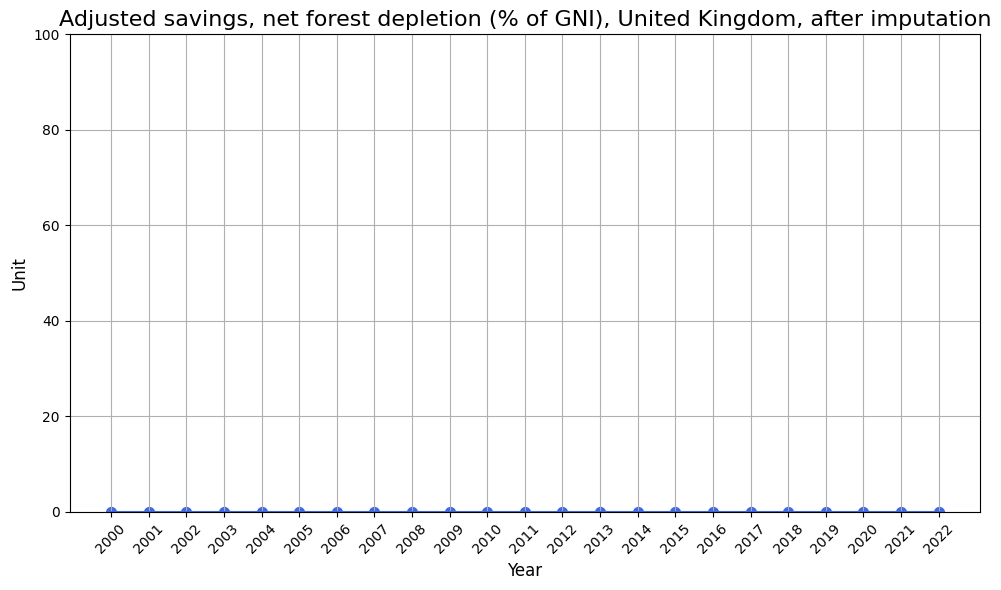

In [331]:
# Filtrer les données
pays = "United Kingdom"
indicateur = "Adjusted savings, net forest depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.grid(True)
plt.tight_layout()
plt.show()

Pour les cas suivant on a peu d'informations mais comme l'emplacement des valeurs est différentes on va considérer qu'on se situe sous le méchanisme MAR (Missing At Random). On va donc travailler en MI (Multiple Imputation) et MCMC(Markov Chain Monte Carlo), on utilise le package (Multiple Imputation by Chained Equations) miceforest est une librairie très fidèle à la méthode MI (utilise des forêts aléatoires). On considère que les pays sont indépendant entre eux et on va donc utiliser uniquement les données de chacun et imputer de leur côté. (Possible d'utiliser les données des autres pays si je pense qu'il y a une corrélation entre eux, genre pays européens ont les même valeur, mais pour ce qui est des forêt j'ai pas l'expertise du tout et je pense que c'est variable)

In [332]:
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Tajikistan"]["Adjusted savings, net forest depletion (% of GNI)"]

3726       NaN
3727       NaN
3728       NaN
3729       NaN
3730    0.0000
3731    0.0183
3732    0.0000
3733    0.0000
3734    0.0000
3735    0.0000
3736    0.0000
3737    0.0000
3738    0.0000
3739    0.0000
3740    0.4300
3741    0.5063
3742    0.5283
3743    0.5984
3744    0.6884
3745    0.6543
3746    0.6563
3747    0.6418
3748       NaN
Name: Adjusted savings, net forest depletion (% of GNI), dtype: float64

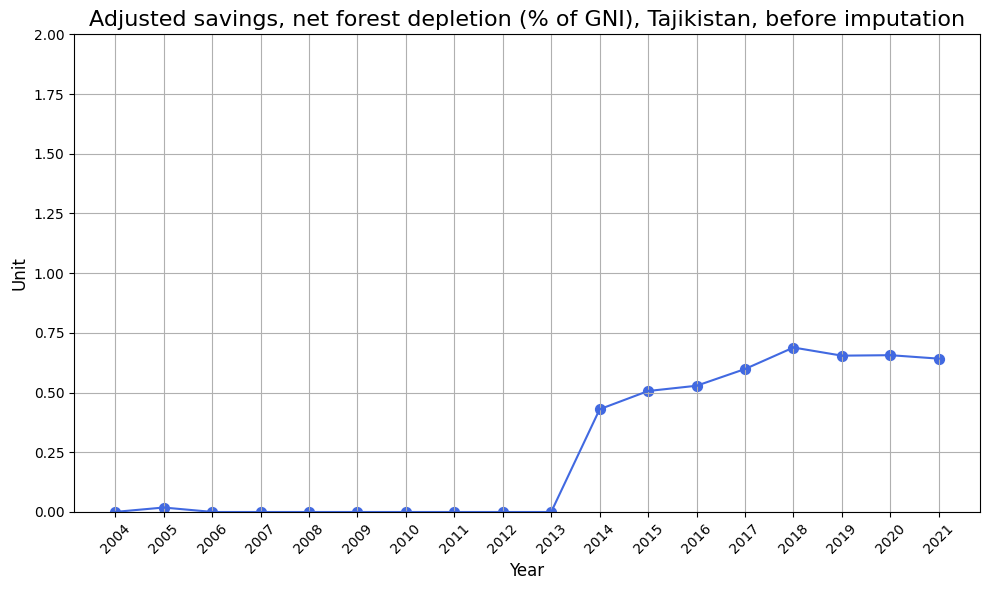

In [333]:
# Filtrer les données
pays = "Tajikistan"
indicateur = "Adjusted savings, net forest depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 2)
plt.grid(True)
plt.tight_layout()
plt.show()

In [334]:
mask = ESG_df_ByInd['Country Name'] == "Tajikistan"
col = "Adjusted savings, net forest depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Tajikistan"]["Adjusted savings, net forest depletion (% of GNI)"]

3726    0.0000
3727    0.0000
3728    0.0000
3729    0.0000
3730    0.0000
3731    0.0183
3732    0.0000
3733    0.0000
3734    0.0000
3735    0.0000
3736    0.0000
3737    0.0000
3738    0.0000
3739    0.0000
3740    0.4300
3741    0.5063
3742    0.5283
3743    0.5984
3744    0.6884
3745    0.6543
3746    0.6563
3747    0.6418
3748    0.6418
Name: Adjusted savings, net forest depletion (% of GNI), dtype: float64

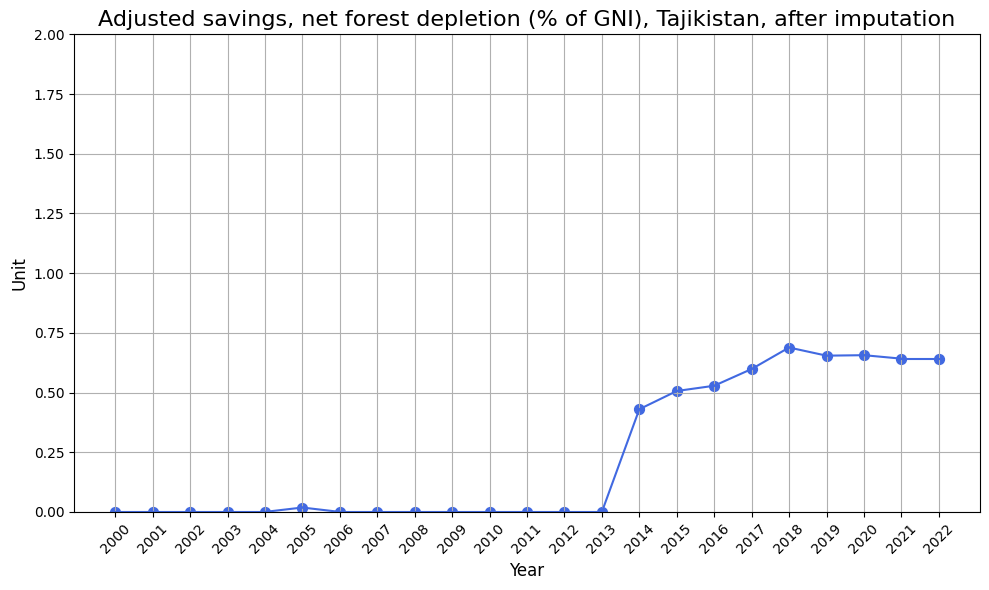

In [335]:
# Filtrer les données
pays = "Tajikistan"
indicateur = "Adjusted savings, net forest depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 2)
plt.grid(True)
plt.tight_layout()
plt.show()

### Adjusted savings, natural resources depletion (% of GNI)

In [336]:
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Tajikistan"]["Adjusted savings, natural resources depletion (% of GNI)"]

3726       NaN
3727       NaN
3728       NaN
3729       NaN
3730    0.3217
3731    0.2426
3732    0.3324
3733    0.2892
3734    0.2570
3735    0.2872
3736    0.6561
3737    0.8948
3738    0.7548
3739    0.5531
3740    1.1299
3741    1.3198
3742    2.1774
3743    2.1852
3744    2.7539
3745    3.2738
3746    3.1385
3747    5.3747
3748       NaN
Name: Adjusted savings, natural resources depletion (% of GNI), dtype: float64

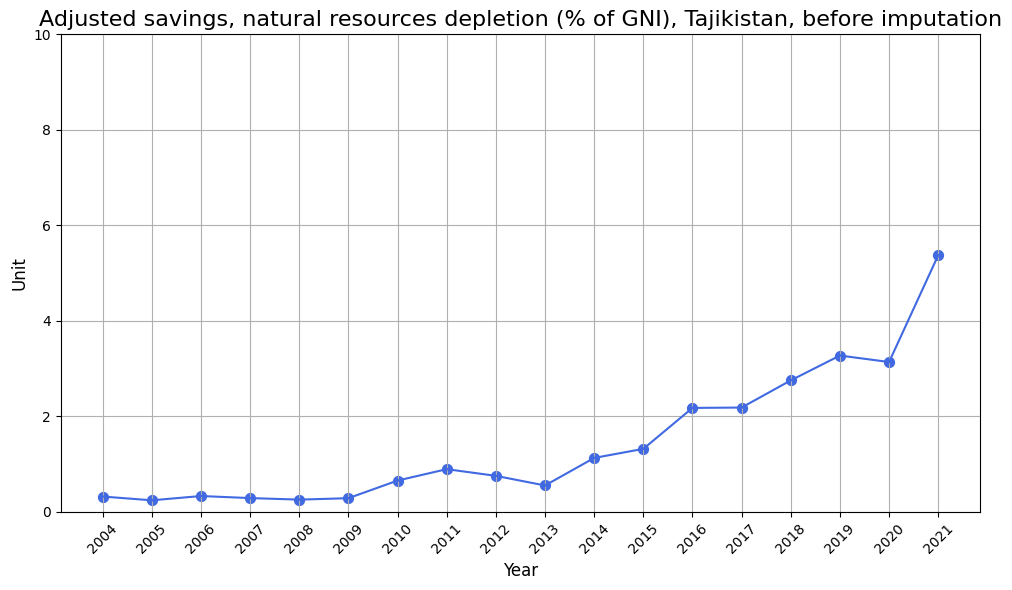

In [337]:
# Filtrer les données
pays = "Tajikistan"
indicateur = "Adjusted savings, natural resources depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [338]:
mask = ESG_df_ByInd['Country Name'] == "Tajikistan"
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "Tajikistan"]["Adjusted savings, natural resources depletion (% of GNI)"]

3726    0.2570
3727    0.2892
3728    0.3217
3729    0.2570
3730    0.3217
3731    0.2426
3732    0.3324
3733    0.2892
3734    0.2570
3735    0.2872
3736    0.6561
3737    0.8948
3738    0.7548
3739    0.5531
3740    1.1299
3741    1.3198
3742    2.1774
3743    2.1852
3744    2.7539
3745    3.2738
3746    3.1385
3747    5.3747
3748    5.3747
Name: Adjusted savings, natural resources depletion (% of GNI), dtype: float64

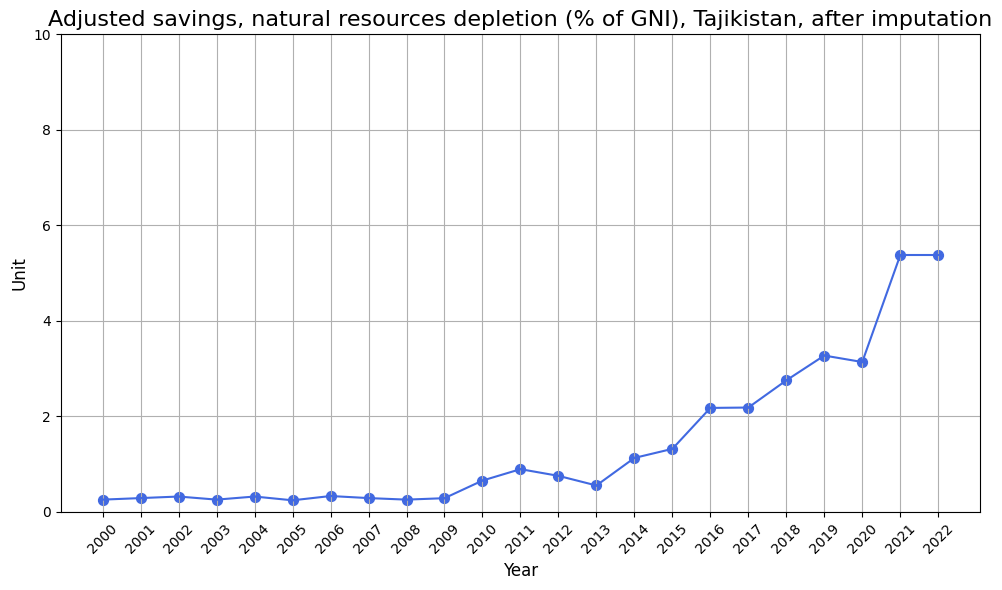

In [339]:
# Filtrer les données
pays = "Tajikistan"
indicateur = "Adjusted savings, natural resources depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 10)
plt.grid(True)
plt.tight_layout()
plt.show()

In [340]:
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "United Kingdom"]["Adjusted savings, natural resources depletion (% of GNI)"]

4025    0.9563
4026    0.8419
4027    0.7277
4028    0.6812
4029    0.6600
4030    0.7425
4031    0.8209
4032    0.7761
4033    1.2270
4034    0.7758
4035    0.7777
4036    0.9392
4037    0.7504
4038    0.6168
4039    0.4915
4040    0.3030
4041    0.2476
4042    0.3545
4043    0.5615
4044       NaN
4045       NaN
4046       NaN
4047       NaN
Name: Adjusted savings, natural resources depletion (% of GNI), dtype: float64

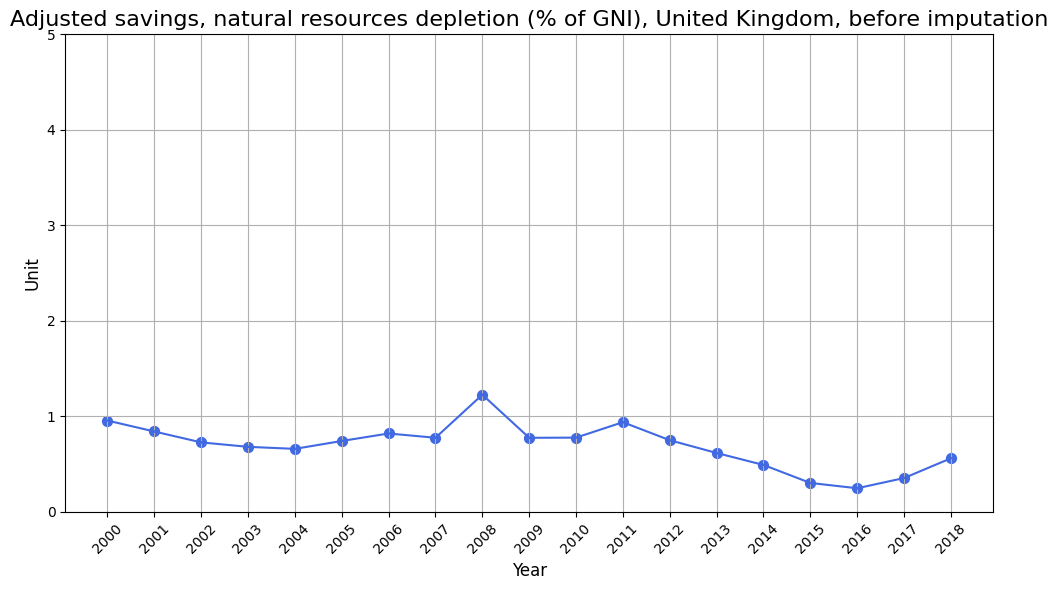

In [341]:
# Filtrer les données
pays = "United Kingdom"
indicateur = "Adjusted savings, natural resources depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, before imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.grid(True)
plt.tight_layout()
plt.show()

In [342]:
mask = ESG_df_ByInd['Country Name'] == "United Kingdom"
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values
ESG_df_ByInd[ESG_df_ByInd['Country Name']== "United Kingdom"]["Adjusted savings, natural resources depletion (% of GNI)"]

4025    0.9563
4026    0.8419
4027    0.7277
4028    0.6812
4029    0.6600
4030    0.7425
4031    0.8209
4032    0.7761
4033    1.2270
4034    0.7758
4035    0.7777
4036    0.9392
4037    0.7504
4038    0.6168
4039    0.4915
4040    0.3030
4041    0.2476
4042    0.3545
4043    0.5615
4044    0.3545
4045    0.2476
4046    0.3545
4047    0.7504
Name: Adjusted savings, natural resources depletion (% of GNI), dtype: float64

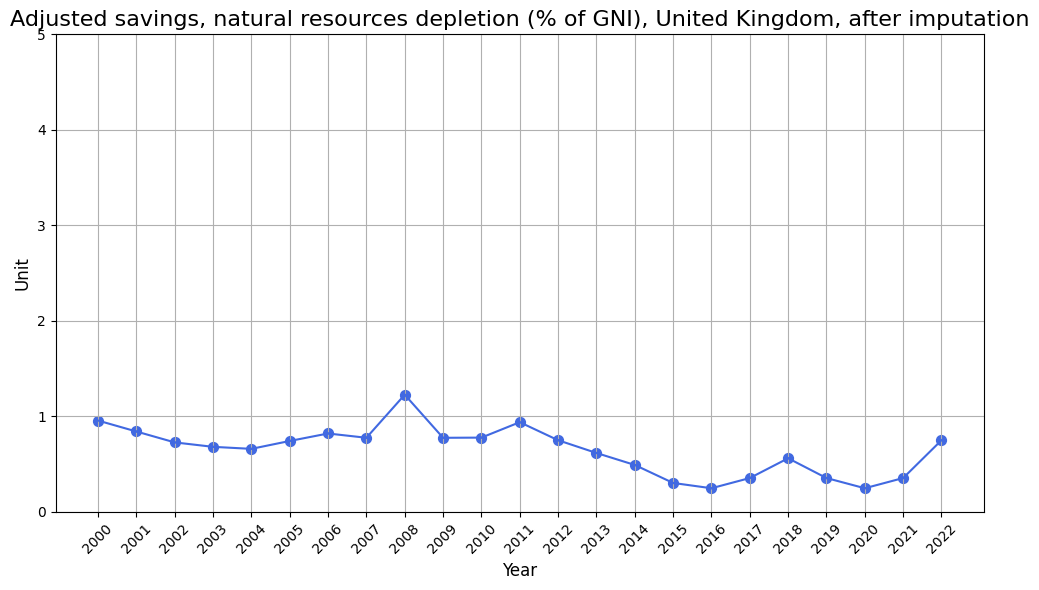

In [343]:
# Filtrer les données
pays = "United Kingdom"
indicateur = "Adjusted savings, natural resources depletion (% of GNI)"

df = ESG_df_ByInd[ESG_df_ByInd['Country Name'] == pays][
    ["Year", indicateur]
].reset_index(drop=True)

plt.figure(figsize=(10,6))

# --- Tracer les points uniquement ---
plt.scatter(
    df["Year"],
    df[indicateur],
    color="royalblue",
    s=50
)

# --- Tracer des segments seulement entre points valides ---
for i in range(len(df)-1):
    y0 = df.loc[i, indicateur]
    y1 = df.loc[i+1, indicateur]
    if pd.notna(y0) and pd.notna(y1):
        plt.plot(
            [df.loc[i, "Year"], df.loc[i+1, "Year"]],
            [y0, y1],
            color="royalblue"
        )

plt.title(f"{indicateur}, {pays}, after imputation", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Unit", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.grid(True)
plt.tight_layout()
plt.show()

In [344]:
# Compute le % de valeur présente pour chaque paire indicateur/pays
missing_data = ESG_df_ByInd.drop(columns=["Year"]).groupby("Country Name").count().reset_index()
cols = missing_data.columns[1:]
missing_data[cols] = missing_data[cols]/nb_years*100

# Récuperer les données à moins de 100% -> (à completer)
mask = missing_data.drop(columns=["Country Name"]).lt(100)
rows, cols = np.where(mask)

# Construire un DataFrame avec les résultats
missing_data = pd.DataFrame({
    "Country Name": missing_data.iloc[rows]["Country Name"].values,
    "Indicator Name": mask.columns[cols],
    "Value": missing_data.drop(columns=["Country Name"]).values[rows, cols]
})
missing_data.groupby(['Value']).count()

Empty DataFrame
Columns: [Country Name, Indicator Name]
Index: []

## Missing data by Year

In [345]:
# updtate the other formats
ESG_df_long = pd.melt(ESG_df_ByInd, id_vars=['Country Name', 'Year'], var_name='Indicator Name', value_name='Value')

ESG_df = ESG_df_long.pivot_table(
    index=['Country Name', 'Indicator Name'],
    columns='Year',
    values='Value'
).reset_index()

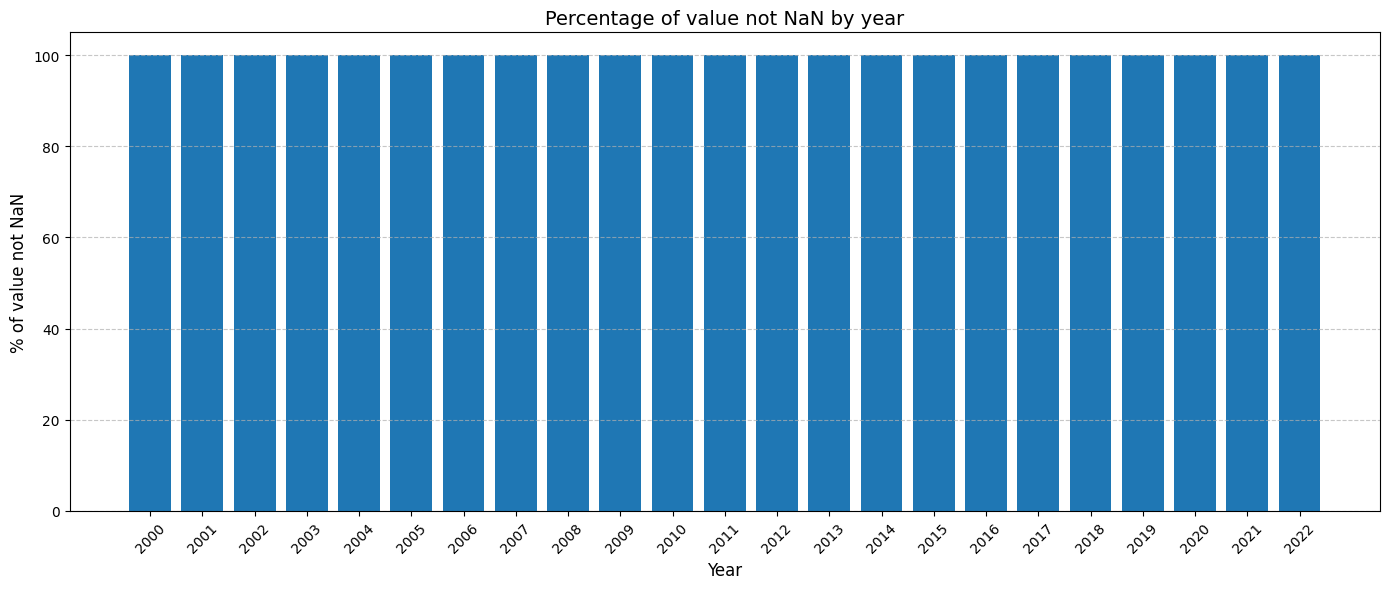

In [346]:
# Number maximal of data by Year (19260)
nb_data_by_year = nb_countries*nb_indicators

# Compute % of data
df_year = ESG_df.drop(columns=["Country Name","Indicator Name"]).notna().sum()/nb_data_by_year*100

# Show the repartition
plt.figure(figsize=(14, 6))
plt.bar(df_year.index, df_year.values)
plt.title("Percentage of value not NaN by year", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Missing data by Indicator

/tmp/ipython-input-3771822346.py:23: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


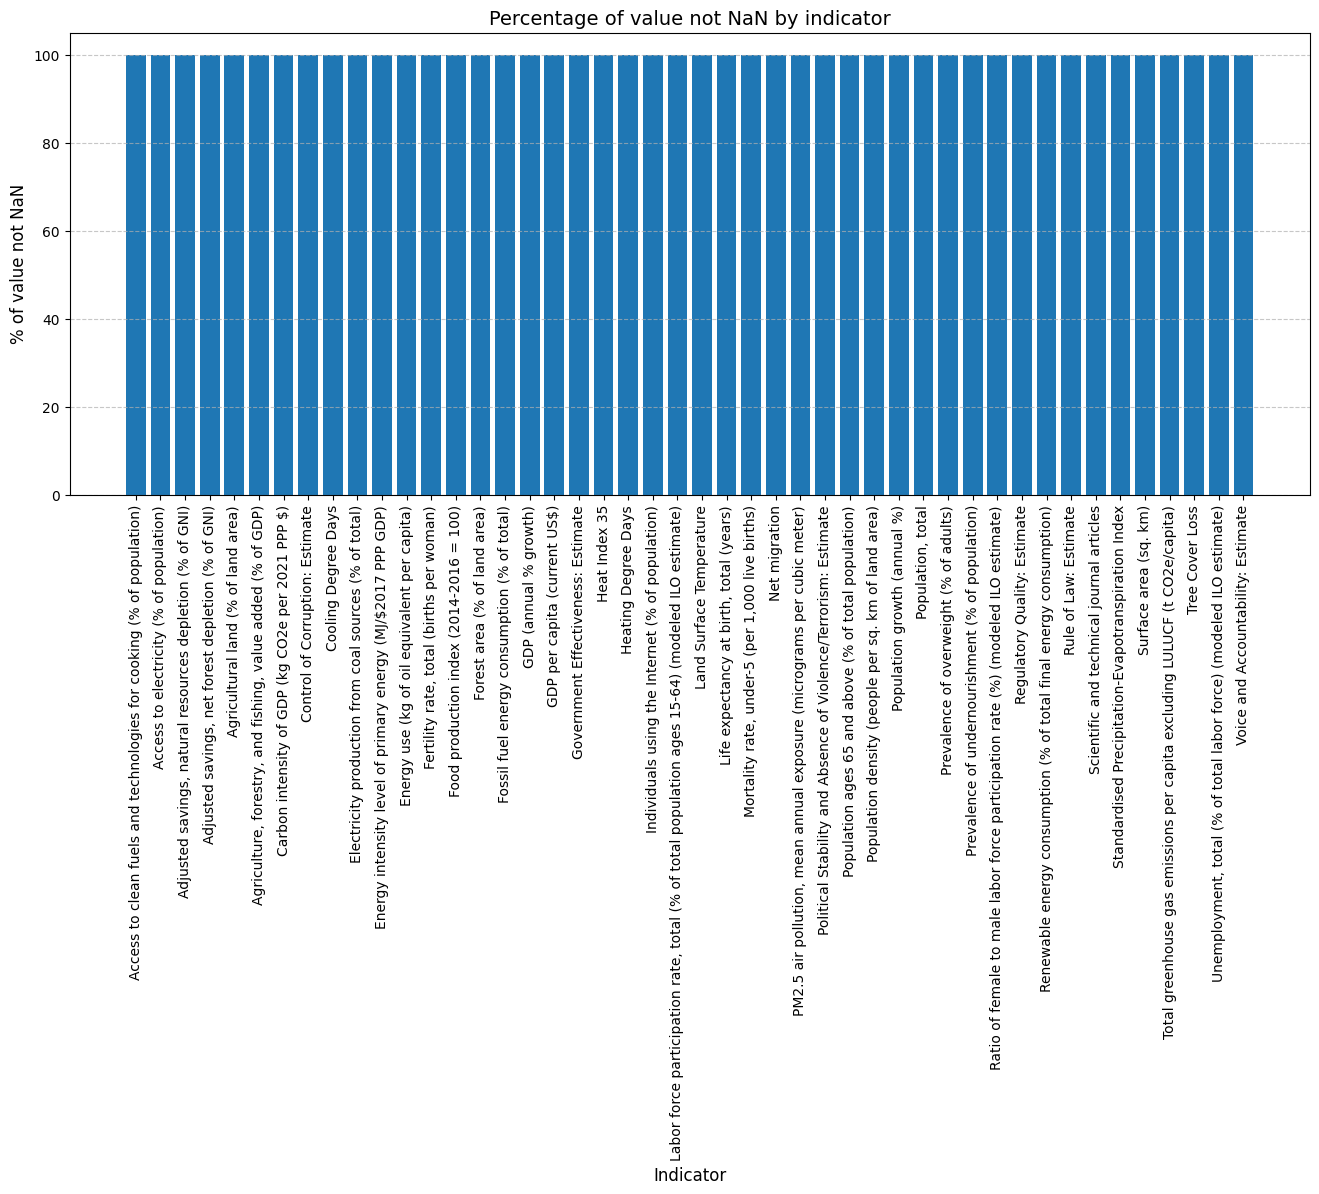

In [347]:
# Number maximal of data by Indicator (13910)
nb_data_by_indicator = nb_countries*nb_years

# Put the indicators in columns
df_ind = ESG_df_long.pivot_table(
    index=['Country Name', 'Year'],
    columns='Indicator Name',
    values='Value'
).reset_index()

# Compute % of data
df_ind = df_ind.drop(columns=["Country Name","Year"]).notna().sum()/nb_data_by_indicator*100
df_ind.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(16, 6))
plt.bar(df_ind.index, df_ind.values)
plt.title("Percentage of value not NaN by indicator", fontsize=14)
plt.xlabel("Indicator", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90,ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Missing data by Country

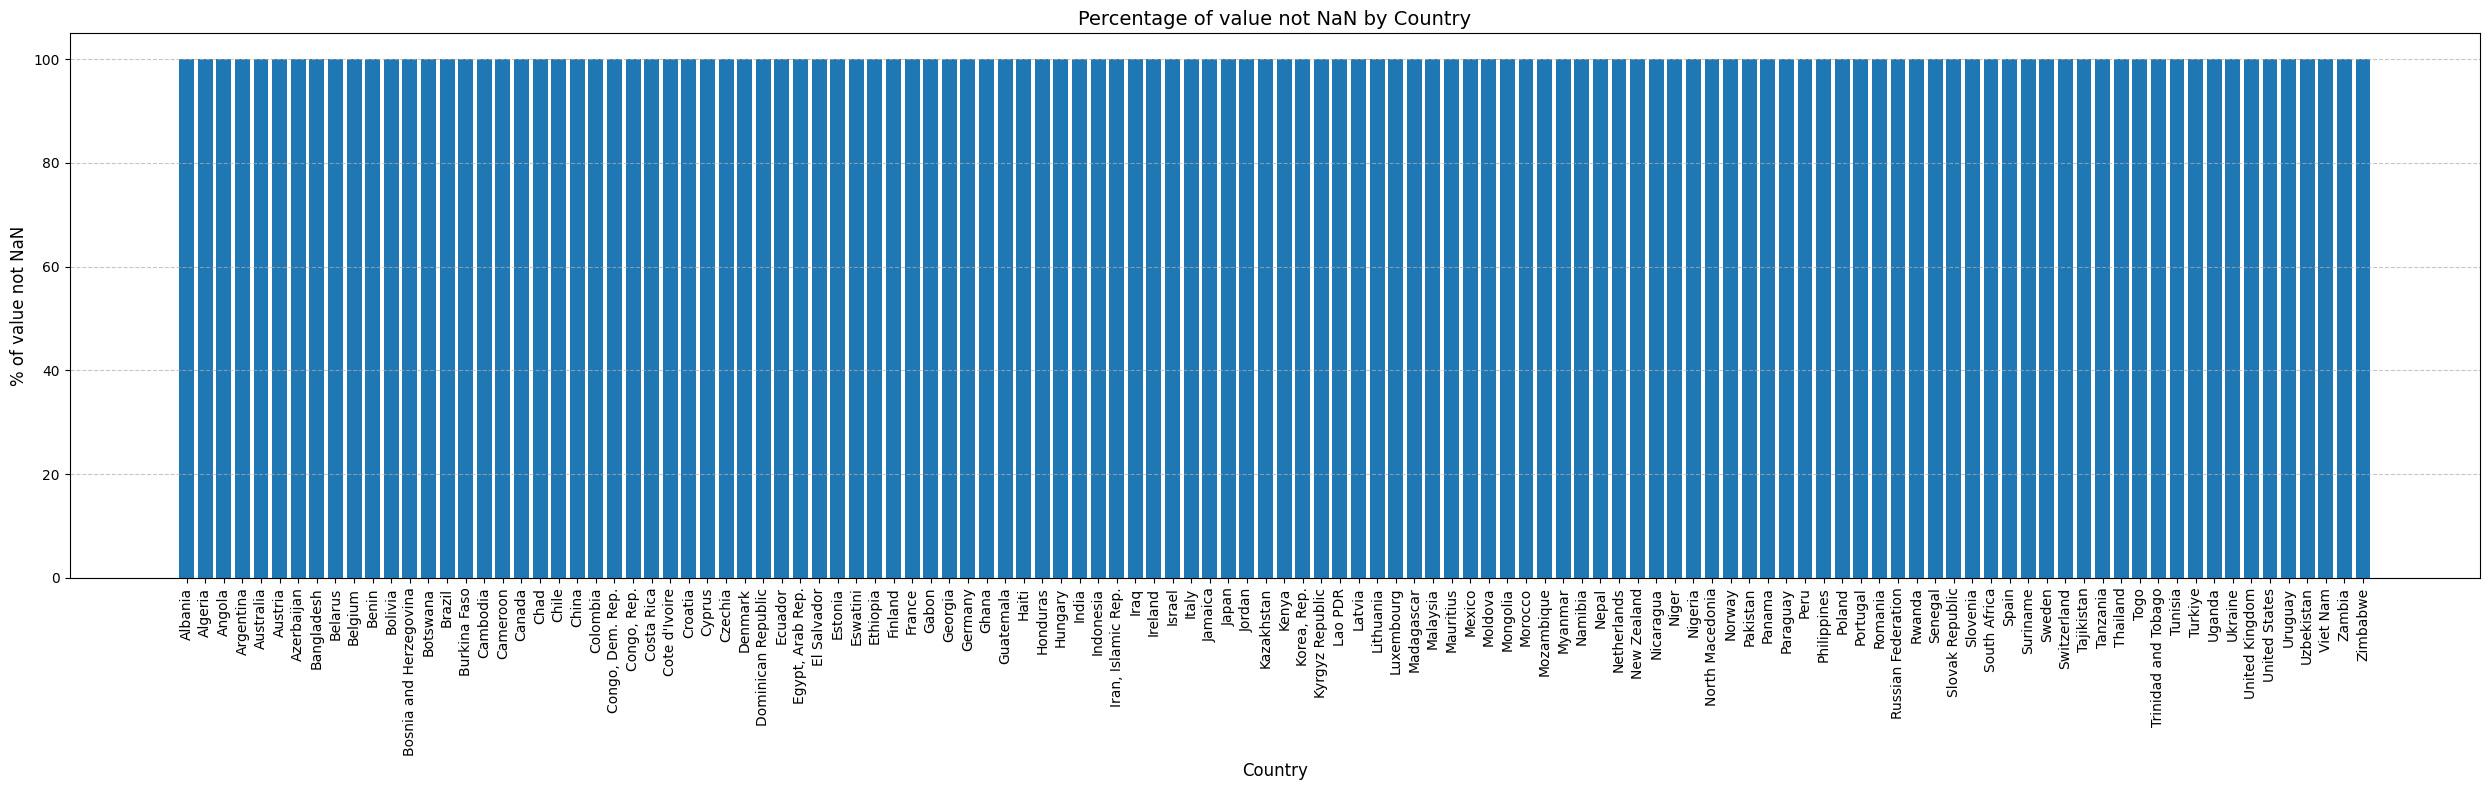

In [348]:
# Number maximal of data by Country (5850)
nb_data_by_country = nb_indicators*nb_years

# Put the Countries in columns
df_countries = ESG_df_long.pivot_table(
    index=['Indicator Name', 'Year'],
    columns='Country Name',
    values='Value'
).reset_index()

# Compute % of data
df_countries = df_countries.drop(columns=["Year","Indicator Name"]).notna().sum()/nb_data_by_country*100
df_countries.sort_values(ascending=False, inplace=True)

# Show the repartition
plt.figure(figsize=(25, 8))
plt.bar(df_countries.index, df_countries.values)
plt.title("Percentage of value not NaN by Country", fontsize=14)
plt.xlabel("Country", fontsize=12)
plt.ylabel("% of value not NaN", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [349]:
print(nb_data_by_year)
print(nb_data_by_indicator)
print(nb_data_by_country)

5428
2714
1058


In [350]:
 # % de valeurs manquantes sur l'ensemble du dataset

(ESG_df_ByInd.drop(columns=["Country Name","Year"]).count()/ESG_df_ByInd.shape[0]*100).mean()

np.float64(100.0)

# Handling Outliers

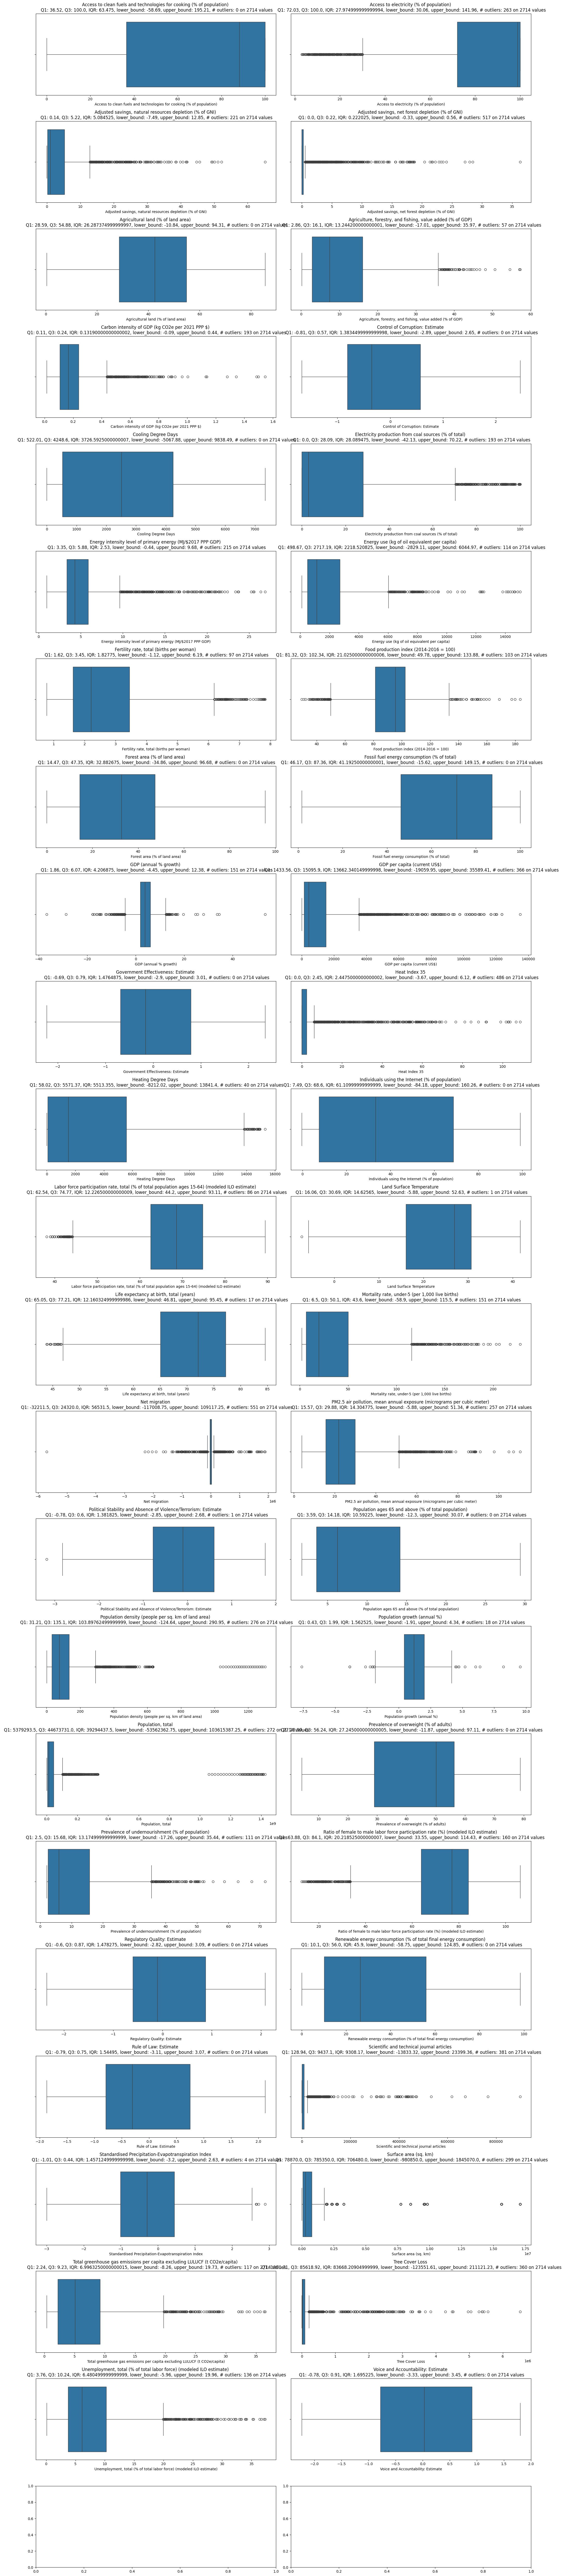

In [351]:
fig, axs = plt.subplots(24, 2, figsize=(20, 100))
axs = axs.flatten()

for column,ax in zip(ESG_df_ByInd.columns.drop(["Country Name","Year"]),axs):

  column_data = ESG_df_ByInd[column].dropna()

  Q1 = np.percentile(column_data, 25)
  Q3 = np.percentile(column_data, 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  outliers = [x for x in column_data if x < lower_bound or x > upper_bound]

  sns.boxplot(x=column, data=ESG_df_ByInd, ax=ax)
  ax.set_title(f'{column} \n Q1: {np.round(Q1,2)}, Q3: {np.round(Q3,2)}, IQR: {IQR}, lower_bound: {np.round(lower_bound,2)}, upper_bound: {np.round(upper_bound,2)}, # outliers: {len(outliers)} on {nb_data_by_indicator} values')

plt.tight_layout()
plt.show()

## Verification of outliers

Les valeurs proche de 0 ont également été vérifiées

* Access to clean fuels and technologies for cooking (% of population)

No outliers

* Access to electricity (% of population)

335 outliers, concernant les pays suivant :

['Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Cambodia', 'Chad',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Eswatini', 'Ethiopia', 'Kenya',
       'Madagascar', 'Mozambique', 'Nepal', 'Niger', 'Rwanda', 'Tanzania',
       'Togo', 'Uganda', 'Zambia']

Pas de valeurs complètemement aberrantes à première vue (on reste au dessus de 0%) De manière générale les valeurs sont du même ordre pour chaque pays et entre les années. Les outliers sont en général des pays peu développés

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/share-of-the-population-with-access-to-electricity
* https://trackingsdg7.esmap.org/

Cas problématiques :

Nope !

* Adjusted savings, natural resources depletion (% of GNI)

(A noter que cet indicateur varie en fonction des valeurs d'exportations des resources et du GNI du pays, les valeurs d'exp peuvent parfois augmenter ou baisser fortement et le GNI varier en cas de crise)

221 outliers, concernant les pays suivant :

['Algeria', 'Angola', 'Azerbaijan', 'Burkina Faso', 'Chad', 'Chile',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Ecuador', 'Ethiopia', 'Gabon',
       'Ghana', 'Iraq', 'Kazakhstan', 'Kyrgyz Republic', 'Mongolia',
       'Myanmar', 'Nigeria', 'Peru', 'Russian Federation', 'Suriname',
       'Togo', 'Trinidad and Tobago', 'Uganda', 'Uzbekistan', 'Zambia',
       'Zimbabwe']

Pas de valeurs complètemement aberrantes à première vue (selon l'unité % of GNI). Variation assez importante des données selon les années (peut être expliqué par la variation des prix des resources sur l'année et des exploitations des pays.

De manière générale les valeurs sont du même ordre pour chaque pays et entre les années (malgré quelques pics). En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://www.indexmundi.com/facts/indicators/NY.ADJ.DRES.GN.ZS/
* https://www.ceicdata.com/en/bahrain/environmental-land-use-protected-areas-and-national-wealth/bh-adjusted-savings-natural-resources-depletion--of-gni)

Quelques cas ou il y a un doute mais pas l'expertise pour vérifier et souvent post covid on les garde et on précisera le doute -> à eliminer potentiellement si trop de problème pour la régression.

Quelques cas ou il y a un doute  :

Les pics arrivent souvent en 2021 et 2022, possiblement du à un changement de méthodo, ou peut être le post covid. La plupart des pays montrent ce pic dans une moindre mesure. Le 2022 est en fait l'imputation qui accentue le pic (aussi expliqué par le fait que l'ind est super variable), on manque de données pour expliquer ce pic, possible post covid, on va changer la méthode d'imputation pour atténuer ce pic qu'on a créé -> normalement peu d'impact sur les biais car moins de 5% de la série

Burkina Faso, gros pic en 2021 et 2022, changement méthodo ? corrigé

Chili, pic 2021, 2022 corrigé

Kazakhstan idem  corrigé

Kyrgyz Republic pareil corrigé

Peru pareil corrigé

Russian Federation pareil corrigé

Myanmar, Les valeurs de CEIC et Index mundi 2 à 3 fois plus basses mais gardent la même forme, ChatGPT trouve pas ça choquant, non corrigé

Zambia *4 en 2021 un peu chelou même avec rebond covid mais pas d'autres données pour vérifier -> applatir cette valeur ? peut être pas dû à un contexte précis flambé des prix cuivre + grosse prod + recul GNI corrigé

Zimbabwe le pic 2007-2008 est un peu vénère probable distortion due à la crise économique hardcore à aplatir ? non corrigé

* Adjusted savings, net forest depletion (% of GNI)

(A noter que cet indicateur varie en fonction des valeurs d'exportations des resources et du GNI du pays, les valeurs d'exp peuvent parfois augmenter ou baisser fortement et le GNI varier en cas de crise)

517 outliers, concernant les pays suivant :

['Angola', 'Benin', 'Bosnia and Herzegovina', 'Cameroon', 'Chad',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'El Salvador', 'Eswatini',
       'Ethiopia', 'Gabon', 'Ghana', 'Haiti', 'Honduras', 'Kenya',
       'Lao PDR', 'Lithuania', 'Madagascar', 'Malaysia', 'Mozambique',
       'Myanmar', 'Namibia', 'Nepal', 'Paraguay', 'Rwanda', 'Suriname',
       'Tajikistan', 'Togo', 'Uganda', 'Zambia', 'Zimbabwe']

Pas de valeurs complètemement aberrantes à première vue (selon l'unité % of GNI), on reste à moins de 40%. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années, et restent assez basses et proche de la moyenne.

 En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://www.indexmundi.com/facts/indicators/NY.ADJ.DFOR.GN.ZS/
* https://www.ceicdata.com

Cas problématique :

Bénin, tout à 0 à partir de 2003 parait étrange alors que j'ai vérifié il y a de la deforestation (forest loss) donc à passer en NaN (probable manque de données) -> Attention forest loss concernent pas forcément deforestation, peut être naturel (incendie) -> forest watch quasiment pas de perte de foret (primaire) -> On va considérer que c'est un choix de worldBank et que la déforestation est négligeable, pas de correction

Congo Dem Rep
Pics très élévés en 2003 mais cohérent avec natural resources depletion, chiffres incohérents avec index mundi -> forest watch grosse perte de foret
pas de correction

Honduras 0 à partir de 2011, étrange surtout qu'on retrouve de la deforestation donc à passer en NaN (probable manque de données) -> compléter index mundi maybe ? -> à prendre en compte beaucoup de pays sont en fait à zéro possible choix méthodo de worldbank de dire que les valeurs sont négligeable -> forest watch encore de l'exploitation apparemment, pas de correction

Myanmar plus élevé que les autres sources (*2-*3) mais chat pas chockbar, pas de correction

Zambia passage à 0 en 2011, un peu bizarre car encore de l'exploitation d'après forest watch, pas de correction

Zimbabwe -> hyperinflation créé un énorme pic en 2007-2008, pas réellement d'exploitation supérieure juste le GNI c'est cassé la geule, pas de correction

* Agricultural land (% of land area)

No outliers

* Agriculture, forestry, and fishing, value added (% of GDP)

57 outliers, concernant les pays suivant :

['Chad', 'Ethiopia', 'Ghana', 'Myanmar', 'Nepal', 'Niger',
       'Nigeria']

Pas de valeurs complètemement aberrantes à première vue (selon l'unité % of GDP), on reste à moins de 60%. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années. Sont souvent des pays très dépendant de l'agriculture et/ou la pêche

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://www.mydatajungle.com/en/indicators/?internal=0&field_req=&layout=&cat=20&indicator=75&country=99&period=1A&source=16&other_countries=&from=1997-12-01&to=2019-12-01&type=line&sort=&btn_applica=Search
* https://ourworldindata.org/grapher/agriculture-share-gdp?tab=line&country=~BDI&mapSelect=~BDI

Cas problématique :

0

* Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)

112 outliers, concernant les pays suivant :

['Australia', 'Canada', 'Estonia', 'Kazakhstan', 'Luxembourg',
       'Trinidad and Tobago', 'United States']

Valeurs assez importantes > 20 t/capita mais techniquement possible, pas forcément aberrant pour des pays gros consommateurs de pétrole et de gaz et ou l'energie est très carbonnée et à faible pop. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/co-emissions-per-capita?country=~AUSfrom=1997-12-01&to=2019-12-01&type=line&sort=&btn_applica=Search
* https://edgar.jrc.ec.europa.eu/report_2022?vis=pop#emissions_table

Cas problématique :

* Carbon intensity of GDP (kg CO2e per 2021 PPP $)

193 outliers, concernant les pays suivant :


['Azerbaijan', 'Belarus', 'Bosnia and Herzegovina', 'China',
       'Estonia', 'Iran, Islamic Rep.', 'Iraq', 'Kazakhstan', 'Mongolia',
       'Poland', 'Russian Federation', 'South Africa',
       'Trinidad and Tobago', 'Ukraine', 'Uzbekistan']

['Azerbaijan', 'Bahrain', 'Belarus', 'Bosnia and Herzegovina',
       'Bulgaria', 'China', 'Estonia', 'Iran, Islamic Rep.', 'Kazakhstan',
       'Kuwait', 'Libya', 'Mongolia', 'Oman', 'Qatar',
       'Russian Federation', 'Seychelles', 'South Africa',
       'Trinidad and Tobago', 'Turkmenistan', 'Ukraine', 'Uzbekistan']

De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://kidb.adb.org/go/sdg-9-4-1-co2-emission-per-unit-of-gdp
* https://ourworldindata.org/grapher/co2-intensity?tab=line&time=2000..latest&country=AZE~BHR
(celui là pas exactement pareil mais pour avoir une idée)

Cas problématique :

* Control of Corruption: Estimate

No outliers

* Cooling Degree Days

No outliers

* Electricity production from coal sources (% of total)

193 outliers, concernant les pays suivant :

['Australia', 'Bosnia and Herzegovina', 'Botswana', 'China',
       'Czechia', 'Estonia', 'India', 'Israel', 'Kazakhstan', 'Mongolia',
       'Morocco', 'Niger', 'North Macedonia', 'Poland', 'South Africa']

Les valeurs ne dépassent pas 100% cohérent, outliers représentent pays encore dépendant au charbon.

De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/share-electricity-coal

Cas problématique :
Aucun lessgo

* Energy intensity level of primary energy (MJ/$2017 PPP GDP)

215 outliers, concernant les pays suivant :

['Azerbaijan', 'Belarus', 'China', 'Congo, Dem. Rep.', 'Ethiopia',
       'Iraq', 'Kazakhstan', 'Mozambique', 'Myanmar', 'Nigeria',
       'Russian Federation', 'Tajikistan', 'Tanzania', 'Togo',
       'Trinidad and Tobago', 'Uganda', 'Ukraine', 'Uzbekistan', 'Zambia',
       'Zimbabwe']

Des valeurs assez élevées (jusqu'à +25 MJ). EN général des pays en developpement avec efficacité energétique à chier. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://w3.unece.org/SDG/en/Indicator?id=24 (PPP 2011)
* https://ourworldindata.org/grapher/energy-intensity-of-economies (PPP jsp)

Cas problématique :

0 wouhou

* Energy use (kg of oil equivalent per capita)

144 outliers, concernant les pays suivant :

'Canada', 'Finland', 'Luxembourg', 'Norway', 'Trinidad and Tobago',
       'United States']

Des valeurs assez élevées (jusqu'à + de 14000 kg). Pays gros consommateurs et/ou à faible efficacité energétique. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://worlddataview.com/topics/environment/energy_use_kg_of_oil_equivalent_per_capita

Cas problématique :

0 wouhou

* Fertility rate, total (births per woman)

97 outliers, concernant les pays suivant :

['Angola', 'Burkina Faso', 'Chad', 'Congo, Dem. Rep.', 'Ethiopia',
       'Niger', 'Uganda']

['Afghanistan', 'Chad', 'Niger', 'Somalia']

Des valeurs raisonnables seulement un peu au dessus de l'upper_bound mais à moins de 8 births. En général pays pauvres à forte natalité (qui décroit avec le temps). De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/children-born-per-woman

Cas problématique :

0 wouhou

* Food production index (2014-2016 = 100)

103 outliers, concernant les pays suivant :

['Algeria', 'Angola', 'Burkina Faso', 'Cambodia', 'Cameroon',
       'Chad', 'Congo, Dem. Rep.', 'Cyprus', 'Ethiopia', 'Georgia',
       'Ghana', 'Iraq', 'Jordan', 'Lao PDR', 'Mongolia', 'Mozambique',
       'Niger', 'Paraguay', 'Senegal', 'Tajikistan', 'Tanzania',
       'Trinidad and Tobago', 'Uganda', 'Uzbekistan', 'Zambia']

Des valeurs assez élévée (jusqu'à 180% de la valeur de référence 2014-2016), possible pour des pays gros producteur, et également plus faible (environ 40%) potentiellement des valeurs précedentes à 2014-2016 pour des pays en développement qui avaient encore une faible prod. Fluctuation possible pour pays avec climat difficile (saheliens) ou très bonne années ou economie petite (forte variation en cas de pb). De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo
* https://data.worldbank.org/indicator/

Cas problématique :

Angola creux en 2012 un peu bizarre mais why not, pas de correction

Chad pic 2010 mais possible si bonne année, pas de correction

Congo, Dem. Rep. énorme saut en 2010 surement rev de méthodo, pas de correction

Iraq assez grosses var, mais moyenne correcte, pas de correction

Senegal valeurs extrêmes mais pourquoi pas, pas de correction

En général les creux du à des mauvaises années et progression constante

* Forest area (% of land area)

No outliers

* Fossil fuel energy consumption (% of total)

No outliers

* GDP (annual % growth)

151 outliers, concernant les pays suivant :

['Algeria', 'Angola', 'Argentina', 'Austria', 'Azerbaijan',
       'Belarus', 'Belgium', 'Bolivia', 'Botswana', 'Cambodia', 'Canada',
       'Chad', 'Chile', 'China', 'Colombia', 'Congo, Dem. Rep.',
       'Congo, Rep.', "Cote d'Ivoire", 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Dominican Republic', 'Ecuador', 'El Salvador',
       'Estonia', 'Ethiopia', 'Finland', 'France', 'Georgia', 'Germany',
       'Ghana', 'Haiti', 'Honduras', 'Hungary', 'India', 'Iraq',
       'Ireland', 'Italy', 'Jamaica', 'Japan', 'Kazakhstan',
       'Kyrgyz Republic', 'Latvia', 'Lithuania', 'Madagascar', 'Malaysia',
       'Mauritius', 'Mexico', 'Moldova', 'Mongolia', 'Morocco',
       'Mozambique', 'Myanmar', 'Namibia', 'Nigeria', 'North Macedonia',
       'Panama', 'Peru', 'Philippines', 'Portugal', 'Romania',
       'Russian Federation', 'Rwanda', 'Slovak Republic', 'Slovenia',
       'South Africa', 'Spain', 'Suriname', 'Thailand', 'Togo',
       'Trinidad and Tobago', 'Tunisia', 'Turkiye', 'Ukraine',
       'United Kingdom', 'Uruguay', 'Zimbabwe']

Des valeurs assez variables (de -40% à +40%) du au type d'indicateur très variable. Correspondent souvent à des crises financières ou guerre, ou arrêts de celles ci. L'année 2020 est aussi en général une période de gros creux. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://www.imf.org/external/datamapper/NGDP_RPCH@WEO/AFG/AUS

Cas problématique :

None

* GDP per capita (current US$)

336 outliers, concernant les pays suivant :

['Australia', 'Austria', 'Belgium', 'Canada', 'Denmark', 'Finland',
       'France', 'Germany', 'Ireland', 'Israel', 'Italy', 'Japan',
       'Luxembourg', 'Netherlands', 'New Zealand', 'Norway', 'Spain',
       'Sweden', 'Switzerland', 'United Kingdom', 'United States']

Des valeurs assez extrêmes (120.000 $), concernent pays à très haut revenus. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://www.imf.org/external/datamapper/NGDPDPC@WEO/USA/DEU

Cas problématique :

None

* Government Effectiveness: Estimate

No outliers

* Heat Index 35

486 outliers, concernant les pays suivant :

['Algeria', 'Australia', 'Bangladesh', 'Benin', 'Burkina Faso',
       'Cambodia', 'Chad', 'China', 'Colombia', "Cote d'Ivoire", 'Cyprus',
       'Egypt, Arab Rep.', 'Ghana', 'Guatemala', 'India',
       'Iran, Islamic Rep.', 'Iraq', 'Kenya', 'Korea, Rep.', 'Lao PDR',
       'Mexico', 'Myanmar', 'Nepal', 'Niger', 'Nigeria', 'Pakistan',
       'Paraguay', 'Philippines', 'Senegal', 'Thailand', 'Togo',
       'Tunisia', 'Viet Nam']

Pas de valeurs aberrantes à première vue (>365 jours). Pays Chauds logique + rechauffement climatique. Des pics assez irréguliers, pas trop possible de vérifier. Interressant de regarder la corrélation au niveau du monde. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/

Cas problématique :

Pas pu vérifier

* Heating Degree Days

Demande energétique en chauffage

40 outliers, concernant les pays suivant :

['Canada', 'Russian Federation']

Des grosses différences de valeur mais concernent exclusivement ces deux pays. Pas surprenant car pays froid et de manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/

Cas problématique :

None

* Individuals using the Internet (% of population)

No Outliers

* Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)

86 outliers, concernant les pays suivant :

['Algeria', 'Egypt, Arab Rep.', 'Iran, Islamic Rep.', 'Iraq',
       'Jordan', 'Nepal', 'Tajikistan']

Pas de valeurs aberrantes à première vue (tout >35%). En général pays avec beaucoup de travail informel, de chomage structurel ou pays ou les femmes ne participent pas à l'économie. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://rshiny.ilo.org/dataexplorer68/?lang=en&segment=indicator&id=EAP_2WAP_SEX_AGE_RT_A

Cas problématique :

None

* Land Surface Temperature

1 outliers, concernant les pays suivant :

['Russian Federation']

De manière générale les valeurs sont du même ordre pour ce pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/

Cas problématique :

Pas d'autres données mais russie me semble ok

* Life expectancy at birth, total (years)

17 outliers, concernant les pays suivant :

['Angola', 'Eswatini', 'Haiti', 'Zambia', 'Zimbabwe']

Valeurs très basses quand même. Possiblement des pays en guerre ou très pauvre. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://data.who.int/indicators/i/A21CFC2/90E2E48

Cas problématique :

Haiti, gros creux 2010 mais visible sur who aussi -> Seisme de fou furieux 200 000 morts au moins

* Mortality rate, under-5 (per 1,000 live births)

151 outliers, concernant les pays suivant :

['Angola', 'Benin', 'Burkina Faso', 'Cameroon', 'Chad',
       'Congo, Dem. Rep.', "Cote d'Ivoire", 'Eswatini', 'Ethiopia',
       'Haiti', 'Mozambique', 'Niger', 'Nigeria', 'Rwanda', 'Senegal',
       'Tanzania', 'Togo', 'Uganda', 'Zambia']

Valeurs assez élévées (jusqu'à 270 morts / 1000) mais possibles. Possiblement des pays en guerre ou très pauvre, en général les valeurs sont élevées en 2000 et décroissent au fur du temps. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://childmortality.org/all-cause-mortality/data?refArea=CAF&methodType=childmortality

Cas problématique :

Nope

* Net migration :

551 outliers, concernant les pays suivant :

['Angola', 'Australia', 'Austria', 'Bangladesh', 'Belgium',
       'Brazil', 'Canada', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo, Dem. Rep.', "Cote d'Ivoire", 'Czechia', 'Egypt, Arab Rep.',
       'Ethiopia', 'France', 'Georgia', 'Germany', 'India',
       'Iran, Islamic Rep.', 'Iraq', 'Italy', 'Japan', 'Jordan',
       'Korea, Rep.', 'Malaysia', 'Mexico', 'Myanmar', 'Nepal',
       'Netherlands', 'Pakistan', 'Peru', 'Philippines', 'Poland',
       'Romania', 'Russian Federation', 'Rwanda', 'South Africa', 'Spain',
       'Sweden', 'Tanzania', 'Thailand', 'Turkiye', 'Uganda', 'Ukraine',
       'United Kingdom', 'United States', 'Viet Nam', 'Zimbabwe']

Valeurs très différentes (plusieurs centaines de milliers). Des pays à très forte migration (entrante ou sortante) on note des pics concernant des vagues de migration possible guerres ou crises. On observe une grosse chute en 2020 (Covid). De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://www.migrationdataportal.org/dashboard/compare-geographic?c=116&i=9746&r=&s=&t=2000_2022

Cas problématique :

Cambodia, et Jamaica à 0 en 2020, pourrait s'expliquer par la fermeture des frontière du covid, une migration faible de base et un manque de données (pas non plus dispo sur l'autre source)

Mongolia à 0 à partir de 2020, reste comme ça jusqu'en 2024, mais sur les sites de la CIA et celui là on a bien des valeurs, on va les reprendre
https://www.globaldata.com/data-insights/macroeconomic/the-net-migration-in-mongolia-382604/
https://www.cia.gov/the-world-factbook/about/archives/2022/field/net-migration-rate/

* PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)

257 outliers, concernant les pays suivant :

['Bangladesh', 'Benin', 'Bolivia', 'Burkina Faso', 'Cameroon',
       'Chad', 'China', "Cote d'Ivoire", 'Egypt, Arab Rep.', 'Ghana',
       'India', 'Nepal', 'Niger', 'Nigeria', 'Pakistan', 'Peru',
       'Senegal', 'Tajikistan', 'Togo']

Pays industriels. Pic général en 2015 (crise env au sahel askip). De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/average-exposure-pm25-pollution

Cas problématique :

* Political Stability and Absence of Violence/Terrorism: Estimate

1 outliers, concernant les pays suivant :

['Iraq']

La valeur fait suite à l'invasion de l'iraq par les USA (les valeurs étaient déjà basse)

* Population ages 65 and above (% of total population)

No outlier

* Population density (people per sq. km of land area)

276 outliers, concernant les pays suivant :

['Bangladesh', 'Belgium', 'El Salvador', 'Haiti', 'India', 'Israel',
       'Japan', 'Korea, Rep.', 'Mauritius', 'Netherlands', 'Pakistan',
       'Philippines', 'Rwanda', 'Viet Nam']

Des valeurs assez élevées 1200 au km^2 mais pas impossible, pour des petits pays très denses. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/population-density

Cas problématique :

* Population growth (annual %)

18 outliers, concernant les pays suivant :

['Bosnia and Herzegovina', 'Chad', 'Croatia', 'Georgia', 'Iraq',
       'Jordan', 'Latvia', 'Lithuania', 'Moldova', 'Trinidad and Tobago',
       'Ukraine']

Pas de valeurs aberrantes (on reste à -7.5% ou +10%). De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/annual-population-growth
* https://ourworldindata.org/grapher/population-unwpp
* https://ec.europa.eu/eurostat/web/population-demography/demography-population-stock-balance/database (source de worldbank)
* https://population.un.org/dataportal/data/indicators/50,51,49/locations/780/start/1990/end/2025/line/linetimeplot?df=d9439729-2dd4-41f0-9723-583f46a63ff6 (source de worldbank)
* https://unstats.un.org/unsd/demographic-social/products/vitstats/Sets/Series_A_2025.pdf

Cas problématique :

Croatia gros pic en 2001 un peu bizarre et colle pas avec les autres sources on va corriger avec la valeur de source 5 -> on aurait été aux alentours de -0.5 avec Our World in Data, corrigé

Moldova différence avec les autres sources en 2022, garder worldbank je pense, Sur europa on voit bien une baisse mais env -1%, OWD et UN donne une augmentation, le rapport de Unstat donne plus de décès que naissance, la valeur de worldbank semble plus logique, pas de correction

Trinidad et Tobago gros pic en 2005, pas présent sur OWD et UN -> on remplace; Les pics de la fin de ces sources pas présent sur WorldBank en revanche, corrigé

Ukraine gros pic 2022, probablement la guerre, valeur encore plus grosse pour UN, mais pour OWD donne le même res donc on garde je pense, pas de data europa, pas de correction

* Population, total

272 outliers, concernant les pays suivant :

['Bangladesh', 'Brazil', 'China', 'Egypt, Arab Rep.', 'Ethiopia',
       'India', 'Indonesia', 'Japan', 'Mexico', 'Nigeria', 'Pakistan',
       'Philippines', 'Russian Federation', 'United States']

Pas de valeurs aberrantes (1.4 millard pour la Chine). De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://population.un.org/dataportal/data/indicators/50,51,49/locations/804/start/1990/end/2025/line/linetimeplot?df=d9439729-2dd4-41f0-9723-583f46a63ff6
* https://ourworldindata.org/grapher/population-unwpp?time=2000..2022&country=~UKR

Cas problématique :

* Prevalence of overweight (% of adults)

No outliers

* Prevalence of undernourishment (% of population)

111 outliers, concernant les pays suivant :

['Angola', 'Chad', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Ethiopia',
       'Haiti', 'Madagascar', 'Mozambique', 'Myanmar', 'Rwanda',
       'Tajikistan', 'Uganda', 'Zambia', 'Zimbabwe']

Des valeurs assez élevées 70% mais pas impossible, pour des pays très pauvres. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://dataexplorer.fao.org/vis?fs[0]=Sustainable%20Development%20Goals%20%28SDGs%29%2C1%7CGoal%202%20Zero%20Hunger%23SDG_G2%23%7C2.1.1%20Hunger%23SDG_G2_211%23&pg=0&fc=Sustainable%20Development%20Goals%20%28SDGs%29&bp=true&snb=1&vw=tb&df[ds]=ds-release&df[id]=DF_SDG_2_1_1&df[ag]=FAO&df[vs]=1.0&dq=A.SN_ITK_DEFC..........&pd=2000%2C2022&to[TIME_PERIOD]=false
* https://ourworldindata.org/grapher/prevalence-of-undernourishment

Cas problématique :

None

* Ratio of female to male labor force participation rate (%) (modeled ILO estimate)

160 outliers, concernant les pays suivant :

['Algeria', 'Bangladesh', 'Egypt, Arab Rep.', 'Iran, Islamic Rep.',
       'Iraq', 'Jordan', 'Morocco', 'Pakistan', 'Tunisia', 'Turkiye']

Pas de valeurs aberrantes à première vue, quelques unes > 100% mais possible dans les pays ou les femmes participent plus à l'économie vu que c'est taux de femme/taux d'hommes (Moldova et Mozambique). En général les outliers sont des pays ou les femmes participent peu à l'économie. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/ratio-of-female-to-male-labor-force-participation-rates-ilo-wdi
* https://ilostat.ilo.org/data/snapshots/labour-force-participation-rate/

Cas problématique :

None

* Regulatory Quality: Estimate

No outliers

* Renewable energy consumption (% of total final energy consumption)

No outliers

* Rule of Law: Estimate, School enrollment, primary (% gross)

No outliers

* Scientific and technical journal articles

381 outliers, concernant les pays suivant :

['Australia', 'Brazil', 'Canada', 'China', 'Egypt, Arab Rep.',
       'France', 'Germany', 'India', 'Indonesia', 'Iran, Islamic Rep.',
       'Italy', 'Japan', 'Korea, Rep.', 'Malaysia', 'Netherlands',
       'Poland', 'Russian Federation', 'Spain', 'Switzerland', 'Turkiye',
       'United Kingdom', 'United States']

Des gros écarts, jusqu'à 800 000 articles, possible pour des pays très producteurs de documents scientifiques. De manière générale les valeurs sont du même ordre pour chaque pays entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/scientific-publications-per-million
* https://ncses.nsf.gov/pubs/nsb202333/publication-output-by-region-country-or-economy-and-by-scientific-field

Cas problématique :

Nope

* Standardised Precipitation-Evapotranspiration Index

4 outliers, concernant les pays suivant :

['Eswatini', 'Haiti', 'Indonesia', 'Sweden']

Pas d'autres données pour vérifier mais les données sont très proche de la frontière, peuvent concerner des pays très humides, Chat trouve ça ok

Cas problématique :

Nope

* Surface area (sq. km)

299 outliers, concernant les pays suivant :

['Algeria', 'Argentina', 'Australia', 'Brazil', 'Canada', 'China',
       'Congo, Dem. Rep.', 'India', 'Indonesia', 'Kazakhstan', 'Mexico',
       'Russian Federation', 'United States']

Les gros pays quoi. Stable sur les années forcément

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/land-area-km

Cas problématique :

Canada diff de OWD mais normal car land area, pas la surface avec les plans d'eau incluts, pas de correction

* Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)

117 outliers, concernant les pays suivant :

['Australia', 'Canada', 'Estonia', 'Gabon', 'Ireland', 'Kazakhstan',
       'Luxembourg', 'Mongolia', 'New Zealand', 'Trinidad and Tobago',
       'United States']

Valeurs assez importantes > 25 t/capita mais techniquement possible, pas forcément aberrant pour des pays gros consommateurs de pétrole et de gaz et ou l'energie est très carbonnée et à faible pop. On retrouve les même que pour le CO2. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://ourworldindata.org/grapher/total-ghg-emissions-excluding-lufc
* https://edgar.jrc.ec.europa.eu/report_2024

Cas problématique :

* Tree Cover Loss

360 outliers, concernant les pays suivant :

['Angola', 'Argentina', 'Australia', 'Bolivia', 'Brazil',
       'Cambodia', 'Canada', 'Chile', 'China', 'Colombia',
       'Congo, Dem. Rep.', "Cote d'Ivoire", 'Finland', 'Indonesia',
       'Lao PDR', 'Madagascar', 'Malaysia', 'Mexico', 'Mozambique',
       'Myanmar', 'Nicaragua', 'Paraguay', 'Peru', 'Russian Federation',
       'Sweden', 'United States', 'Viet Nam']

Des valeurs très variables, pays à forte déforestation ou incendies sûrement. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://www.globalforestwatch.org/dashboards/global/
* https://ourworldindata.org/grapher/tree-cover-loss

Cas problématique :

Mauritius passage à 0 ultra violent mais aussi sur forest watch, possible que ce soit un manque de données aussi. Possible d'après chat d'une révision de méthode et que les quantitées de déforestation ne soient juste pas détectable

['Botswana', 'Burkina Faso', 'Iran, Islamic Rep.', 'Iraq', 'Jordan',
       'Kyrgyz Republic', 'Mauritius', 'Niger', 'Pakistan', 'Tajikistan',
       'Uzbekistan']

Avec l'imputation des valeurs plus petites que 0 on doit corriger

* Unemployment, total (% of total labor force) (modeled ILO estimate)

136 outliers, concernant les pays suivant :

['Algeria', 'Bosnia and Herzegovina', 'Botswana', 'Colombia',
       'Congo, Rep.', 'Eswatini', 'Gabon', 'Georgia', 'Namibia',
       'North Macedonia', 'Poland', 'South Africa', 'Spain']

Pas de valeurs aberrantes à première vue, on reste en dessous de 35%. Possible que ce soit des pays à fort taux de chomage ou avec bcp de travail informel. De manière générale les valeurs sont du même ordre pour chaque pays et entre les années.

En général les ordres de grandeur sont cohérents avec les autres sources dispo :
* https://data.worldbank.org/indicator/
* https://rplumber.ilo.org/dataexplorer/?lang=en&segment=indicator&id=SDG_0852_SEX_AGE_RT_A

Cas problématique :

Nope

* Voice and Accountability: Estimate

No outliers

In [352]:
ESG_df_ByInd.columns

Index(['Country Name', 'Year',
       'Access to clean fuels and technologies for cooking (% of population)',
       'Access to electricity (% of population)',
       'Adjusted savings, natural resources depletion (% of GNI)',
       'Adjusted savings, net forest depletion (% of GNI)',
       'Agricultural land (% of land area)',
       'Agriculture, forestry, and fishing, value added (% of GDP)',
       'Carbon intensity of GDP (kg CO2e per 2021 PPP $)',
       'Control of Corruption: Estimate', 'Cooling Degree Days',
       'Electricity production from coal sources (% of total)',
       'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
       'Energy use (kg of oil equivalent per capita)',
       'Fertility rate, total (births per woman)',
       'Food production index (2014-2016 = 100)',
       'Forest area (% of land area)',
       'Fossil fuel energy consumption (% of total)', 'GDP (annual % growth)',
       'GDP per capita (current US$)', 'Government Effectiveness: E

## Net migration

In [353]:
# Corriger Mongolia
ESG_df_ByInd.loc[(ESG_df_ByInd["Country Name"] == "Mongolia") & (ESG_df_ByInd["Year"].astype(float) >= 2021),'Net migration']= [-2559,-2582]

## Population growth (annual %)

In [354]:
# Corriger Croatia
ESG_df_ByInd.loc[(ESG_df_ByInd["Country Name"] == "Croatia") & (ESG_df_ByInd["Year"].astype(float) == 2001),'Population growth (annual %)']= [0.216]

In [355]:
# Corriger Trinidad and Tobago
ESG_df_ByInd.loc[(ESG_df_ByInd["Country Name"] == "Trinidad and Tobago") & (ESG_df_ByInd["Year"].astype(float) == 2005),'Population growth (annual %)']= [0.493]

## Cas problématiques

### Adjusted savings, natural resources depletion (% of GNI)

In [356]:
country = "Burkina Faso"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [357]:
country = "Chile"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [358]:
country = "Kazakhstan"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [359]:
country = "Kyrgyz Republic"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [360]:
country = "Peru"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [361]:
country = "Russian Federation"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [362]:
country = "Zambia"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Adjusted savings, natural resources depletion (% of GNI)"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

### Tree Cover Loss

In [363]:
country = "Azerbaijan"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Tree Cover Loss"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [364]:
country = "Belgium"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Tree Cover Loss"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(4)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [365]:
country = "Chad"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Tree Cover Loss"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [366]:
country = "Morocco"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Tree Cover Loss"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [367]:
country = "Niger"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Tree Cover Loss"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(3)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

In [368]:
country = "Senegal"
mask = ESG_df_ByInd_copy['Country Name'] == country
col = "Tree Cover Loss"

kernel = mf.ImputationKernel(
    ESG_df_ByInd_copy.loc[mask,col].reset_index(),
    save_all_iterations_data=True,
    random_state=42
)

kernel.mice(4)
ESG_df_ByInd.loc[mask,col] = kernel.complete_data(0)[col].values

# Eliminer les variables doublons

Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters et créer colinéarité regression

* Access to clean fuels and technologies for cooking (% of population)

Eliminer access to electricity, représente la même idée d'accès des ménages à l'énergie et très forte corrélation (0.87) significative. Les autres ont de forte corrélations mais représentes des concepts très éloignés

* Agriculture, forestry, and fishing, value added (% of GDP)

les autres indicateurs n'ont rien à voir malgré forte corrélation

* Rule of Law

grosse corrélation avec Government Effectiveness, Political Stability and Absence of Violence/Terrorism, Regulatory Quality, Voice and Accountability: Estimate, Control of Corruption: Estimate. Représentent globalement la même idée d'efficacité du gouvernement, on va garder Rule of Law qui est le plus global et qui a une bonne variance donc plus discriminant et la 2e meilleure corrélations avec CO2, les corrélations sont significatives

* Energy use (kg of oil equivalent per capita)

Très forte corrélation mais avec la variable cible donc à garder, faudra peut-être voir si suffisante à elle seule.

* Fertility rate, total (births per woman).

On va supprimer Mortality rate, under-5 (per 1,000 live births) (énorme corrélation et représente globalement l'état des naissances dans le pays) et Population growth (annual %) forcément liée à la natalité, pas de variance comparable mais mortality rate saturé à 0 chez les pays dev donc peu discriminant et population growth assez peu variable + Fertility rate meilleure corrélation (la même que mortality) + on a déjà migration + naissances, la growth peut dégager

* Fossil fuel energy consumption (% of total)

Renewable energy consumption (% of total final energy consumption) on va éliminer corrélation négative quasi parfaite (-0.94) et significative. Corrélation non parfaite car nucléaire et réutilisation d'énérgie de combustion ne sont pas prises en comptes dans les deux mais globalement l'une est l'inverse de l'autre

* GDP per capita

Déjà éliminés

* Land Surface Temperature

Supprimé CDD et HDD, plus c'est chaud plus y a besoin de clim et plus c'est froid plus y a besoin de chauffage logique, les corrélations sont élévées et significative + meilleure avec CO2

* Individuals using the Internet (% of population)

Corrélation mais pas grand chose à voir

* Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)

Assez forte corrélations avec le ratio homme femme mais pas la même mesure, un mesure l'égalité des sexes et l'autre la force de travail

* Life expectancy at birth, total (years)
On va suppe le % de + de 65 ans, forte corrélation et les deux assez fortement liés, confirme également la Mortality Rate ultra corrélé à tej

* Population density

On va supprimer la population et surface car c'est littéralement les valeurs composant l'indicateur, la surface a une corrélation assez importante mais reste stable dans le temps donc pas très intérrésant pour clustering et reg

## Variance

In [369]:
ESG_df_ByInd.drop(columns=["Country Name","Year"]).var().sort_values(ascending=True)

Indicator Name
Carbon intensity of GDP (kg CO2e per 2021 PPP $)                                                   2.244550e-02
Political Stability and Absence of Violence/Terrorism: Estimate                                    8.226593e-01
Regulatory Quality: Estimate                                                                       9.025354e-01
Government Effectiveness: Estimate                                                                 9.409250e-01
Voice and Accountability: Estimate                                                                 9.485828e-01
Rule of Law: Estimate                                                                              9.969929e-01
Control of Corruption: Estimate                                                                    1.057810e+00
Standardised Precipitation-Evapotranspiration Index                                                1.062990e+00
Population growth (annual %)                                                                       1.418785e+00
Fertility rate, total (births per woman)                                                           2.151308e+00
Adjusted savings, net forest depletion (% of GNI)                                                  8.779996e+00
Energy intensity level of primary energy (MJ/$2017 PPP GDP)                                        1.102409e+01
GDP (annual % growth)                                                                              1.910991e+01
Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)                         3.304581e+01
Unemployment, total (% of total labor force) (modeled ILO estimate)                                3.507327e+01
Population ages 65 and above (% of total population)                                               3.576495e+01
Adjusted savings, natural resources depletion (% of GNI)                                           4.385993e+01
Life expectancy at birth, total (years)                                                            7.578214e+01
Land Surface Temperature                                                                           8.898479e+01
Agriculture, forestry, and fishing, value added (% of GDP)                                         9.191196e+01
Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)    9.997719e+01
Prevalence of undernourishment (% of population)                                                   1.152788e+02
Heat Index 35                                                                                      1.678687e+02
PM2.5 air pollution, mean annual exposure (micrograms per cubic meter)                             2.420338e+02
Prevalence of overweight (% of adults)                                                             2.853880e+02
Ratio of female to male labor force participation rate (%) (modeled ILO estimate)                  3.310740e+02
Food production index (2014-2016 = 100)                                                            3.474081e+02
Agricultural land (% of land area)                                                                 3.887809e+02
Forest area (% of land area)                                                                       4.350575e+02
Electricity production from coal sources (% of total)                                              6.551769e+02
Fossil fuel energy consumption (% of total)                                                        7.685390e+02
Access to electricity (% of population)                                                            8.033629e+02
Renewable energy consumption (% of total final energy consumption)                                 8.171166e+02
Individuals using the Internet (% of population)                                                   9.976696e+02
Access to clean fuels and technologies for cooking (% of population)                               1.360660e+03
Mortality rate, under-5 (per 1,000 live births)                  

## Correlations

In [370]:
# Correlation matrix
correlation_matrix = ESG_df_ByInd.drop(columns=["Country Name","Year"]).corr()

threshold = 0.7
strong_corr = correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)]

In [371]:
import pandas as pd
from scipy.stats import pearsonr

# Sélection des colonnes numériques (sans Country Name, Year)
df = ESG_df_ByInd.drop(columns=["Country Name", "Year"])

# Matrice vide pour stocker les p-values
pval_matrix = pd.DataFrame(index=df.columns, columns=df.columns)

# Calcul des p-values pour chaque paire de variables
for col1 in df.columns:
    for col2 in df.columns:
        if col1 == col2:
            pval_matrix.loc[col1, col2] = 0.0  # p-value de corrélation avec soi-même
        else:
            r, p = pearsonr(df[col1], df[col2])
            pval_matrix.loc[col1, col2] = p

# Convertir en float
pval_matrix = pval_matrix.astype(float)


In [372]:
non_sig_pairs = []

for row in pval_matrix.index:
    for col in pval_matrix.columns:
        p = pval_matrix.loc[row, col]

        # On ignore la diagonale et on garde seulement les p > 0.05
        if row != col and p > 0.05:
            non_sig_pairs.append((row, col, p))

non_sig_pairs = pd.DataFrame(non_sig_pairs, columns=['Variable 1', 'Variable 2', 'p-value'])
non_sig_pairs


Variable 1  \
0    Access to clean fuels and technologies for coo...   
1    Access to clean fuels and technologies for coo...   
2              Access to electricity (% of population)   
3              Access to electricity (% of population)   
4    Adjusted savings, natural resources depletion ...   
..                                                 ...   
221  Unemployment, total (% of total labor force) (...   
222                 Voice and Accountability: Estimate   
223                 Voice and Accountability: Estimate   
224                 Voice and Accountability: Estimate   
225                 Voice and Accountability: Estimate   

                                            Variable 2   p-value  
0                         Forest area (% of land area)  0.470883  
1    Population density (people per sq. km of land ...  0.090735  
2                         Forest area (% of land area)  0.495943  
3    Standardised Precipitation-Evapotranspiration ...  0.134089  
4                                        Heat Index 35  0.068099  
..                                                 ...       ...  
221                 Voice and Accountability: Estimate  0.549172  
222                 Agricultural land (% of land area)  0.128632  
223                              Surface area (sq. km)  0.769322  
224                                    Tree Cover Loss  0.409240  
225  Unemployment, total (% of total labor force) (...  0.549172  

[226 rows x 3 columns]

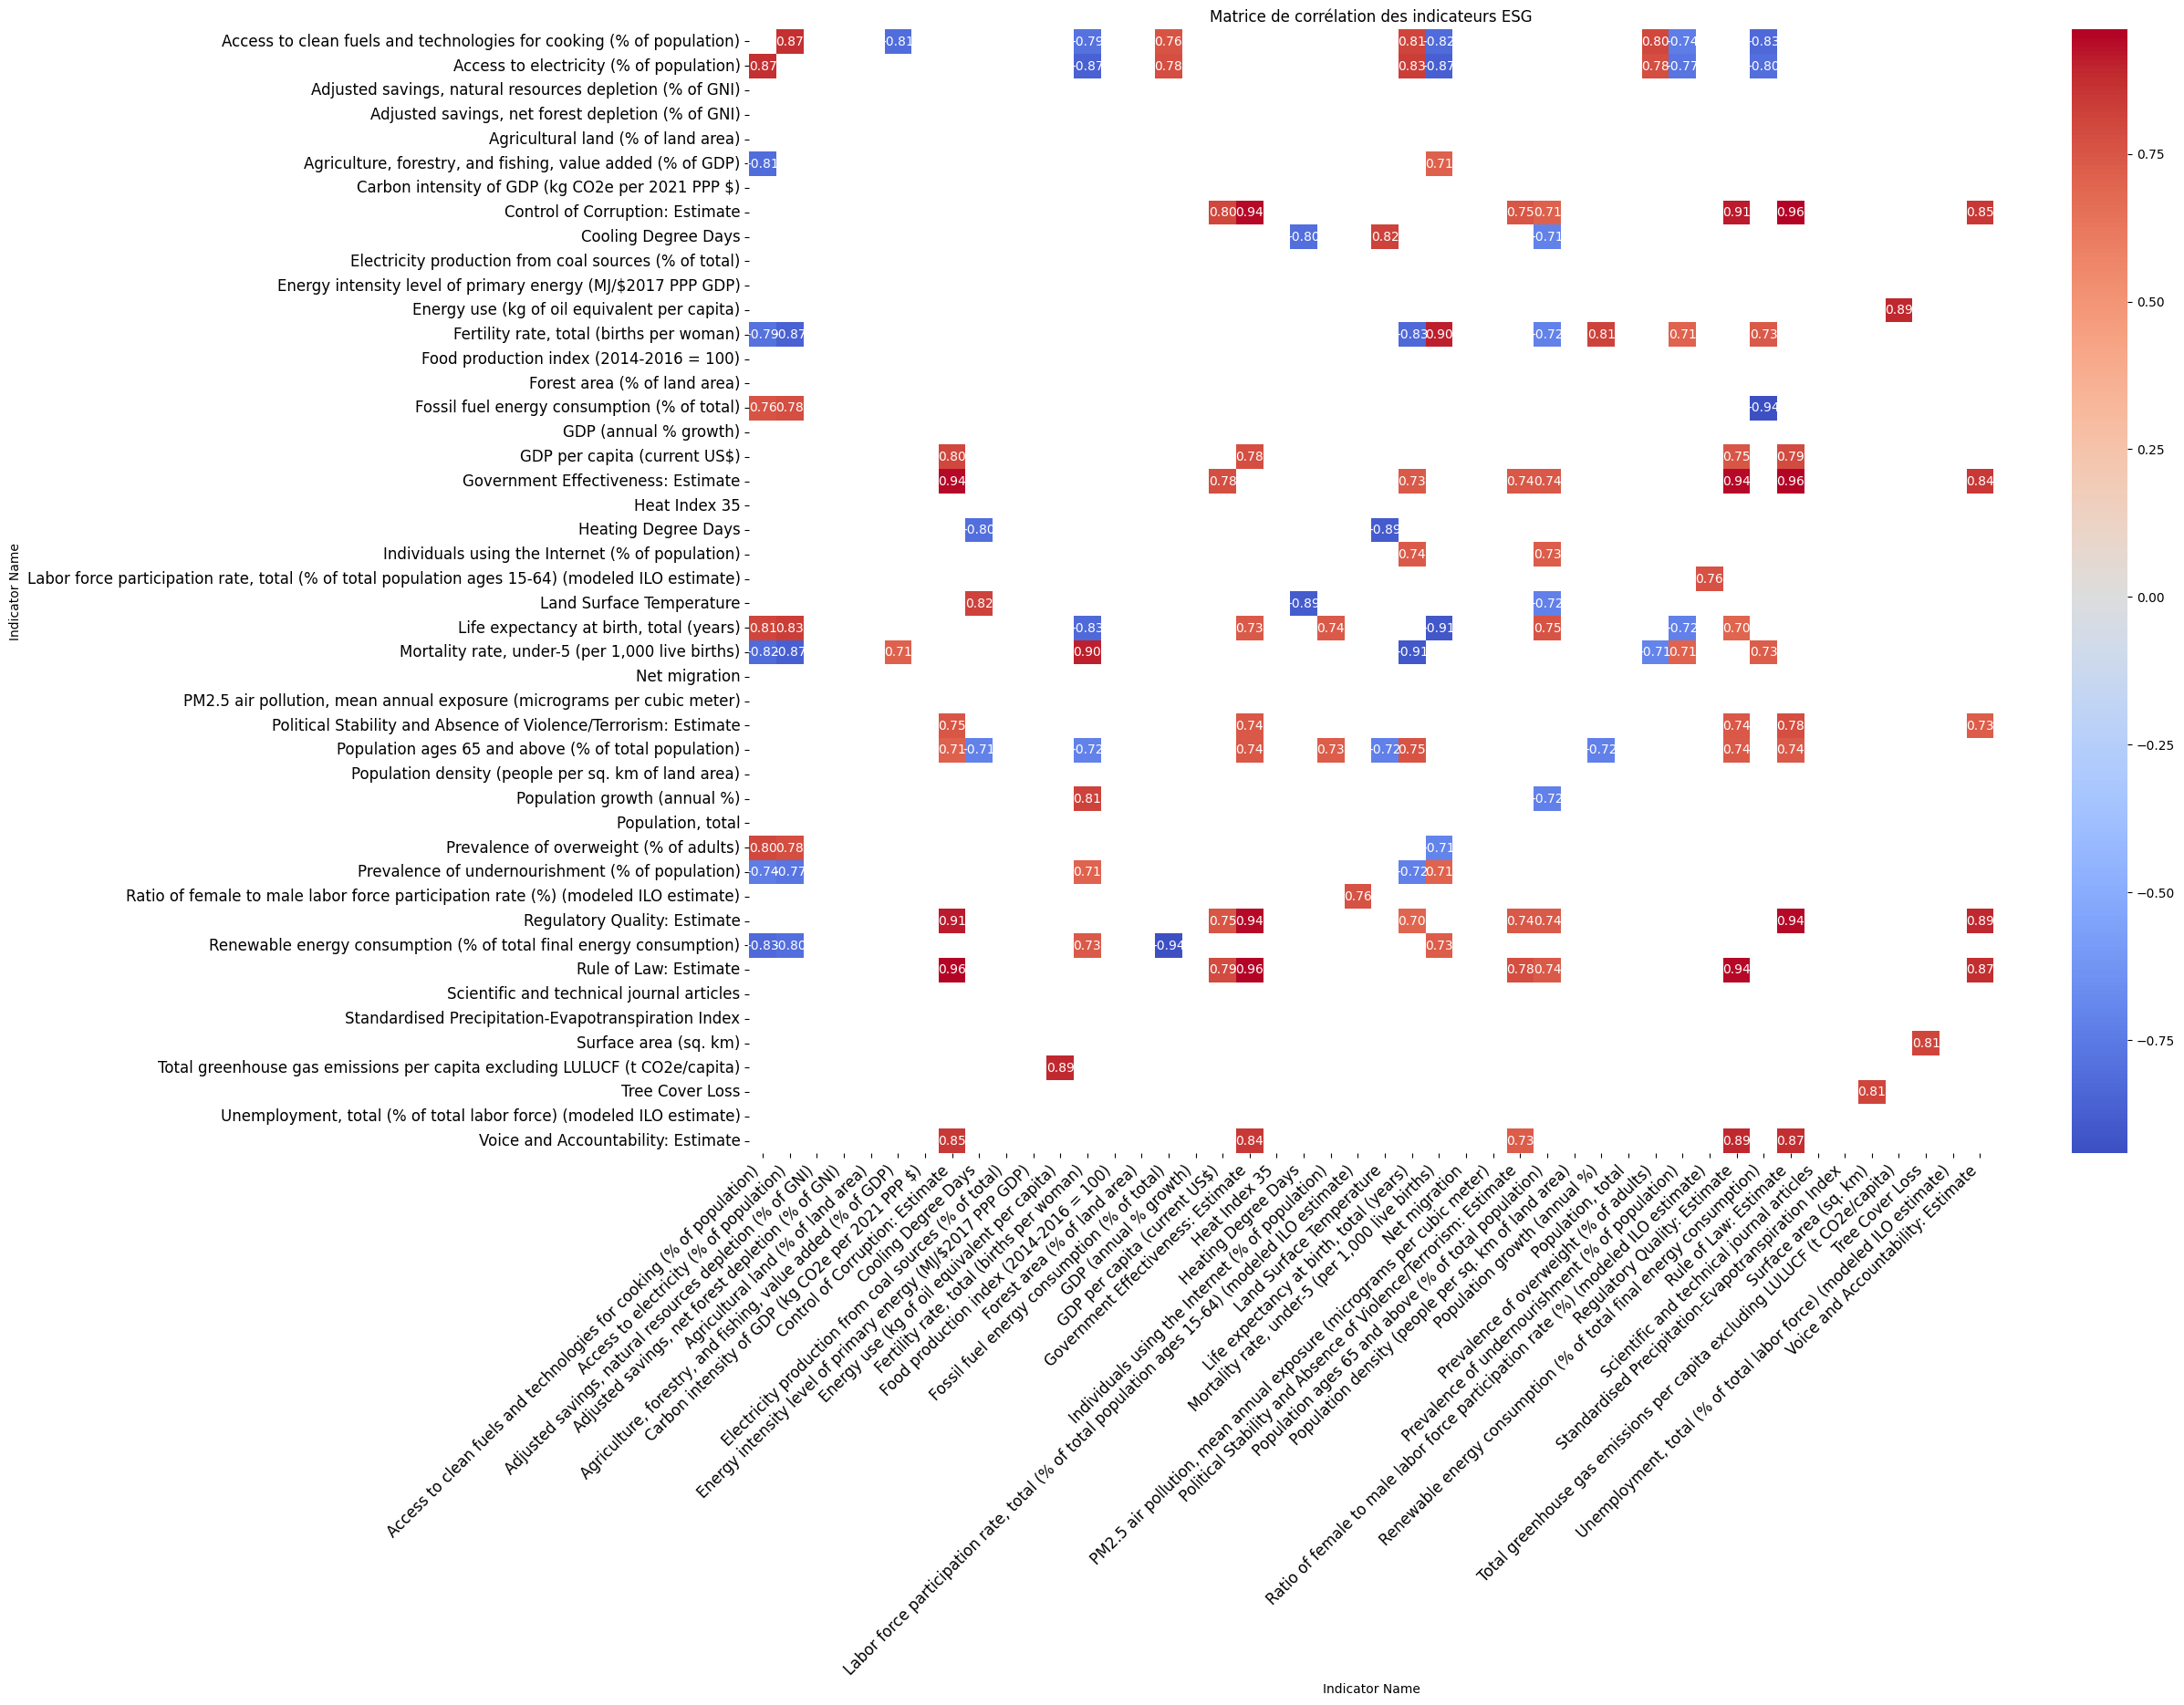

In [373]:
# Drow the correlation map
plt.figure(figsize=(22, 16))
sns.heatmap(
    strong_corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    annot_kws={"size": 10}  # Taille des nombres
)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.title("Matrice de corrélation des indicateurs ESG")
plt.show()


In [374]:
corr_with_CO2 = correlation_matrix["Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)"].sort_values(ascending=False).drop("Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)")
corr_with_CO2

Indicator Name
Energy use (kg of oil equivalent per capita)                                                       0.893648
Government Effectiveness: Estimate                                                                 0.609367
Access to clean fuels and technologies for cooking (% of population)                               0.588911
Rule of Law: Estimate                                                                              0.584835
GDP per capita (current US$)                                                                       0.581653
Regulatory Quality: Estimate                                                                       0.581477
Control of Corruption: Estimate                                                                    0.581423
Population ages 65 and above (% of total population)                                               0.526757
Life expectancy at birth, total (years)                                                            0.522752
Individuals using the Internet (% of population)                                                   0.518835
Political Stability and Absence of Violence/Terrorism: Estimate                                    0.513088
Voice and Accountability: Estimate                                                                 0.506167
Fossil fuel energy consumption (% of total)                                                        0.504325
Access to electricity (% of population)                                                            0.489562
Heating Degree Days                                                                                0.487858
Carbon intensity of GDP (kg CO2e per 2021 PPP $)                                                   0.481230
Prevalence of overweight (% of adults)                                                             0.440803
Surface area (sq. km)                                                                              0.360634
Electricity production from coal sources (% of total)                                              0.330310
Net migration                                                                                      0.315092
Scientific and technical journal articles                                                          0.285743
Tree Cover Loss                                                                                    0.230776
Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)    0.197380
Ratio of female to male labor force participation rate (%) (modeled ILO estimate)                  0.121379
Food production index (2014-2016 = 100)                                                            0.121053
Energy intensity level of primary energy (MJ/$2017 PPP GDP)                                        0.082574
Forest area (% of land area)                                                                       0.037320
Unemployment, total (% of total labor force) (modeled ILO estimate)                                0.022678
Standardised Precipitation-Evapotranspiration Index                                               -0.004201
Population, total                                                                                 -0.020425
Population density (people per sq. km of land area)                                               -0.063446
Adjusted savings, natural resources depletion (% of GNI)                                          -0.065401
Agricultural land (% of land area)                                                                -0.104248
GDP (annual % growth)                                                                             -0.142002
Heat Index 35                                                                                     -0.228674
Adjusted savings, net forest depletion (% of GNI)                                                 -0.258053
Population growth (annual %)                                                                     

In [375]:
comp_corr_with_CO2 = corr_with_CO2.reset_index()
comp_corr_with_CO2.rename(columns={"Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)": "Correlations before scaling"}, inplace=True)
rank = [i+1 for i in range(len(corr_with_CO2))]
comp_corr_with_CO2["Rank before scaling"] = rank
comp_corr_with_CO2

Indicator Name  \
0        Energy use (kg of oil equivalent per capita)   
1                  Government Effectiveness: Estimate   
2   Access to clean fuels and technologies for coo...   
3                               Rule of Law: Estimate   
4                        GDP per capita (current US$)   
5                        Regulatory Quality: Estimate   
6                     Control of Corruption: Estimate   
7   Population ages 65 and above (% of total popul...   
8             Life expectancy at birth, total (years)   
9    Individuals using the Internet (% of population)   
10  Political Stability and Absence of Violence/Te...   
11                 Voice and Accountability: Estimate   
12        Fossil fuel energy consumption (% of total)   
13            Access to electricity (% of population)   
14                                Heating Degree Days   
15   Carbon intensity of GDP (kg CO2e per 2021 PPP $)   
16             Prevalence of overweight (% of adults)   
17                              Surface area (sq. km)   
18  Electricity production from coal sources (% of...   
19                                      Net migration   
20          Scientific and technical journal articles   
21                                    Tree Cover Loss   
22  Labor force participation rate, total (% of to...   
23  Ratio of female to male labor force participat...   
24            Food production index (2014-2016 = 100)   
25  Energy intensity level of primary energy (MJ/$...   
26                       Forest area (% of land area)   
27  Unemployment, total (% of total labor force) (...   
28  Standardised Precipitation-Evapotranspiration ...   
29                                  Population, total   
30  Population density (people per sq. km of land ...   
31  Adjusted savings, natural resources depletion ...   
32                 Agricultural land (% of land area)   
33                              GDP (annual % growth)   
34                                      Heat Index 35   
35  Adjusted savings, net forest depletion (% of GNI)   
36                       Population growth (annual %)   
37  PM2.5 air pollution, mean annual exposure (mic...   
38                                Cooling Degree Days   
39   Prevalence of undernourishment (% of population)   
40           Fertility rate, total (births per woman)   
41    Mortality rate, under-5 (per 1,000 live births)   
42                           Land Surface Temperature   
43  Renewable energy consumption (% of total final...   
44  Agriculture, forestry, and fishing, value adde...   

    Correlations before scaling  Rank before scaling  
0                      0.893648                    1  
1                      0.609367                    2  
2                      0.588911                    3  
3                      0.584835                    4  
4                      0.581653                    5  
5                      0.581477                    6  
6                      0.581423                    7  
7                      0.526757                    8  
8                      0.522752                    9  
9                      0.518835                   10  
10                     0.513088                   11  
11                     0.506167                   12  
12                     0.504325                   13  
13                     0.489562                   14  
14                     0.487858                   15  
15                     0.481230                   16  
16                     0.440803                   17  
17                     0.360634                   18  
18                     0.330310                   19  
19                     0.315092                   20  
20                     0.285743                   21  
21                     0.230776                   22  
22                     0.197380                   23  
23                     0.121379                   24  
24                     0.121053          

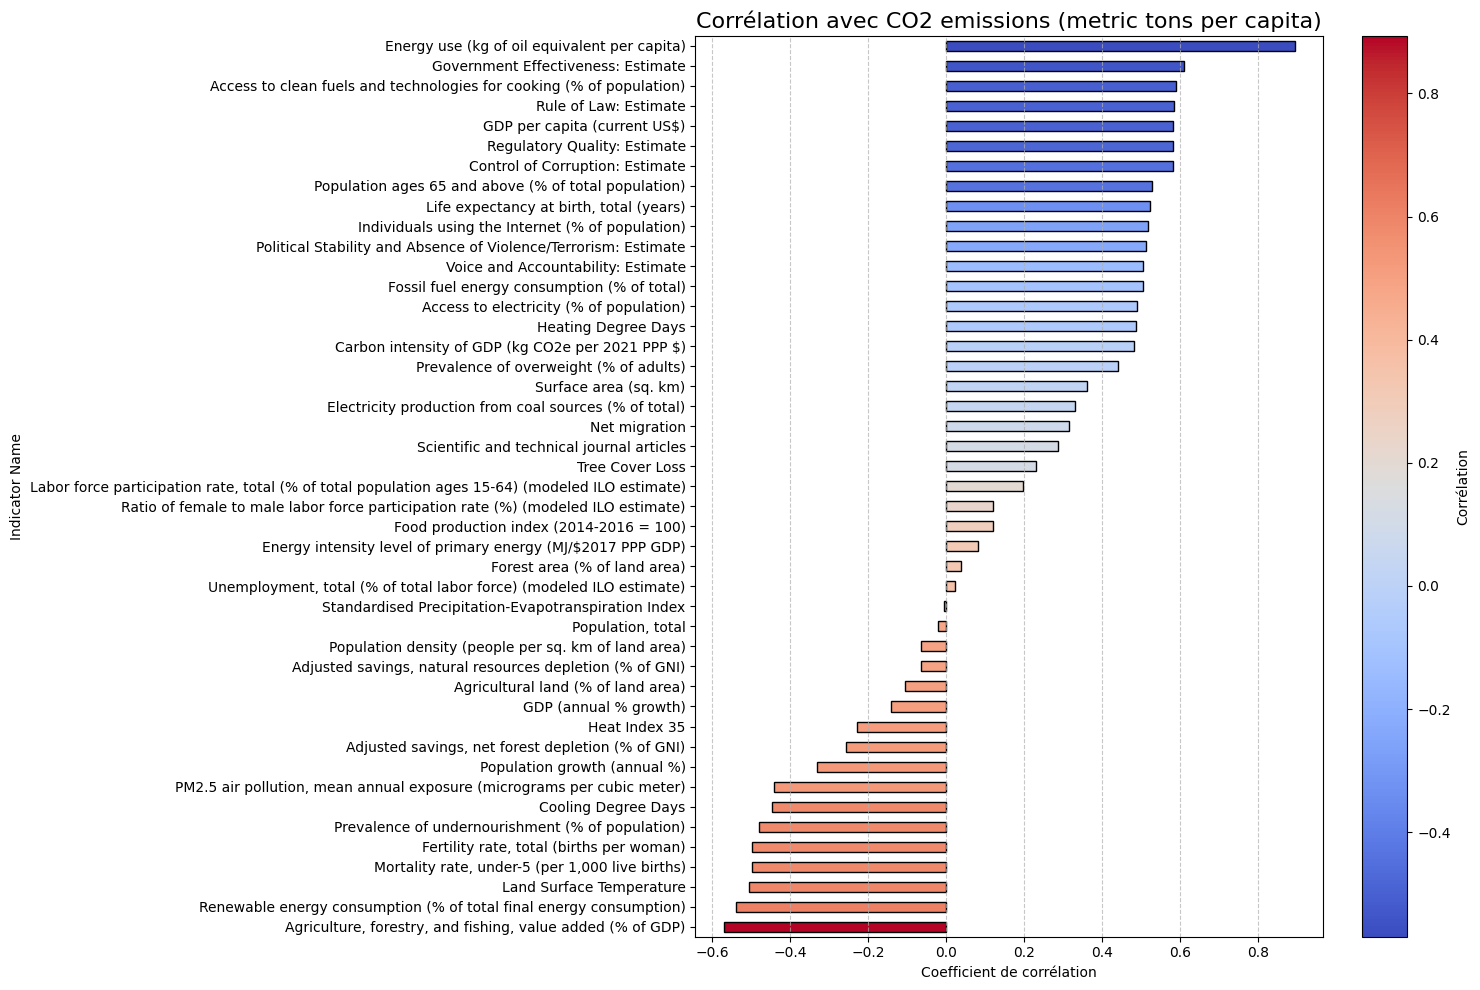

In [376]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 10))

# Création des couleurs selon les valeurs de corrélation
norm = plt.Normalize(vmin=corr_with_CO2.min(), vmax=corr_with_CO2.max())
colors = plt.cm.coolwarm(norm(corr_with_CO2))

# Tracé du graphique horizontal
corr_with_CO2.sort_values().plot(
    kind='barh',
    color=colors,
    edgecolor='black',
    ax=ax
)

ax.set_title("Corrélation avec CO2 emissions (metric tons per capita)", fontsize=16)
ax.set_xlabel("Coefficient de corrélation")
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Création de la colorbar liée explicitement à l'axe
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Corrélation')

plt.tight_layout()
plt.show()


## Analyse des variables

In [377]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters et regression

ind = "Access to clean fuels and technologies for cooking (% of population)"

to_remove = ["Access to electricity (% of population)"]

print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"] == "Access to electricity (% of population)")])
correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Access to clean fuels and technologies for cooking (% of population)    1.000000
Access to electricity (% of population)                                 0.871524
Agriculture, forestry, and fishing, value added (% of GDP)             -0.811409
Fertility rate, total (births per woman)                               -0.792587
Fossil fuel energy consumption (% of total)                             0.755474
Life expectancy at birth, total (years)                                 0.808874
Mortality rate, under-5 (per 1,000 live births)                        -0.818455
Prevalence of overweight (% of adults)                                  0.798012
Prevalence of undernourishment (% of population)                       -0.739800
Renewable energy consumption (% of total final energy consumption)     -0.826763
Name: Access to clean fuels and technologies for cooking (% of population), dtype: float64

In [378]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Agriculture, forestry, and fishing, value added (% of GDP)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Access to clean fuels and technologies for cooking (% of population)   -0.811409
Agriculture, forestry, and fishing, value added (% of GDP)              1.000000
Mortality rate, under-5 (per 1,000 live births)                         0.712907
Name: Agriculture, forestry, and fishing, value added (% of GDP), dtype: float64

In [379]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Rule of Law: Estimate"

to_remove += ["Control of Corruption: Estimate","Government Effectiveness: Estimate",  "Political Stability and Absence of Violence/Terrorism: Estimate", "Regulatory Quality: Estimate","Voice and Accountability: Estimate"]

print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"].isin(to_remove))])
correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Control of Corruption: Estimate                                    0.961060
GDP per capita (current US$)                                       0.788731
Government Effectiveness: Estimate                                 0.959636
Political Stability and Absence of Violence/Terrorism: Estimate    0.778780
Population ages 65 and above (% of total population)               0.737525
Regulatory Quality: Estimate                                       0.942083
Rule of Law: Estimate                                              1.000000
Voice and Accountability: Estimate                                 0.873018
Name: Rule of Law: Estimate, dtype: float64

In [380]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Energy use (kg of oil equivalent per capita)"

print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"].isin(to_remove))])

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Energy use (kg of oil equivalent per capita)                                  1.000000
Total greenhouse gas emissions per capita excluding LULUCF (t CO2e/capita)    0.893648
Name: Energy use (kg of oil equivalent per capita), dtype: float64

In [381]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Fertility rate, total (births per woman)"

to_remove += ["Mortality rate, under-5 (per 1,000 live births)","Population growth (annual %)"]
print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"].isin(to_remove))])

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Access to clean fuels and technologies for cooking (% of population)   -0.792587
Access to electricity (% of population)                                -0.866503
Fertility rate, total (births per woman)                                1.000000
Life expectancy at birth, total (years)                                -0.826627
Mortality rate, under-5 (per 1,000 live births)                         0.901774
Population ages 65 and above (% of total population)                   -0.715141
Population growth (annual %)                                            0.813411
Prevalence of undernourishment (% of population)                        0.706565
Renewable energy consumption (% of total final energy consumption)      0.734960
Name: Fertility rate, total (births per woman), dtype: float64

In [382]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Fossil fuel energy consumption (% of total)"
to_remove += ["Renewable energy consumption (% of total final energy consumption)"]
print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"].isin(to_remove))])

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Access to clean fuels and technologies for cooking (% of population)    0.755474
Access to electricity (% of population)                                 0.777648
Fossil fuel energy consumption (% of total)                             1.000000
Renewable energy consumption (% of total final energy consumption)     -0.942053
Name: Fossil fuel energy consumption (% of total), dtype: float64

In [383]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "GDP per capita (current US$)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Control of Corruption: Estimate       0.799705
GDP per capita (current US$)          1.000000
Government Effectiveness: Estimate    0.780642
Regulatory Quality: Estimate          0.746406
Rule of Law: Estimate                 0.788731
Name: GDP per capita (current US$), dtype: float64

In [384]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Land Surface Temperature"

to_remove += ["Heating Degree Days","Cooling Degree Days"]
print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"].isin(to_remove))])

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Cooling Degree Days                                     0.815219
Heating Degree Days                                    -0.888721
Land Surface Temperature                                1.000000
Population ages 65 and above (% of total population)   -0.724236
Name: Land Surface Temperature, dtype: float64

In [385]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Individuals using the Internet (% of population)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Individuals using the Internet (% of population)        1.000000
Life expectancy at birth, total (years)                 0.735363
Population ages 65 and above (% of total population)    0.726589
Name: Individuals using the Internet (% of population), dtype: float64

In [386]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)    1.000000
Ratio of female to male labor force participation rate (%) (modeled ILO estimate)                  0.760558
Name: Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate), dtype: float64

In [387]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Life expectancy at birth, total (years)"

to_remove += ["Population ages 65 and above (% of total population)"]

print(non_sig_pairs[(non_sig_pairs["Variable 1"] == ind) & (non_sig_pairs["Variable 2"].isin(to_remove))])
correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Empty DataFrame
Columns: [Variable 1, Variable 2, p-value]
Index: []


Indicator Name
Access to clean fuels and technologies for cooking (% of population)    0.808874
Access to electricity (% of population)                                 0.832935
Fertility rate, total (births per woman)                               -0.826627
Government Effectiveness: Estimate                                      0.734197
Individuals using the Internet (% of population)                        0.735363
Life expectancy at birth, total (years)                                 1.000000
Mortality rate, under-5 (per 1,000 live births)                        -0.908715
Population ages 65 and above (% of total population)                    0.754832
Prevalence of undernourishment (% of population)                       -0.723655
Regulatory Quality: Estimate                                            0.700330
Name: Life expectancy at birth, total (years), dtype: float64

In [388]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Population density (people per sq. km of land area)"

to_remove += ["Population, total","Surface area (sq. km)"]

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Population density (people per sq. km of land area)    1.0
Name: Population density (people per sq. km of land area), dtype: float64

In [389]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Prevalence of overweight (% of adults)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Access to clean fuels and technologies for cooking (% of population)    0.798012
Access to electricity (% of population)                                 0.780111
Mortality rate, under-5 (per 1,000 live births)                        -0.710572
Prevalence of overweight (% of adults)                                  1.000000
Name: Prevalence of overweight (% of adults), dtype: float64

In [390]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Prevalence of undernourishment (% of population)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Access to clean fuels and technologies for cooking (% of population)   -0.739800
Access to electricity (% of population)                                -0.772630
Fertility rate, total (births per woman)                                0.706565
Life expectancy at birth, total (years)                                -0.723655
Mortality rate, under-5 (per 1,000 live births)                         0.705691
Prevalence of undernourishment (% of population)                        1.000000
Name: Prevalence of undernourishment (% of population), dtype: float64

In [391]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Ratio of female to male labor force participation rate (%) (modeled ILO estimate)"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)    0.760558
Ratio of female to male labor force participation rate (%) (modeled ILO estimate)                  1.000000
Name: Ratio of female to male labor force participation rate (%) (modeled ILO estimate), dtype: float64

In [392]:
# Certains indicateurs ont une forte corrélation entre eux, et représentent la même idée les conserver tous n'est pas très intérréssant et risque de biaiser clusters

ind = "Tree Cover Loss"

correlation_matrix[abs(correlation_matrix[ind])>=0.7][ind]

Indicator Name
Surface area (sq. km)    0.809914
Tree Cover Loss          1.000000
Name: Tree Cover Loss, dtype: float64

In [393]:
print(len(to_remove))
to_remove

14


['Access to electricity (% of population)',
 'Control of Corruption: Estimate',
 'Government Effectiveness: Estimate',
 'Political Stability and Absence of Violence/Terrorism: Estimate',
 'Regulatory Quality: Estimate',
 'Voice and Accountability: Estimate',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population growth (annual %)',
 'Renewable energy consumption (% of total final energy consumption)',
 'Heating Degree Days',
 'Cooling Degree Days',
 'Population ages 65 and above (% of total population)',
 'Population, total',
 'Surface area (sq. km)']

In [394]:
ESG_df_ByInd_clean = ESG_df_ByInd.drop(columns=to_remove)
len(ESG_df_ByInd_clean.columns)

34

# Dataset propre

In [395]:
# Conserver le dataset actuel

ESG_df_ByInd_clean.to_csv('ESG_df_ByInd_clean.csv', index=False)

In [396]:
ESG_df_ByInd_clean.head()

Indicator Name Country Name  Year  \
23                  Albania  2000   
24                  Albania  2001   
25                  Albania  2002   
26                  Albania  2003   
27                  Albania  2004   

Indicator Name  Access to clean fuels and technologies for cooking (% of population)  \
23                                                           35.2                      
24                                                           38.3                      
25                                                           41.4                      
26                                                           45.1                      
27                                                           47.8                      

Indicator Name  Adjusted savings, natural resources depletion (% of GNI)  \
23                                                         0.4673          
24                                                         0.2862          
25                                                         0.2961          
26                                                         0.3129          
27                                                         0.3654          

Indicator Name  Adjusted savings, net forest depletion (% of GNI)  \
23                                                         0.1229   
24                                                         0.0607   
25                                                         0.0649   
26                                                         0.0614   
27                                                         0.0528   

Indicator Name  Agricultural land (% of land area)  \
23                                         41.7518   
24                                         41.5693   
25                                         41.6058   
26                                         40.9124   
27                                         40.9489   

Indicator Name  Agriculture, forestry, and fishing, value added (% of GDP)  \
23                                                        22.1790            
24                                                        20.4524            
25                                                        19.7639            
26                                                        19.8076            
27                                                        18.5631            

Indicator Name  Carbon intensity of GDP (kg CO2e per 2021 PPP $)  \
23                                                        0.1590   
24                                                        0.1554   
25                                                        0.1730   
26                                                        0.1726   
27                                                        0.1719   

Indicator Name  Electricity production from coal sources (% of total)  \
23                                                            0.0       
24                                                            0.0       
25                                                            0.0       
26                                                            0.0       
27                                                            0.0       

Indicator Name  Energy intensity level of primary energy (MJ/$2017 PPP GDP)  \
23                                                           4.03             
24                                                           3.79             
25                                                           4.00             
26                                                           3.71             
27                                                           3.86             

Indicator Name  ...  Population density (people per sq. km of land area)  \
23              ...                                           112.7382     
24              ...                                           111.6851     
25              ...            

# Bibliography

* https://statisticsbyjim.com/basics/remove-outliers/
* https://www.neuraldesigner.com/blog/effective-outlier-treatment-methods-machine-learning/
* Principled missing data methods for researchers
Yiran Dong and Chao-Ying Joanne Peng*